# Week 1 - Counting Words & Phrases

This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words, simple and parsed phrases and explore the statistical properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the correlation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of **part-of-speech (POS)** tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with wordl! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora. 

Then we shift to focus not simply on the *ideas* in a corpus, but also extracting precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases.

We will be introducing spaCy as a package for Computational Linguistics, and also walk you through how to use the Davies Corpora. 

While we wish to avoid using NLTK for heavy corpus analysis, some of its smaller functions can still be useful.

Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:


In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud_2020 #pip install git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas as pd#gives us DataFrames
import pandas
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Retrieving exemplary corpora

To get started we will need some examples. Let's start by downloading one of the corpuses from the Davies set purchased for this class and developed by a computational linguist at Brigham Young University. We can get a list of works available from the [corpora here](https://www.english-corpora.org/).

In this notebook, I will be accessing the data locally - you also have access to this data through the Dropbox download link. The same code can be modified slighlty to access the rest of the corpora on RCC. 
There is a notebook describing this process in the same repository, as well as in the same directory on RCC.

In [2]:
corpus_name = "Movies"

#corpus_name = "Movies"

This method extracts the text from the zip files and stores the raw data.

In [3]:
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

Let's look at what the code chunk above does. 

First, "def" function literally defines a function. You can call the function that you defined by using the function name, which is, here, loadcorpus. 

Second, it might be obvious, but, in Python, + operator is used when you combine literal strings or string variables. So, "corpus_name" + "/" gets you "corpus_name/". For example, in my case, the corpus_name is 'Users/hyunkukwon/Downloads/Movies'; so, corpus_name + "/" gives me '/Users/hyunkukwon/Downloads/Movies/'. By the way, why do we use "" here? This is because / is an operator in itself. Using "" makes / a string rather than an operator. Just to let you know, you can use type() to see what's the type of something. For example, if you write type(corpus_name), it'll get you 'string'.

**Third, the "os.listdir" function is used to get the list of files in the specified directory.** So, here we're trying to get all the files in the directory. 

But we have some problems here: 

(1) first problem is that we do not want to load all the files in this directory; we want to load the files that have 'text' in the file name. So, we use the "if corpus_style in file:" to get the files that have the textual characteristics that we specified when we defined the function (corpus_style = "text"). Just to clarify, specifying the corpus_style does not get us the `.txt` files (in other words, it's not about the file extension). 

(2) second problem is that the files we have are zip files. So, we should unzip it so that we can get them on Python. That's why we use ZipFile, a class of zipfile module. We use ZipFile to read and write zip files. Then we use namelist() function, which returns the list of archive members by name.

Finally, append() function adds an item at the end of the list. Here, we make an empty list by doing "texts_raw[file] = []"; and then we open the file, get every line in the file, and then append it to the empty list. The for loop does the iteration. 

By the way, we used something similar above: "texts_raw = {}". But they're different: {} is a dictionary, while [] is a list. 

In [4]:
movie_raw = loadcorpus(corpus_name)

text_13_idi.zip
text_16_qll.zip
text_32_ldf.zip
text_19_gvc.zip
text_05_nko.zip
text_17_arp.zip
text_01_ote.zip
text_28_rfy.zip
text_31_akv.zip
text_22_etp.zip
text_11_uoy.zip
text_09_oii.zip
text_06_jfy.zip
text_14_lnc.zip
text_08_loh.zip
text_33_kje.zip
text_30_wkp.zip
text_07_oma.zip
text_03_mnq.zip
text_21_fqa.zip
text_29_oye.zip
text_27_fle.zip
text_23_fmh.zip
text_12_rcq.zip
text_00_myn.zip
text_10_aoy.zip
text_04_mlq.zip
text_20_cde.zip
text_02_mqu.zip
text_26_ngj.zip
text_24_ywo.zip
text_18_jfj.zip
text_25_byg.zip
text_15_guo.zip


Why do we get this list of files? Because of the "print(file)" in the code chunk above. So, the list here involves all the files that have "text" in their file name. 

Let's look at one of the files:

In [5]:
movie_raw['11.txt'][0:3]

[b'\r\n',
 b'@@216680 Hey , I \'m talking to you Give me 600 dollars You wish ! That \'s all we \'ve left And you still go to gamble Shut up I earn the money Even that you ca n\'t take it for gamble Shut up What \'re you doing ? Bastard , I \'m gon na beat you You gambling pig , I \'ll beat the shit out of you You bitch I \'ll beat you You dare to hit me with something ! I \'ll kill you All you know is gambling I \'ll beat you What \'re you doing ? Let go of me Stop You \'ll kill Mom Mom , are you all right ? Do n\'t touch my money Dad , where \'re you going ? Go away Dad , do n\'t go Get lost Dad , come back You take Marble with you The way she \'s now Do you want to give me trouble ? I \'m in more trouble than you I am a woman I \'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Do n\'t marry a gambler Hey , 

It seems messy, but nothing we can't clean. This basic method replaces some of the issues with the formatting, and prints the errors if any for debugging. Let us clean one of the raw text files.

We ignore the non-unicode data for convenience in our first pass.

In [6]:
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

Now we're familiar with the code structure (such as for loop) as well as some functions (such as append). Let's briefly look at the functions that didn't appear above.

replace() is a Python built-in function for strings. What it does is: it replaces the one that comes before with the one that comes later. The syntax of this function is the following: str.replace(old, new[, max]). The [, max] part is optional, and we didn't use it here. For example, text.replace(" \'m", "'m") literally replaces /'m with 'm. 

decode() is a function which literally converts from one encoding scheme to the other one.

In [7]:
clean_11 = clean_raw_text(movie_raw['11.txt'])

In [8]:
clean_11[1]

'@@216680 Hey , I\'m talking to you Give me 600 dollars You wish ! That\'s all we\'ve left And you still go to gamble Shut up I earn the money Even that you can\'t take it for gamble Shut up What\'re you doing ? Bastard , I\'m gon na beat you You gambling pig , I\'ll beat the shit out of you You bitch I\'ll beat you You dare to hit me with something ! I\'ll kill you All you know is gambling I\'ll beat you What\'re you doing ? Let go of me Stop You\'ll kill Mom Mom , are you all right ? Don\'t touch my money Dad , where\'re you going ? Go away Dad , don\'t go Get lost Dad , come back You take Marble with you The way she\'s now Do you want to give me trouble ? I\'m in more trouble than you I am a woman I\'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Don\'t marry a gambler Hey , you want a quarrel ? No , never

This method cleaned a few basic formatting errors. You are welcome to experiment and add your own code to expand on cleaning the text. Once it begins to look the way you want it to, we can start using spaCy to do some heavier cleaning. spaCy does this through the use of language models. Make sure you have the spaCy english language model loaded. 

In [9]:
nlp = spacy.load("en")

This model is going to be the basis of most of the tasks which NLTK (the Natural Language Tool Kit) might have done otherwise. While NLTK uses a bunch of clunky models from multiple places, spacy neatly packs all functionality in one model. This deep trained model will start by doing our word tokenizing and normalising. These methods are already included in lucem illud, and here we will just demonstrate them outside the package so to explain what goes on under the hood.

When we run text through a spacy model, it performs a lot of computation on each of the tokens. Each token is given certain attributes, such as a part of speech, information whether it is a number, a stop word, and so on. 

To perform a **tokenization**, we check if the string includes punctuation and add this token. 

In [10]:
# help(nlp)

In [11]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

Let's look at the cell above. What are we doing here? We want to tokenize the corpus, i.e. split the text into minimal meaningful units. To do so, we collect tokens in the document that is neither punctuation (e.g. "?", ",", "!" etc) nor the ones the length of which is not bigger than 0. is_punct tells you if a token is a punctuation or not; so, we use "if not" to weed out punctuations. len(token.text.strip()) gets you the length of each string; so, we remove strings the length of which is not bigger than 0. By the way, strip() function here returns a copy of the wtring with both leading and trailing characters stripped. Since we didn't specify any characters, it merely removes the spaces before and after each string.

In [12]:
word_tokenize(clean_11[1])

['@@216680',
 'Hey',
 'I',
 "'m",
 'talking',
 'to',
 'you',
 'Give',
 'me',
 '600',
 'dollars',
 'You',
 'wish',
 'That',
 "'s",
 'all',
 'we',
 "'ve",
 'left',
 'And',
 'you',
 'still',
 'go',
 'to',
 'gamble',
 'Shut',
 'up',
 'I',
 'earn',
 'the',
 'money',
 'Even',
 'that',
 'you',
 'ca',
 "n't",
 'take',
 'it',
 'for',
 'gamble',
 'Shut',
 'up',
 'What',
 "'re",
 'you',
 'doing',
 'Bastard',
 'I',
 "'m",
 'gon',
 'na',
 'beat',
 'you',
 'You',
 'gambling',
 'pig',
 'I',
 "'ll",
 'beat',
 'the',
 'shit',
 'out',
 'of',
 'you',
 'You',
 'bitch',
 'I',
 "'ll",
 'beat',
 'you',
 'You',
 'dare',
 'to',
 'hit',
 'me',
 'with',
 'something',
 'I',
 "'ll",
 'kill',
 'you',
 'All',
 'you',
 'know',
 'is',
 'gambling',
 'I',
 "'ll",
 'beat',
 'you',
 'What',
 "'re",
 'you',
 'doing',
 'Let',
 'go',
 'of',
 'me',
 'Stop',
 'You',
 "'ll",
 'kill',
 'Mom',
 'Mom',
 'are',
 'you',
 'all',
 'right',
 'Do',
 "n't",
 'touch',
 'my',
 'money',
 'Dad',
 'where',
 "'re",
 'you',
 'going',
 'Go',
 'a

You can see how the sentence is broken into its constituent words. We can then do some analysis with this. 

Note: we still don't know which movie this is, just that it is raw movie text data. Maybe in the process of our text cleaning and counting we will come across something!

# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [13]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

What's going on here? We first make an empty dictionary (by the way, if you're not familiar with dictionaries, you should go look it up online.) Then, we go through each word in the word list one by one with the for loop. If the word that the loop is looking at has appeared before, we add one more to the number("+=1"); if it didn't appear before, we assign one to the word ("= 1"). 

And then we convert it to DataFrame. Why do we use wordCounts.items() here? Because the wordCounts that we defined above is a dictionary; and items() returns the list of all dictionary keys with values. And then we use pandas.DataFrame to convert this dictionary to DataFrame.

In [14]:
countedWords = wordCounter(word_tokenize(clean_11[1]))
countedWords[:10]

word  count
0  @@216680      1
1       hey     16
2         i    191
3        'm     24
4   talking      2
5        to    112
6       you    302
7      give     14
8        me     82
9       600      1

Lets sort and plot our counts to investigate the shape of our word frequency distribution.

First we need to sort the words by count.

In [15]:
# Doing this in place (changing the original DataFrame) 
# as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

word  count
6        you    302
2          i    191
13        's    126
5         to    112
31        it    109
..       ...    ...
248  postman     10
187   please      9
328      but      9
215       as      9
135      say      9

[100 rows x 2 columns]

Punctuation and very common words (articles 'a' and 'the'; prepositions 'of' and 'to') make up the most common values, but this isn't very interesting and can actually get in the way of our analysis. **We may remove these 'function words' by removing according to a stopword list, setting some frequency threshold, or using a weighting scheme (like tf.idf) to decrease their influence** - we will look at these methods in more detail as we go through this tutorial. 

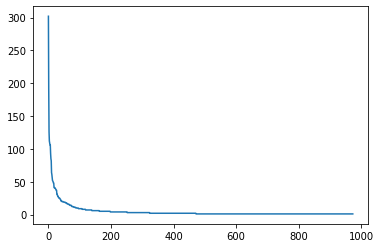

In [16]:
#Creating a figure and axis lets us do things like change the scaling or add a title
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

**This shows that likelihood of a word occurring is inversely proportional to its rank.** This effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), and suggests that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. **Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log (rank order) and log (frequency) resulting in a linear relationship.**

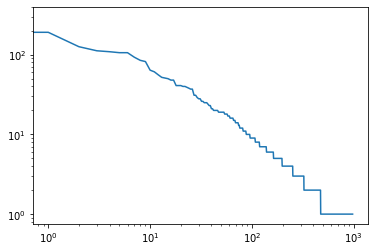

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

(The same relationship occurs in many other rankings, such as population ranks of cities, corporation sizes, income rankings, etc.) 

The distribution was imagined by Zipf to be driven by a principle of 'least effort' where speakers did not work any harder than necessary to communicate a given idea, but the basis for this relationship is still not well understood and conforms at least as well to a process of [preferential attachment](https://en.wikipedia.org/wiki/Preferential_attachment) whereby people disproportionately attend to popular words.


# Getting and working with raw text

First, we will retrieve **a collection of press releases** from a *GitHub API* that archived them, based on a number of analyses by Justin Grimmer, a political scientist whose work we will read in a few weeks!

GitHub API requests are made to `'https://api.github.com/'` and responses are in JSON, similar to Tumblr's API.

We will get the information on [github.com/lintool/GrimmerSenatePressReleases](https://github.com/lintool/GrimmerSenatePressReleases) as it contains a nice set documents.

In [18]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases')
senateReleasesData = json.loads(r.text)
# print(senateReleasesData)
print(senateReleasesData.keys())
print()
print(senateReleasesData['description'])

dict_keys(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'forks_count', 'mirror_url', 'archived', 'disabled', 'open_issues_count', 'lic

What we are interested in here is the `'contents_url'`

In [19]:
print(senateReleasesData['contents_url'])

https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/{+path}


We can use this to get any or all of the files from the repo.

In [20]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse')
whitehouseLinks = json.loads(r.text)
# print(whitehouseLinks)
whitehouseLinks[0]

{'name': '10Apr2007Whitehouse123.txt',
 'path': 'raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'sha': 'f524289ee563dca58690c8d36c23dce5dbd9962a',
 'size': 2206,
 'url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
 'html_url': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'git_url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
 'download_url': 'https://raw.githubusercontent.com/lintool/GrimmerSenatePressReleases/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'type': 'file',
 '_links': {'self': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
  'git': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
  'html': 'https:/

Now we have a list of information about Whitehouse press releases. Let's look at one of them.

In [21]:
r = requests.get(whitehouseLinks[0]['download_url'])
whitehouseRelease = r.text
print(whitehouseRelease[:1000])
len(whitehouseRelease)

SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY IN PUSH FOR STEM CELL RESEARCH
  Sharing the story of Lila Barber, a 12 year old girl from Westerly, Sen. Sheldon Whitehouse (D-R.I.) on Tuesday, April 10, 2007, illustrated the hope stem cell research can offer in a speech on the Senate floor in favor of legislation to expand federal funding for stem cell research.  
   Whitehouse met Lila two weeks ago. She was diagnosed two years ago with osteosarcoma, a cancerous bone condition, and last year underwent cadaver bone transplant surgery. The procedure saved her leg and is helping her remain cancer-free, but the transplanted tissue will not grow with her and likely will break down over time. Stem cell research, Whitehouse explained, could vastly improve the care of patients like Lila by allowing surgeons to enhance transplants with a patient's own stem cells, which could replace the lost bone and cartilage, or grow entirely new replacement bones and joints. 
   "Stem cell research gives hope

2206

Now we have a string of correctly encoded text. For analysis of its words, next we need to tokenize it, or split it into a sequence of tokens or word instances.

In [22]:
whTokens = word_tokenize(whitehouseRelease)
whTokens[10:30]

['STEM',
 'CELL',
 'RESEARCH',
 'Sharing',
 'the',
 'story',
 'of',
 'Lila',
 'Barber',
 'a',
 '12',
 'year',
 'old',
 'girl',
 'from',
 'Westerly',
 'Sen.',
 'Sheldon',
 'Whitehouse',
 'D']

Previous iterations of the course used `nltk`s tokenizer, but as we saw before, we used spaCy's model (https://spacy.io/api/tokenizer). We intend to avoid using NLTK when we can - for production level code, it is a lot faster and cleaner to use spaCy.

That being said, `nltk` does have some useful methods for quick analysis of small corpora. We will explore a few here, and encourage you to figure out for yourself which other ones might be useful.

To use the list of tokens in `nltk`, and take advantage of functions like `concordance`, shown above, we can convert it into a `Text`.

In [23]:
import nltk

In [24]:
# help(nltk.text.ConcordanceIndex)

In [25]:
whText = nltk.Text(whTokens)

whitehouseIndex = nltk.text.ConcordanceIndex(whText) 
whitehouseIndex.print_concordance('Whitehouse')

Displaying 5 of 5 matches:
ld girl from Westerly Sen. Sheldon Whitehouse D R.I. on Tuesday April 10 2007 il
ral funding for stem cell research Whitehouse met Lila two weeks ago She was dia
 down over time Stem cell research Whitehouse explained could vastly improve the
s research might help or even cure Whitehouse said Whitehouse also praised the e
 help or even cure Whitehouse said Whitehouse also praised the efforts of Rhode 


*Note* that the `Text` class is for doing rapid, exploratory analysis. **It provides an easy interface to many of the operations we want to do, but it does not allow us much control over the particular operations it glosses. When you are doing a more complete analysis, you should be using the module specifically designed for that task instead of the shortcut method `Text` provides**, e.g. use  [`collocations` Module](http://www.nltk.org/api/nltk.html#module-nltk.collocations) instead of `.collocations()`.

Now that we have gotten this loaded, let's glance at few features we will delve into more deeply later.

For example, we can find words that statistically tend to occur together and typically have a composite, idiomatic meaning irreducible to the semantics of its component words. We will do this later with more control over exactly how these are identified.

Or we can pick a word (or words) and find what words tend to occur around it.

In [26]:
type(whText.common_contexts(['stem']))

for_cell hope_cell time_cell own_cells joints_cell of_cell on_cells
the_cell embryonic_cells


NoneType

We can also just count the number of times the word occurs.

In [27]:
whText.count('cell')

5


We can also plot each time a set of words occurs.

In [28]:
help(whText.dispersion_plot)

Help on method dispersion_plot in module nltk.text:

dispersion_plot(words) method of nltk.text.Text instance
    Produce a plot showing the distribution of the words through the text.
    Requires pylab to be installed.
    
    :param words: The words to be plotted
    :type words: list(str)
    :seealso: nltk.draw.dispersion_plot()



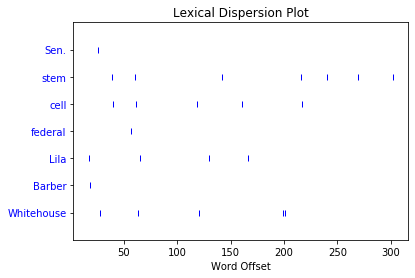

In [29]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Sen.','stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])
sns.set() #Re-enabling seaborn

If we want to do an analysis of all the Whitehouse press releases we will first need to obtain them. By looking at the API we can see the the URL we want is [https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse](https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse), so we can create a function to scrape the individual files.

If you want to know more about downloading from APIs, refer back to the 1st notebook.

In [30]:
def getGithubFiles(target, maxFiles=100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

whReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse', maxFiles=10)
whReleases[:5]

name  \
0  10Apr2007Whitehouse123.txt   
1    10Apr2008Whitehouse2.txt   
2    10Apr2008Whitehouse3.txt   
3   10Aug2007Whitehouse78.txt   
4   10Jan2008Whitehouse35.txt   

                                                text  \
0  SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...   
1  SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...   
2  EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...   
3  R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...   
4  SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...   

                                        path  \
0  raw/Whitehouse/10Apr2007Whitehouse123.txt   
1    raw/Whitehouse/10Apr2008Whitehouse2.txt   
2    raw/Whitehouse/10Apr2008Whitehouse3.txt   
3   raw/Whitehouse/10Aug2007Whitehouse78.txt   
4   raw/Whitehouse/10Jan2008Whitehouse35.txt   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   

                                        download_url  
0  https://raw.githubusercontent.com/lintool/Grim...  
1  https://raw.githubusercontent.com/lintool/Grim...  
2  https://raw.githubusercontent.com/lintool/Grim...  
3  https://raw.githubusercontent.com/lintool/Grim...  
4  https://raw.githubusercontent.com/lintool/Grim...

If you are having trouble downloading the data uncomment this next cell

In [31]:
#whReleases = pandas.read_csv('../data/whReleases.csv')

Now we have all the texts in a DataFrame we can look at a few things.

First let's tokenize the texts with the same tokenizer as we used before. We will just save the tokens as a list for now; no need to convert to `Text`s.

In [32]:
whReleases['tokenized_text'] = whReleases['text'].apply(lambda x: word_tokenize(x))

Now lets see how long each of the press releases is:

In [33]:
whReleases['word_counts'] = whReleases['tokenized_text'].apply(lambda x: len(x))
whReleases['word_counts']

0    350
1    311
2    497
3    189
4    236
5    334
6    241
7    469
8    443
9    425
Name: word_counts, dtype: int64

But before we proceed: what is the lambda function here? What the lambda function does here is that it iterates over the list row by row and applies the function, e.g. word_tokenize() or len(), to each list. So, it looks similar to for loop; but, lambda is an expression while for loop is a statement. I won't elaborate on the difference between these two here for space limitations. 

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </span>

My project wishes to implement content analysis on the political speeches from all U.S. presidents, from the First Inaugural Adress by George Washing to the latest White House press conference on the coronavirus delivered by Donald Trump. The corpus was constructed by dynamically spidering the website, [Miller Center](https://millercenter.org/the-presidency/presidential-speeches). The `presidential_speech_crawler.py` contains the web crawling code and the collected data are stored in `presidential_speeches.csv`.

In [34]:
# Load the constructed presidential speech corpus
speech = pd.read_csv("presidential_speeches.csv", index_col=0)
speech.sample(10, random_state=25)

link  \
688  https://millercenter.org/the-presidency/presid...   
49   https://millercenter.org/the-presidency/presid...   
288  https://millercenter.org/the-presidency/presid...   
698  https://millercenter.org/the-presidency/presid...   
775  https://millercenter.org/the-presidency/presid...   
305  https://millercenter.org/the-presidency/presid...   
279  https://millercenter.org/the-presidency/presid...   
599  https://millercenter.org/the-presidency/presid...   
988  https://millercenter.org/the-presidency/presid...   
627  https://millercenter.org/the-presidency/presid...   

                                                 title               date  \
688           December 6, 1881: First Annual Message\n  December 06, 1881   
49   October 21, 2011: Remarks on the End of the Wa...   October 21, 2011   
288  February 25, 1971: Radio Address About Second ...  February 25, 1971   
698  April 29, 1879: Veto of Army Appropriations Bi...     April 29, 1879   
775       January 1, 1863: Emancipation Proclamation\n   January 01, 1863   
305                August 18, 1967: Press Conference\n    August 18, 1967   
279  January 23, 1973: Address to the Nation Announ...   January 23, 1973   
599           December 5, 1905: Fifth Annual Message\n  December 05, 1905   
988  December 3, 1793: Fifth Annual Message to Cong...  December 03, 1793   
627  January 11, 1897: Message Regarding Treaty wit...   January 11, 1897   

                    name                                    source  \
688    Chester A. Arthur                         National Archives   
49          Barack Obama                                       NaN   
288     Richard M. Nixon                         National Archives   
698  Rutherford B. Hayes                           (not specified)   
775      Abraham Lincoln                         National Archives   
305    Lyndon B. Johnson  Lyndon Baines Johnson Library and Museum   
279     Richard M. Nixon                         National Archives   
599   Theodore Roosevelt                         National Archives   
988    George Washington                             Miller Center   
627     Grover Cleveland                           (not specified)   

                                                script  
688  TranscriptTo the Senate and House of Represent...  
49   \nTranscript\nGood afternoon, everybody.  As a...  
288  \nTranscript\nGood morning, my fellow American...  
698  TranscriptTo the House of Representatives:\nI ...  
775  TranscriptBy the President of the United State...  
305  \nTranscript\nTHE PRESIDENT. Good afternoon, l...  
279  \nTranscript\nGood evening:\nI have asked for ...  
599  TranscriptTo the Senate and House of Represent...  
988  TranscriptFellow Citizens of the Senate and of...  
627  TranscriptTo the Senate:\nI transmit herewith ...

The U.S. presidential speech corpus contains one thousand pieces of talkings. Considering the running time, I randomly chose ten speeches of **Donald Trump** and **Barack Obama** respecively.

In [35]:
trump = speech.loc[speech["name"] == "Donald Trump"].sample(10, random_state=25)
trump.head(3)

link  \
2   https://millercenter.org/the-presidency/presid...   
10  https://millercenter.org/the-presidency/presid...   
21  https://millercenter.org/the-presidency/presid...   

                                                title               date  \
2    February 6, 2020: Remarks after HIs Acquittal \n  February 06, 2020   
10  February 15, 2019: Speech Declaring a National...  February 15, 2019   
21  December 18, 2017: Remarks on National Securit...  December 18, 2017   

            name           source  \
2   Donald Trump  The White House   
10  Donald Trump  The White House   
21  Donald Trump  The White House   

                                               script  
2   \nTranscript\nWell, thank you very much. (Appl...  
10  \nTranscript\nTHE PRESIDENT:  Thank you very m...  
21  \nTranscript\nTHE PRESIDENT: Thank you very mu...

In [36]:
obama = speech.loc[speech["name"] == "Barack Obama"].sample(10, random_state=35)
obama.head(3)

link  \
66  https://millercenter.org/the-presidency/presid...   
53  https://millercenter.org/the-presidency/presid...   
49  https://millercenter.org/the-presidency/presid...   

                                                title               date  \
66  December 10, 2009: Acceptance of Nobel Peace P...  December 10, 2009   
53  May 19, 2011: Speech on American Diplomacy in ...       May 19, 2011   
49  October 21, 2011: Remarks on the End of the Wa...   October 21, 2011   

            name           source  \
66  Barack Obama  The White House   
53  Barack Obama              NaN   
49  Barack Obama              NaN   

                                               script  
66  \nTranscript\nYour Majesties, Your Royal Highn...  
53  \nTranscript\nThank you.  Thank you.  (Applaus...  
49  \nTranscript\nGood afternoon, everybody.  As a...

In [37]:
speech = trump.append(obama, ignore_index=True)
speech.head(3)

link  \
0  https://millercenter.org/the-presidency/presid...   
1  https://millercenter.org/the-presidency/presid...   
2  https://millercenter.org/the-presidency/presid...   

                                               title               date  \
0   February 6, 2020: Remarks after HIs Acquittal \n  February 06, 2020   
1  February 15, 2019: Speech Declaring a National...  February 15, 2019   
2  December 18, 2017: Remarks on National Securit...  December 18, 2017   

           name           source  \
0  Donald Trump  The White House   
1  Donald Trump  The White House   
2  Donald Trump  The White House   

                                              script  
0  \nTranscript\nWell, thank you very much. (Appl...  
1  \nTranscript\nTHE PRESIDENT:  Thank you very m...  
2  \nTranscript\nTHE PRESIDENT: Thank you very mu...

In [38]:
# Load the spacy English language model
nlp = spacy.load("en")

In [39]:
# Define a function that tokenizes the texts
def word_tokenize(word_list):
    tokenized = []
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    
    # Remove the first "Trancript"
    return tokenized[1:]

In [40]:
# Construct a new array in the df to store tokenized texts
speech["tokens"] = speech["script"].apply(lambda x: word_tokenize(x))
trump["tokens"] = trump["script"].apply(lambda x: word_tokenize(x))
obama["tokens"] = obama["script"].apply(lambda x: word_tokenize(x))

In [41]:
# Store the tokenized word into "trump" and "obama" lists separately
trump_words_list = []
obama_words_list = []
speech_words_list = []

for name, tokens in zip(speech["name"], speech["tokens"]):
    speech_words_list += tokens
    
    if name == "Donald Trump":
        trump_words_list += tokens
    elif name == "Barack Obama":
        obama_words_list += tokens

In [42]:
# Preview the tokenized words
speech_words_list[:10]
# trump_words_list[:10]
# obama_words_list[:10]

['Well',
 'thank',
 'you',
 'very',
 'much',
 'Applause',
 'Thank',
 'you',
 'Thank',
 'you']

In [43]:
# Define a function that counts the words
def wordCounter(word_list):
    word_counts = {}
    for word in word_list:
        
        # Normalize the case
        word = word.lower()
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1

        # Convert to DataFrame
        countsForFrame = {"word": [], "count": []}
        for w, c in word_counts.items():
            countsForFrame["word"].append(w)
            countsForFrame["count"].append(c)
        
    return pd.DataFrame(countsForFrame)

In [44]:
# Perform word counting and calculate the frequencies
speech_word_count = wordCounter(speech_words_list)
speech_word_count.sort_values("count", ascending=False, inplace=True)

trump_word_count = wordCounter(trump_words_list)
trump_word_count.sort_values("count", ascending=False, inplace=True)

obama_word_count = wordCounter(obama_words_list)
obama_word_count.sort_values("count", ascending=False, inplace=True)

In [45]:
speech_word_count[:100]

word  count
55        the   4276
16        and   3283
40         to   2652
22         of   2332
8          we   1958
...       ...    ...
226      make    143
113       get    136
224     where    135
160     think    134
1391  nations    133

[100 rows x 2 columns]

In [46]:
trump_word_count[:100]

word  count
55     the   2464
16     and   1944
40      to   1580
8       we   1271
22      of   1204
..     ...    ...
163    say    101
128   here    100
346  these    100
138   time     98
33    good     97

[100 rows x 2 columns]

In [47]:
obama_word_count[:100]

word  count
7      the   1812
13     and   1339
6       of   1128
30      to   1072
28    that    843
..     ...    ...
883   care     53
603    how     52
455   work     51
722  where     50
429  today     50

[100 rows x 2 columns]

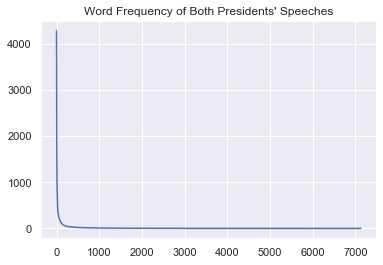

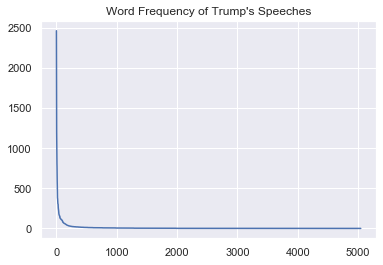

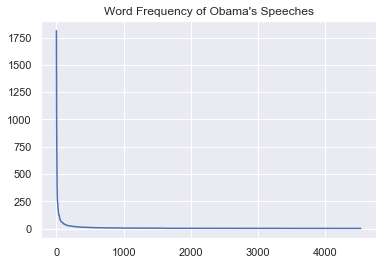

In [48]:
# Plot the word frequencies to verify the Zipf's Law
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(range(len(speech_word_count)), speech_word_count["count"])
plt.title("Word Frequency of Both Presidents' Speeches")
plt.show()

plt.title("Word Frequency of Trump's Speeches")
ax = fig.add_subplot()
plt.plot(range(len(trump_word_count)), trump_word_count["count"])
plt.show()

ax = fig.add_subplot()
plt.title("Word Frequency of Obama's Speeches")
plt.plot(range(len(obama_word_count)), obama_word_count["count"])
plt.show()

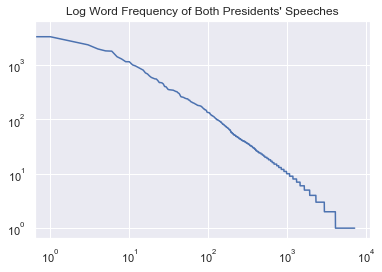

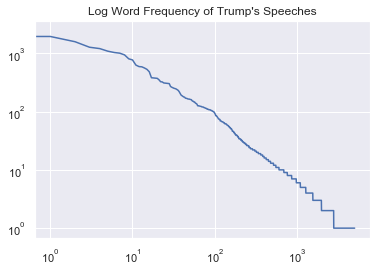

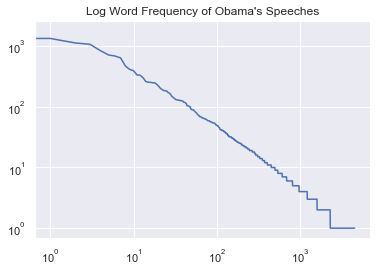

In [49]:
# Plot Zipf's Law with log axis
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(range(len(speech_word_count)), speech_word_count["count"])
plt.title("Log Word Frequency of Both Presidents' Speeches")
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()

fig = plt.figure()
plt.title("Log Word Frequency of Trump's Speeches")
ax = fig.add_subplot()
plt.plot(range(len(trump_word_count)), trump_word_count["count"])
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()

fig = plt.figure()
ax = fig.add_subplot()
plt.title("Log Word Frequency of Obama's Speeches")
plt.plot(range(len(obama_word_count)), obama_word_count["count"])
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()

As shown in the graphs above, the word frequency patterns in both presidents' speeches are consistent with the *Zipf's Law*.

In [50]:
# Use nltk
speech_text = nltk.Text(speech_words_list)
speech_index = nltk.text.ConcordanceIndex(speech_text)

trump_text = nltk.Text(trump_words_list)
trump_index = nltk.text.ConcordanceIndex(trump_text)

obama_text = nltk.Text(obama_words_list)
obama_index = nltk.text.ConcordanceIndex(obama_text)

In [51]:
speech_index.print_concordance("coronavirus")
# trump_index.print_concordance("coronavirus")

Displaying 17 of 17 matches:
 combat and ultimately defeat the coronavirus We ’ve been working very hard on 
rate our capacity to test for the coronavirus We want to make sure that those w
at ’s defeating the spread of the coronavirus And we look forward to working wi
ollection products for testing of coronavirus We ’re ramping up our manufacturi
A for their rapid approval of our coronavirus test We really appreciate the par
nment approach to confronting the coronavirus we ’re bringing an all of America
ou know the truth is that we have coronavirus cases now in 46 American states A
he risk of serious illness of the coronavirus remains low we want to encourage 
 you in contact with him over the coronavirus crisis THE PRESIDENT No we we hav
led Schengen zone that have fewer coronavirus cases than the UK And just in the
ast 24 hours the UK has added 208 coronavirus cases to their total Why do they 
ory disease out there besides the coronavirus And that ’s why the screening is 
picture wit

In [52]:
speech_index.print_concordance("politics")

Displaying 24 of 24 matches:
 Sir you ca n’t go to court This is politics And we were treated unbelievably un
 go into unfortunately he went into politics after that Laughter Remember he sai
od rightfully that this was crooked politics This was crooked politics How about
s crooked politics This was crooked politics How about all these people they ’re
us things about me It ’s okay it ’s politics And then they ’re supposed to vote 
s You know all my life I was n’t in politics but I ’d say if you ’re a politicia
calls me he says You should run for politics I say What do I know about politics
politics I say What do I know about politics But you know what We learned quickl
ot even second guess that ’s called politics Sadly I ’d probably do the same thi
r you said that you were too new to politics earlier in your administration when
out of one But you know I never did politics before Now I do politics I will tel
 never did politics before Now I do politics I will tell you I ’m very disappoin

In [53]:
speech_index.print_concordance("economy")

Displaying 25 of 48 matches:
 We ’re rebuilding the military our economy is thriving like never before You l
what I did by creating such a great economy and if the opposing party got in th
d if the opposing party got in this economy would be down the tubes You know I 
gulations By creating such a strong economy you just look at your televisions o
ded to protect our security and our economy Leaders in Washington imposed on th
romises and liberating the American economy We have created more than 2 million
d off food stamps The United States economy is growing almost twice as fast tod
considered far and away the hottest economy anywhere in the world Unemployment 
ter 24 months of rapid progress our economy is the envy of the world our milita
rong Our country is vibrant and our economy is thriving like never before On Fr
s benefitted more from our thriving economy than women who have filled 58 perce
ould compel China to liberalize its economy and strengthen protections to provi
s drastic c

In [54]:
trump_index.print_concordance("economy")

Displaying 16 of 16 matches:
 We ’re rebuilding the military our economy is thriving like never before You l
what I did by creating such a great economy and if the opposing party got in th
d if the opposing party got in this economy would be down the tubes You know I 
gulations By creating such a strong economy you just look at your televisions o
ded to protect our security and our economy Leaders in Washington imposed on th
romises and liberating the American economy We have created more than 2 million
d off food stamps The United States economy is growing almost twice as fast tod
considered far and away the hottest economy anywhere in the world Unemployment 
ter 24 months of rapid progress our economy is the envy of the world our milita
rong Our country is vibrant and our economy is thriving like never before On Fr
s benefitted more from our thriving economy than women who have filled 58 perce
ould compel China to liberalize its economy and strengthen protections to provi
s drastic c

In [55]:
obama_index.print_concordance("economy")

Displaying 25 of 32 matches:
u will has applied to the region ’s economy as well Yes some nations are blesse
ckets of prosperity But in a global economy based on knowledge based on innovat
ss from the few to the many and the economy generates jobs for the young Americ
kets with each other and the global economy And we ’re going to start with Tuni
e vision of a modern and prosperous economy create a powerful force for reform 
rom Jalalabad to Jakarta The global economy suffered an enormous blow during th
ocus as President than rescuing our economy from potential catastrophe And in a
 is much work to be done The global economy has been pulled back from the brink
 for the rot of a closed or corrupt economy must never eclipse the energy and i
sight into the workings of a global economy Before that she was a prosecutor in
ce and say that we have pulled this economy back from the brink I want to thank
th care represents one sixth of our economy I believe it makes more sense to bu
om all walk

In [56]:
speech_index.print_concordance("culture")

Displaying 15 of 15 matches:
atness Our people have promoted our culture and promoted our values Americans h
ies safer our families stronger our culture richer our faith deeper and our mid
omb Let us work together to build a culture that cherishes innocent life And le
n this hall has a cherished history culture and heritage that is worth defendin
ts history who are nourished by its culture committed to its values attached to
e Lift up your nations Cherish your culture Honor your histories Treasure your 
today is the emissary of a distinct culture a rich history and a people bound t
nd the rule of law And we prize the culture that sustains our liberty a culture
culture that sustains our liberty a culture built on strong families deep faith
must also work together to create a culture in our country that embraces the di
ns So even as we respect the unique culture and traditions of different countri
d new ties of trade and of commerce culture and education that unleash the pote
ry will pur

In [57]:
speech_index.print_concordance("U.S.")

Displaying 13 of 13 matches:
me Not for a long time The UK and the U.S. as you probably have been seeing and 
ng a massive and unfair burden on the U.S. taxpayer and our great U.S. military 
en on the U.S. taxpayer and our great U.S. military They neglected a nuclear men
pect and I respect them in return The U.S. we have taken very unprecedented acti
the largest housecall provider in the U.S. and we go to the homes of the most vu
ities of crude oil for storage in the U.S. Strategic Reserve We ’re going to fil
 of the border between Canada and the U.S. And by extension are you considering 
 It ’s a great business It ’s a great U.S. business frankly And I know how impor
determine its own capital I moved the U.S. Embassy in Israel to Jerusalem The Un
t is why we are taking a hard look at U.S. foreign assistance That will be heade
greements to promote integration with U.S. and European markets and open the doo
 Judge Sotomayor was nominated to the U.S. District Court by a Republican Presid

In [58]:
trump_index.print_concordance("U.S.")

Displaying 10 of 10 matches:
me Not for a long time The UK and the U.S. as you probably have been seeing and 
ng a massive and unfair burden on the U.S. taxpayer and our great U.S. military 
en on the U.S. taxpayer and our great U.S. military They neglected a nuclear men
pect and I respect them in return The U.S. we have taken very unprecedented acti
the largest housecall provider in the U.S. and we go to the homes of the most vu
ities of crude oil for storage in the U.S. Strategic Reserve We ’re going to fil
 of the border between Canada and the U.S. And by extension are you considering 
 It ’s a great business It ’s a great U.S. business frankly And I know how impor
determine its own capital I moved the U.S. Embassy in Israel to Jerusalem The Un
t is why we are taking a hard look at U.S. foreign assistance That will be heade


In [59]:
obama_index.print_concordance("U.S.")

Displaying 3 of 3 matches:
greements to promote integration with U.S. and European markets and open the doo
 Judge Sotomayor was nominated to the U.S. District Court by a Republican Presid
ent six years as a trial judge on the U.S. District Court and would replace Just


In [60]:
speech_index.print_concordance("people")

Displaying 25 of 460 matches:
would have been able to take it Some people said no they would n’t have But I ca
caught him in the act Dirty cops Bad people If this happened to President Obama 
happened to President Obama a lot of people would have been in jail for a long t
e up so much in the last few days is people think we ’re doing so well They like
 of the Union speech I was with some people that have been around they ’ve been 
f the United States the power of the people in this room Really an amazing I do 
 to start by introducing some of the people that are here I know some are going 
So I appreciate that But some of the people here have been incredible warriors T
 later after lives were ruined after people went bankrupt after people lost all 
ned after people went bankrupt after people lost all their money People came to 
ple came to Washington to help other people Bright eyed and bushy tailed I say T
 I say They came one or two or three people in particular but many people We ha

In [61]:
trump_index.print_concordance("people")

Displaying 25 of 301 matches:
would have been able to take it Some people said no they would n’t have But I ca
caught him in the act Dirty cops Bad people If this happened to President Obama 
happened to President Obama a lot of people would have been in jail for a long t
e up so much in the last few days is people think we ’re doing so well They like
 of the Union speech I was with some people that have been around they ’ve been 
f the United States the power of the people in this room Really an amazing I do 
 to start by introducing some of the people that are here I know some are going 
So I appreciate that But some of the people here have been incredible warriors T
 later after lives were ruined after people went bankrupt after people lost all 
ned after people went bankrupt after people lost all their money People came to 
ple came to Washington to help other people Bright eyed and bushy tailed I say T
 I say They came one or two or three people in particular but many people We ha

In [62]:
obama_index.print_concordance("people")

Displaying 25 of 159 matches:
 the face of threats to the American people For make no mistake Evil does exist 
tional laws by brutalizing their own people When there is genocide in Darfur sys
ts fear the aspirations of their own people more than the power of any other nat
it is the responsibility of all free people and free nations to make clear that 
s why helping farmers feed their own people or nations educate their children an
it perhaps comes as no surprise that people fear the loss of what they cherish i
 town by town country by country the people have risen up to demand their basic 
ance as the overwhelming majority of people saw that the slaughter of innocents 
 of the region as a dead end and the people of the Middle East and North Africa 
ong ago but in too many places their people did not In too many countries power 
what comes out of the ground Nor can people reach their potential when you can n
 in the region tried to direct their people ’s grievances elsewhere The West wa

In [63]:
trump_text.common_contexts(["U.S."])

the_as the_taxpayer great_military the_we the_and the_strategic
great_business the_embassy at_foreign


In [64]:
obama_text.common_contexts(["U.S."])

with_and the_district


In [65]:
trump_text.common_contexts(["people"])

some_said bad_if of_would is_think some_that the_in the_that the_here
after_went after_lost money_came other_bright three_in many_we
evil_with of_were rich_i president_do want_to but_have


In [66]:
obama_text.common_contexts(["people"])

american_for own_when own_more free_and own_or that_fear the_have
of_saw the_of their_did can_reach their_’s young_to
communication_expect to_’s believe_everywhere ordinary_will put_into
the_themselves ordinary_throughout


- There is yet not much appearance of **coronavirus** in the subset of the presidential speech corpus since Donald Trump only addressed twice about the recent topic.

- I performed a preliminary examination on the frequency of **economy** in both presidents'  speeches to see how the word is used. Apart from "our economy", it is obvious to see Trump prefers to describe the U.S. economy with superlative words while Obama emphasized more on the  "global" economy.

- A similar pattern exists in the appearance of **people**. In contrast to Trump's "great" "American" people, Obama used "Iraqi" and "Afghan" people more frequently during wartime.

In [67]:
speech_index.print_concordance("immigration")

Displaying 17 of 17 matches:
executive action as it related to immigration you said The whole concept of exe
one And I would like to see major immigration reform and maybe that ’s somethin
 we all get together and do major immigration reform not just for a wall for a 
t the ports of entry that illegal immigration is down and the violence is down 
y that we lose because of illegal immigration Billions and billions of dollars 
hington imposed on the country an immigration policy that Americans never voted
d prescription drugs to create an immigration system that is safe lawful modern
ca is committed to ending illegal immigration and putting the ruthless coyotes 
We have a moral duty to create an immigration system that protects the lives an
a ’s political class than illegal immigration Wealthy politicians and donors pu
 safety net Tolerance for illegal immigration is not compassionate it is cruel 
st critical challenges is illegal immigration which undermines prosperity rips 
ction to st

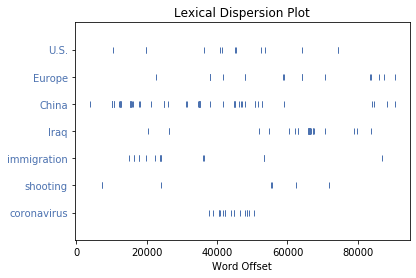

In [68]:
# Plot each time a set of given words occurs
# Here I only plot the frequency in the whole subset of corpus
# Withous separating the speeches of Trump and that of Obama
sns.reset_orig()
given_words = ["U.S.", "Europe", "China", "Iraq", "immigration", "shooting", "coronavirus"]
speech_text.dispersion_plot(given_words)
sns.set()

The picture above suggests different issues each president dealt with, for example, Trump focused more on **immigration** than Obama; whereas it seems **China** has always been high on agenda.

# Filtering and normalizing text

As we want to start comparing the different releases we may choose to do a bit of filtering and normalizing that will allow us to focus on what we most care about. We can first make all of the words lower case, then drop the non-word tokens. Next, we can remove some **'stop words'**, stem the remaining words to remove suffixes, prefixes and (in some languages) infixes, or lemmatize tokens by intelligently grouping inflected or variant forms of the same word (e.g., with a stemmer and a dictionary). 

To begin this process, we will first define a function to work over the tokenized lists, then another to add normalized tokens to a new column.

We will be using spaCy's built in stop words identifying capacity. When we run text through spaCy's language pipeline, it automatically tags it as a stop word. 

We can remove these stopwords from the analysis by fiat, but we could also take a more principled approach by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection. Alternatively, we could automatically set a cut-off by rule, such as removal of all words more frequent than the most frequent verb, or the most frequent noun (not pronoun), or some term of central interest. 

In [69]:
whReleases['tokenized_text']

0    [SEN, WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S, ...
1    [SEN, WHITEHOUSE, SAYS, PRESIDENT, BUSH, MUST,...
2    [EPA, MUST, REVIEW, LEGAL, PROCESS, TO, ROOT, ...
3    [R.I., SENATORS, PRAISE, SEN, DENIAL, OF, LNG,...
4    [SEN, WHITEHOUSE, COMMENTS, ON, ONE, YEAR, ANN...
5    [SENS, REED, WHITEHOUSE, WELCOME, RHODE, ISLAN...
6    [REP, WHITEHOUSE, ISSUES, STATEMENT, ON, GEN, ...
7    [SEN, WHITEHOUSE, URGES, BUSH, FOR, NEW, DIREC...
8    [SENS, REED, WHITEHOUSE, URGE, PORTUGAL, TO, R...
9    [WHITEHOUSE, UNVEILS, BUSH, DEBT, $, 7.7, TRIL...
Name: tokenized_text, dtype: object

In [70]:
countsDict = {}
for word in whReleases['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key=lambda x : x[1], reverse=True)
word_counts[:20]

[('the', 179),
 ('of', 112),
 ('to', 112),
 ('and', 108),
 ('in', 64),
 ('a', 61),
 ("'s", 50),
 ('that', 41),
 ('our', 39),
 ('for', 35),
 ('on', 33),
 ('is', 33),
 ('Whitehouse', 31),
 ('Iraq', 28),
 ('Bush', 27),
 ('President', 25),
 ('troops', 21),
 ('by', 19),
 ('American', 19),
 ('with', 18)]

What are we doing here? We want to get the list of all words in the corpus, and then count how many times each word is used. "whReleases['tokenized_text'].sum()" does the the former; and the rest of the codes in the loop does the latter. And then we use sorted function to sort the words in a descending order, i.e., arranged from the largest to the smallest number.

We can look at this and pick the cutoff, often at the first noun. So we will cut all words before `'Whitehouse'`.

In [71]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Whitehouse':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['the', 'of', 'to', 'and', 'in', 'a', "'s", 'that', 'our', 'for', 'on', 'is']

We're already familiar with for and if statements. But what does the break statement do here? Let's go back to what we are up to: We are trying to find words that occur more frequently than Whitehouse, which is the cutoff word that we're using here. So, using "break", we stopped when we see "Whitehouse"; then, we appended the words that appeared before "Whitehouse", i.e., the words that occurred more frequently than Whitehouse. As you can see, what the break statement does is: it stops the execution of the loop and moves on to the next line of code. 

If we did have any extra words to add as stop words apart from those normally considered as stop words, we would add it to our stop words by passing it to the normalize tokens method. 

Now we can create our function to normalize the tokens

In [72]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [73]:
whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))

whReleases

name  \
0  10Apr2007Whitehouse123.txt   
1    10Apr2008Whitehouse2.txt   
2    10Apr2008Whitehouse3.txt   
3   10Aug2007Whitehouse78.txt   
4   10Jan2008Whitehouse35.txt   
5    10Mar2008Whitehouse8.txt   
6   10Sep2007Whitehouse72.txt   
7  11Apr2007Whitehouse122.txt   
8  11Jan2007Whitehouse161.txt   
9    11Mar2008Whitehouse7.txt   

                                                text  \
0  SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...   
1  SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...   
2  EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...   
3  R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...   
4  SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...   
5  SENS. REED, WHITEHOUSE WELCOME RHODE ISLAND ST...   
6  REP. WHITEHOUSE ISSUES STATEMENT ON GEN. PETRA...   
7  SEN. WHITEHOUSE URGES BUSH FOR NEW DIRECTION I...   
8  SENS. REED, WHITEHOUSE URGE PORTUGAL TO RECONS...   
9  WHITEHOUSE UNVEILS 'BUSH DEBT': $7.7 TRILLION ...   

                                        path  \
0  raw/Whitehouse/10Apr2007Whitehouse123.txt   
1    raw/Whitehouse/10Apr2008Whitehouse2.txt   
2    raw/Whitehouse/10Apr2008Whitehouse3.txt   
3   raw/Whitehouse/10Aug2007Whitehouse78.txt   
4   raw/Whitehouse/10Jan2008Whitehouse35.txt   
5    raw/Whitehouse/10Mar2008Whitehouse8.txt   
6   raw/Whitehouse/10Sep2007Whitehouse72.txt   
7  raw/Whitehouse/11Apr2007Whitehouse122.txt   
8  raw/Whitehouse/11Jan2007Whitehouse161.txt   
9    raw/Whitehouse/11Mar2008Whitehouse7.txt   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   
5  https://github.com/lintool/GrimmerSenatePressR...   
6  https://github.com/lintool/GrimmerSenatePressR...   
7  https://github.com/lintool/GrimmerSenatePressR...   
8  https://github.com/lintool/GrimmerSenatePressR...   
9  https://github.com/lintool/GrimmerSenatePressR...   

                                        download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   
3  https://raw.githubusercontent.com/lintool/Grim...   
4  https://raw.githubusercontent.com/lintool/Grim...   
5  https://raw.githubusercontent.com/lintool/Grim...   
6  https://raw.githubusercontent.com/lintool/Grim...   
7  https://raw.githubusercontent.com/lintool/Grim...   
8  https://raw.githubusercontent.com/lintool/Grim...   
9  https://raw.githubusercontent.com/lintool/Grim...   

                                      tokenized_text  word_counts  \
0  [SEN, WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S, ...          350   
1  [SEN, WHITEHOUSE, SAYS, PRESIDENT, BUSH, MUST,...          311   
2  [EPA, MUST, REVIEW, LEGAL, PROCESS, TO, ROOT, ...          497   
3  [R.I., SENATORS, PRAISE, SEN, DENIAL, OF, LNG,...          189   
4  [SEN, WHITEHOUSE, COMMENTS, ON, ONE, YEAR, ANN...          236   
5  [SENS, REED, WHITEHOUSE, WELCOME, RHODE, ISLAN...          334   
6  [REP, WHITEHOUSE, ISSUES, STATEMENT, ON, GEN, ...          241   
7  [SEN, WHITEHOUSE, URGES, BUSH, FOR, NEW, DIREC...          469   
8  [SENS, REED, WHITEHOUSE, URGE, PORTUGAL, TO, R...          443   
9  [WHITEHOUSE, UNVEILS, BUSH, DEBT, $, 7.7, TRIL...          425   

                                   normalized_tokens  normalized_tokens_count  
0  [sen, whitehouse, share, westerly, girl, story...                      224  
1  [sen, whitehouse, say, president, bush, begin,...                      159  
2  [epa, review, legal, process, root, political,...                      298  
3  [r.i, senator, praise, sen, denial, lng, facil...                      116  
4  [sen, whitehouse, comment, year, anniversary, ...                      125  
5  [sens, reed, whitehouse, welcome, rhod

In [74]:
whReleases['normalized_tokens']

0    [sen, whitehouse, share, westerly, girl, story...
1    [sen, whitehouse, say, president, bush, begin,...
2    [epa, review, legal, process, root, political,...
3    [r.i, senator, praise, sen, denial, lng, facil...
4    [sen, whitehouse, comment, year, anniversary, ...
5    [sens, reed, whitehouse, welcome, rhode, islan...
6    [rep, whitehouse, issue, statement, gen, petra...
7    [sen, whitehouse, urge, bush, new, direction, ...
8    [sens, reed, whitehouse, urge, portugal, recon...
9    [whitehouse, unveil, bush, debt, $, foregone, ...
Name: normalized_tokens, dtype: object

In [75]:
# counter = lambda x: len(x)
# counter("sdfjasd sd23")

You can see that in the final step of normalizing, we add the lemmatized form of the word. spaCy's built in lemmatizer does this (https://spacy.io/api/lemmatizer). **Lemmatization can be thought of as finding the root or the base of the word after removing inflections and other variations of words.Another possible way of finding the roots of words is using *NLTK's porting or stemming functionalities*, but we will not be getting into them.**

Now that it is cleaned we start analyzing the dataset. We can start by finding frequency distributions for the dataset. Lets start looking at all the press releases together. The [`ConditionalFreqDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) class reads in an iterable of tuples, the first element is the condition and the second the focal word. For starters, we will use word lengths as the conditions, but tags or clusters will provide more useful results.

In [76]:
#.sum() adds together the lists from each row into a single list
# whcfdist = Whitehouse Conditional Frequency Distribution
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))

#print the number of words
print(whcfdist.N())

1966


In [77]:
# help(whcfdist)

From this we can lookup the distributions of different word lengths

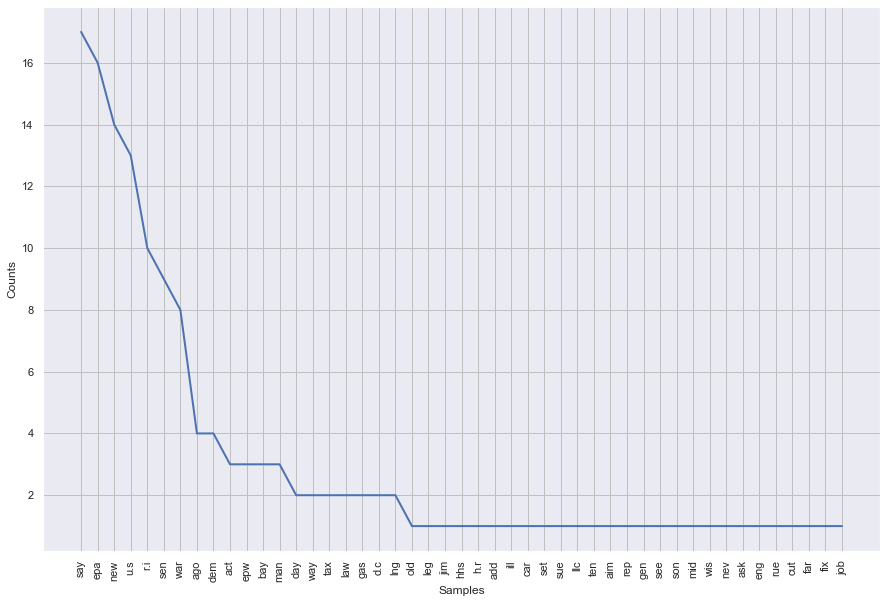

In [78]:
plt.figure(figsize=(15, 10))
whcfdist[3].plot();

We can also create a **Conditional Probability Distribution** or [`ConditionalProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) from the `ConditionalFreqDist`. To do this, however, we need a model for the probability distribution. A simple model is [`ELEProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ELEProbDist) which gives **the expected likelihood estimate for the probability distribution** of the experiment used to generate the observed frequency distribution. 

In [79]:
# whcpdist = Whitehouse Conditional Probability Distribution
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(whcpdist[2].max())

#And its probability
print(whcpdist[2].prob(whcpdist[2].max()))

ri
0.25


Length is one feature of a word, but there are many more important features we care about. Another critical feature is **a word's role in the sentence**, or its **part of speech (POS)**. 

The method below works similarly to ```nltk.pos_text```, and can work with the conditional frequency distributions it provides.

In [80]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [81]:
whReleases['normalized_tokens_POS'] = [spacy_pos(t) for t in whReleases['text']]

This gives us a new column with the part of speech as a short initialism and the word in a tuple, exactly how the `nltk.ConditionalFreqDist()` function wants them. We can now construct another conditional frequency distribution.

In [82]:
whcfdist_WordtoPOS = nltk.ConditionalFreqDist(whReleases['normalized_tokens_POS'].sum())
list(whcfdist_WordtoPOS.items())[:10]

[('sen', FreqDist({'NNP': 9})),
 ('.', FreqDist({'.': 132, 'NNP': 34})),
 ('whitehouse', FreqDist({'NNP': 17, 'VB': 14, 'NN': 4, 'RB': 4, 'WDT': 1})),
 ('shares', FreqDist({'VBZ': 1})),
 ('westerly', FreqDist({'RB': 2})),
 ('girl', FreqDist({'NN': 2})),
 ("'s", FreqDist({'POS': 47, 'VBZ': 5})),
 ('story', FreqDist({'NN': 2})),
 ('in', FreqDist({'IN': 72})),
 ('push', FreqDist({'NN': 1}))]

This gives **the frequency of each word as each part of speech**...which can be uninformative and boring. What we want is the converse; the frequency of each part of speech for each word.

In [83]:
whcfdist_POStoWord = \
nltk.ConditionalFreqDist((p, w) for w, p in whReleases['normalized_tokens_POS'].sum())

We can now identify and collect all of **the superlative adjectives**

In [84]:
whcfdist_POStoWord['JJ']

FreqDist({'american': 17, 'new': 10, 'portuguese': 9, 'political': 8, 'federal': 6, 'clear': 5, 'potential': 5, 'fiscal': 5, 'last': 4, 'several': 4, ...})

Or look at **the most common nouns**

In [85]:
whcfdist_POStoWord['NN'].most_common(5)

[('today', 15),
 ('year', 12),
 ('administration', 11),
 ('stem', 10),
 ('consulate', 10)]

Or plot **the base form verbs** against their number of occurrences

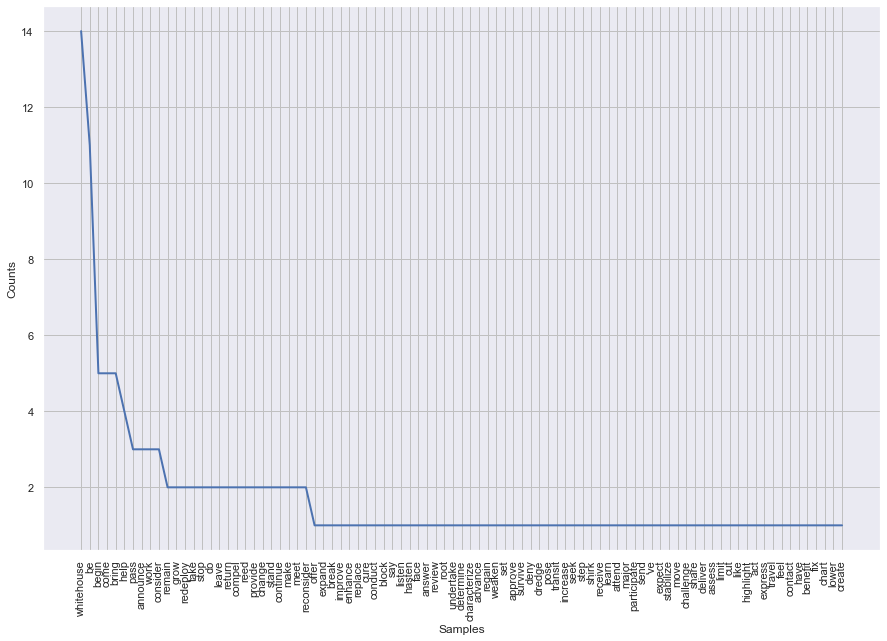

In [86]:
plt.figure(figsize=(15, 10))
whcfdist_POStoWord['VB'].plot();

We can then do a similar analysis of the word probabilities

In [87]:
whcpdist_POStoWord = nltk.ConditionalProbDist(whcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(whcpdist_POStoWord['NN'].max())

#And its probability
print(whcpdist_POStoWord['NN'].prob(whcpdist_POStoWord['NN'].max()))

today
0.020195439739413682


We can even create a...wait for it...*WORD CLOUD* or Wordl to gaze at and draw mystical, approximate inferences about important nouns and verbs in our corpus:

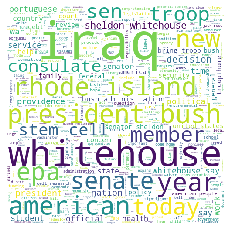

In [88]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width=1000, height=1000, mode='RGBA', scale=.5).generate(' '.join(whReleases['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("whitehouse_word_cloud.pdf", format='pdf')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</span>

In [89]:
# Define a function that finds the non-stop words by setting a cut-off
def find_frequency(series):
    count_dict = {}
    for word in series.sum():
        if word in count_dict:
            count_dict[word] += 1
        else:
            count_dict[word] = 1
    word_counts = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)
    return word_counts

In [90]:
speech_counts = find_frequency(speech["tokens"])
trump_counts = find_frequency(speech["tokens"])
obama_counts = find_frequency(speech["tokens"])

In [91]:
speech_counts[:150]

[('the', 3850),
 ('to', 2621),
 ('and', 2478),
 ('of', 2323),
 ('a', 1733),
 ('that', 1636),
 ('we', 1398),
 ('I', 1280),
 ('in', 1275),
 ('you', 964),
 ('is', 941),
 ('our', 928),
 ('it', 885),
 ('have', 845),
 ('for', 826),
 ('And', 805),
 ('’s', 800),
 ('are', 619),
 ('will', 585),
 ('this', 576),
 ('We', 560),
 ('be', 553),
 ('with', 546),
 ('they', 499),
 ('not', 490),
 ('on', 461),
 ('people', 460),
 ('do', 419),
 ('was', 398),
 ('’re', 398),
 ('as', 397),
 ('all', 358),
 ('can', 345),
 ('n’t', 344),
 ('who', 335),
 ('their', 334),
 ('But', 331),
 ('by', 316),
 ('very', 314),
 ('Applause', 313),
 ('from', 300),
 ('has', 294),
 ('The', 264),
 ('been', 260),
 ('what', 259),
 ('us', 255),
 ('It', 255),
 ('one', 255),
 ('know', 251),
 ('or', 250),
 ('an', 233),
 ('at', 230),
 ('more', 228),
 ('up', 227),
 ('just', 223),
 ('but', 218),
 ('They', 212),
 ('country', 211),
 ('world', 209),
 ('he', 206),
 ('going', 201),
 ('want', 199),
 ('them', 198),
 ('America', 195),
 ('those', 192),


In [92]:
trump_counts[:150]

[('the', 3850),
 ('to', 2621),
 ('and', 2478),
 ('of', 2323),
 ('a', 1733),
 ('that', 1636),
 ('we', 1398),
 ('I', 1280),
 ('in', 1275),
 ('you', 964),
 ('is', 941),
 ('our', 928),
 ('it', 885),
 ('have', 845),
 ('for', 826),
 ('And', 805),
 ('’s', 800),
 ('are', 619),
 ('will', 585),
 ('this', 576),
 ('We', 560),
 ('be', 553),
 ('with', 546),
 ('they', 499),
 ('not', 490),
 ('on', 461),
 ('people', 460),
 ('do', 419),
 ('was', 398),
 ('’re', 398),
 ('as', 397),
 ('all', 358),
 ('can', 345),
 ('n’t', 344),
 ('who', 335),
 ('their', 334),
 ('But', 331),
 ('by', 316),
 ('very', 314),
 ('Applause', 313),
 ('from', 300),
 ('has', 294),
 ('The', 264),
 ('been', 260),
 ('what', 259),
 ('us', 255),
 ('It', 255),
 ('one', 255),
 ('know', 251),
 ('or', 250),
 ('an', 233),
 ('at', 230),
 ('more', 228),
 ('up', 227),
 ('just', 223),
 ('but', 218),
 ('They', 212),
 ('country', 211),
 ('world', 209),
 ('he', 206),
 ('going', 201),
 ('want', 199),
 ('them', 198),
 ('America', 195),
 ('those', 192),


In [93]:
obama_counts[:150]

[('the', 3850),
 ('to', 2621),
 ('and', 2478),
 ('of', 2323),
 ('a', 1733),
 ('that', 1636),
 ('we', 1398),
 ('I', 1280),
 ('in', 1275),
 ('you', 964),
 ('is', 941),
 ('our', 928),
 ('it', 885),
 ('have', 845),
 ('for', 826),
 ('And', 805),
 ('’s', 800),
 ('are', 619),
 ('will', 585),
 ('this', 576),
 ('We', 560),
 ('be', 553),
 ('with', 546),
 ('they', 499),
 ('not', 490),
 ('on', 461),
 ('people', 460),
 ('do', 419),
 ('was', 398),
 ('’re', 398),
 ('as', 397),
 ('all', 358),
 ('can', 345),
 ('n’t', 344),
 ('who', 335),
 ('their', 334),
 ('But', 331),
 ('by', 316),
 ('very', 314),
 ('Applause', 313),
 ('from', 300),
 ('has', 294),
 ('The', 264),
 ('been', 260),
 ('what', 259),
 ('us', 255),
 ('It', 255),
 ('one', 255),
 ('know', 251),
 ('or', 250),
 ('an', 233),
 ('at', 230),
 ('more', 228),
 ('up', 227),
 ('just', 223),
 ('but', 218),
 ('They', 212),
 ('country', 211),
 ('world', 209),
 ('he', 206),
 ('going', 201),
 ('want', 199),
 ('them', 198),
 ('America', 195),
 ('those', 192),


Even though the first non-stop word in the three subsets is **people**, the words following "people" are still composed of stop words that are not relevant to our interest. Hence, I manually set several threholds to extract stop words.

In [94]:
# Define a function that extract stop words from the top-n words
def get_stop_words(word_counts, words, n):
    stop_words_freq = []
    for w, c in word_counts[:n]:
        if w in words:
            continue
        else:
            stop_words_freq.append(w)
    return stop_words_freq   

In [95]:
non_stops = ["people", "America", "American", "world", "country", 
            "know", "Americans", "years", "work", "jobs", "nation", 
            "energy", "United", "States", "great", "better", "believe",
            "year", "future", "economy", "Congress", "Iraq", "home",
            "security", "nations", "government", "say", "business", 
            "President", "support"]
speech_stop = get_stop_words(speech_counts, non_stops, 150)
trump_stop = get_stop_words(trump_counts, non_stops, 150)
obama_stop = get_stop_words(obama_counts, non_stops, 150)

In [96]:
speech_stop

['the',
 'to',
 'and',
 'of',
 'a',
 'that',
 'we',
 'I',
 'in',
 'you',
 'is',
 'our',
 'it',
 'have',
 'for',
 'And',
 '’s',
 'are',
 'will',
 'this',
 'We',
 'be',
 'with',
 'they',
 'not',
 'on',
 'do',
 'was',
 '’re',
 'as',
 'all',
 'can',
 'n’t',
 'who',
 'their',
 'But',
 'by',
 'very',
 'Applause',
 'from',
 'has',
 'The',
 'been',
 'what',
 'us',
 'It',
 'one',
 'or',
 'an',
 'at',
 'more',
 'up',
 'just',
 'but',
 'They',
 'he',
 'going',
 'want',
 'them',
 'those',
 'Thank',
 'said',
 '’ve',
 'so',
 'there',
 'about',
 'if',
 'You',
 'when',
 'time',
 'would',
 'because',
 'like',
 'must',
 'than',
 'here',
 'So',
 'these',
 'THE',
 'PRESIDENT',
 'right',
 'out',
 'your',
 'many',
 'did',
 'had',
 'now',
 'other',
 'were',
 'new',
 'That',
 'also',
 'much',
 'make',
 'some',
 'no',
 'In',
 'get',
 'me',
 'should',
 'think',
 'my',
 'every',
 'over',
 'never',
 'where',
 '’ll',
 'good',
 'Q',
 'its',
 'way',
 'her',
 'lot',
 'today',
 'only',
 'This',
 "'s",
 'He',
 'own',
 

In [97]:
trump_stop

['the',
 'to',
 'and',
 'of',
 'a',
 'that',
 'we',
 'I',
 'in',
 'you',
 'is',
 'our',
 'it',
 'have',
 'for',
 'And',
 '’s',
 'are',
 'will',
 'this',
 'We',
 'be',
 'with',
 'they',
 'not',
 'on',
 'do',
 'was',
 '’re',
 'as',
 'all',
 'can',
 'n’t',
 'who',
 'their',
 'But',
 'by',
 'very',
 'Applause',
 'from',
 'has',
 'The',
 'been',
 'what',
 'us',
 'It',
 'one',
 'or',
 'an',
 'at',
 'more',
 'up',
 'just',
 'but',
 'They',
 'he',
 'going',
 'want',
 'them',
 'those',
 'Thank',
 'said',
 '’ve',
 'so',
 'there',
 'about',
 'if',
 'You',
 'when',
 'time',
 'would',
 'because',
 'like',
 'must',
 'than',
 'here',
 'So',
 'these',
 'THE',
 'PRESIDENT',
 'right',
 'out',
 'your',
 'many',
 'did',
 'had',
 'now',
 'other',
 'were',
 'new',
 'That',
 'also',
 'much',
 'make',
 'some',
 'no',
 'In',
 'get',
 'me',
 'should',
 'think',
 'my',
 'every',
 'over',
 'never',
 'where',
 '’ll',
 'good',
 'Q',
 'its',
 'way',
 'her',
 'lot',
 'today',
 'only',
 'This',
 "'s",
 'He',
 'own',
 

In [98]:
obama_stop

['the',
 'to',
 'and',
 'of',
 'a',
 'that',
 'we',
 'I',
 'in',
 'you',
 'is',
 'our',
 'it',
 'have',
 'for',
 'And',
 '’s',
 'are',
 'will',
 'this',
 'We',
 'be',
 'with',
 'they',
 'not',
 'on',
 'do',
 'was',
 '’re',
 'as',
 'all',
 'can',
 'n’t',
 'who',
 'their',
 'But',
 'by',
 'very',
 'Applause',
 'from',
 'has',
 'The',
 'been',
 'what',
 'us',
 'It',
 'one',
 'or',
 'an',
 'at',
 'more',
 'up',
 'just',
 'but',
 'They',
 'he',
 'going',
 'want',
 'them',
 'those',
 'Thank',
 'said',
 '’ve',
 'so',
 'there',
 'about',
 'if',
 'You',
 'when',
 'time',
 'would',
 'because',
 'like',
 'must',
 'than',
 'here',
 'So',
 'these',
 'THE',
 'PRESIDENT',
 'right',
 'out',
 'your',
 'many',
 'did',
 'had',
 'now',
 'other',
 'were',
 'new',
 'That',
 'also',
 'much',
 'make',
 'some',
 'no',
 'In',
 'get',
 'me',
 'should',
 'think',
 'my',
 'every',
 'over',
 'never',
 'where',
 '’ll',
 'good',
 'Q',
 'its',
 'way',
 'her',
 'lot',
 'today',
 'only',
 'This',
 "'s",
 'He',
 'own',
 

In [99]:
# Define a function that normalize the tokens
def normalize_tokens(word_list, extra_stop=[]):
    normalized = []
    if isinstance(word_list, list) and len(word_list) == 1:
        word_list = word_list[0]
    if isinstance(word_list, list):
        word_list = " ".join([str(elem) for elem in word_list])
    
    doc = nlp(word_list.lower())
    
    # Add the property of stop word to words that are considered as stop words
    if len(extra_stop) > 0:
        for stop_word in extra_stop:
            lexeme = nlp.vocab[stop_word]
            lexeme.is_stop = True
    
    for w in doc:
        if w.text != "\n" and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            normalized.append(str(w.lemma_))
    
    return normalized

In [100]:
# Generate new columns in df to apply `normalize_tokens` and store normalized words
speech["normalized_tokens"] = speech["tokens"].apply(lambda x: normalize_tokens(x, extra_stop=["Applause", "applause"]))
speech["normalized_tokens_count"] = speech["normalized_tokens"].apply(lambda x: len(x))

trump["normalized_tokens"] = trump["tokens"].apply(lambda x: normalize_tokens(x, extra_stop=["Applause", "applause"]))
trump["normalized_tokens_count"] = trump["normalized_tokens"].apply(lambda x: len(x))

obama["normalized_tokens"] = obama["tokens"].apply(lambda x: normalize_tokens(x, extra_stop=["Applause", "applause"]))
obama["normalized_tokens_count"] = obama["normalized_tokens"].apply(lambda x: len(x))

In [101]:
speech.head(3)

link  \
0  https://millercenter.org/the-presidency/presid...   
1  https://millercenter.org/the-presidency/presid...   
2  https://millercenter.org/the-presidency/presid...   

                                               title               date  \
0   February 6, 2020: Remarks after HIs Acquittal \n  February 06, 2020   
1  February 15, 2019: Speech Declaring a National...  February 15, 2019   
2  December 18, 2017: Remarks on National Securit...  December 18, 2017   

           name           source  \
0  Donald Trump  The White House   
1  Donald Trump  The White House   
2  Donald Trump  The White House   

                                              script  \
0  \nTranscript\nWell, thank you very much. (Appl...   
1  \nTranscript\nTHE PRESIDENT:  Thank you very m...   
2  \nTranscript\nTHE PRESIDENT: Thank you very mu...   

                                              tokens  \
0  [Well, thank, you, very, much, Applause, Thank...   
1  [THE, PRESIDENT, Thank, you, very, much, every...   
2  [THE, PRESIDENT, Thank, you, very, much, Thank...   

                                   normalized_tokens  normalized_tokens_count  
0  [thank, thank, thank, wow, thank, everybody, w...                     3574  
1  [president, thank, everybody, begin, like, lar...                     3310  
2  [president, thank, thank, want, thank, vice, p...                     1428

In [102]:
trump.head(3)

link  \
2   https://millercenter.org/the-presidency/presid...   
10  https://millercenter.org/the-presidency/presid...   
21  https://millercenter.org/the-presidency/presid...   

                                                title               date  \
2    February 6, 2020: Remarks after HIs Acquittal \n  February 06, 2020   
10  February 15, 2019: Speech Declaring a National...  February 15, 2019   
21  December 18, 2017: Remarks on National Securit...  December 18, 2017   

            name           source  \
2   Donald Trump  The White House   
10  Donald Trump  The White House   
21  Donald Trump  The White House   

                                               script  \
2   \nTranscript\nWell, thank you very much. (Appl...   
10  \nTranscript\nTHE PRESIDENT:  Thank you very m...   
21  \nTranscript\nTHE PRESIDENT: Thank you very mu...   

                                               tokens  \
2   [Well, thank, you, very, much, Applause, Thank...   
10  [THE, PRESIDENT, Thank, you, very, much, every...   
21  [THE, PRESIDENT, Thank, you, very, much, Thank...   

                                    normalized_tokens  normalized_tokens_count  
2   [thank, thank, thank, wow, thank, everybody, w...                     3574  
10  [president, thank, everybody, begin, like, lar...                     3310  
21  [president, thank, thank, want, thank, vice, p...                     1428

In [103]:
obama.head(3)

link  \
66  https://millercenter.org/the-presidency/presid...   
53  https://millercenter.org/the-presidency/presid...   
49  https://millercenter.org/the-presidency/presid...   

                                                title               date  \
66  December 10, 2009: Acceptance of Nobel Peace P...  December 10, 2009   
53  May 19, 2011: Speech on American Diplomacy in ...       May 19, 2011   
49  October 21, 2011: Remarks on the End of the Wa...   October 21, 2011   

            name           source  \
66  Barack Obama  The White House   
53  Barack Obama              NaN   
49  Barack Obama              NaN   

                                               script  \
66  \nTranscript\nYour Majesties, Your Royal Highn...   
53  \nTranscript\nThank you.  Thank you.  (Applaus...   
49  \nTranscript\nGood afternoon, everybody.  As a...   

                                               tokens  \
66  [Your, Majesties, Your, Royal, Highnesses, dis...   
53  [Thank, you, Thank, you, Applause, Thank, you,...   
49  [Good, afternoon, everybody, As, a, candidate,...   

                                    normalized_tokens  normalized_tokens_count  
66  [majesty, royal, highness, distinguish, member...                     1883  
53  [thank, thank, thank, thank, seat, thank, want...                     2606  
49  [good, afternoon, everybody, candidate, presid...                      439

In [104]:
# Calculate the conditional frequency distributions
speech_cf_dist = nltk.ConditionalFreqDist(((len(w), w) for w in speech["normalized_tokens"].sum()))
trump_cf_dist = nltk.ConditionalFreqDist(((len(w), w) for w in trump["normalized_tokens"].sum()))
obama_cf_dist = nltk.ConditionalFreqDist(((len(w), w) for w in obama["normalized_tokens"].sum()))

# Print the number of words respectively
print("Number of Words in subset speech: ", speech_cf_dist.N())
print("Number of Words in Trump's speech: ", trump_cf_dist.N())
print("Number of Words in Obama's speech: ", obama_cf_dist.N())

Number of Words in subset speech:  38104
Number of Words in Trump's speech:  22723
Number of Words in Obama's speech:  15381


Plot the distribution of words of different lengths in three datasets separately.

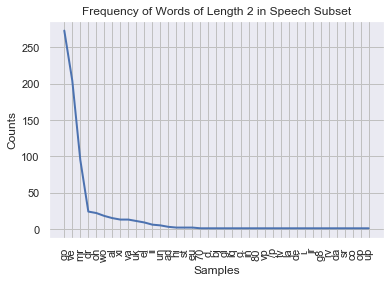

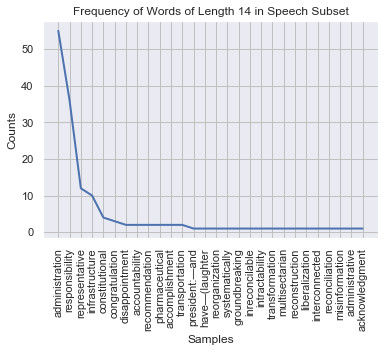

In [105]:
# The distribution of different word lengths in `speech`
speech_cf_dist[2].plot(title="Frequency of Words of Length 2 in Speech Subset")
speech_cf_dist[14].plot(title="Frequency of Words of Length 14 in Speech Subset");

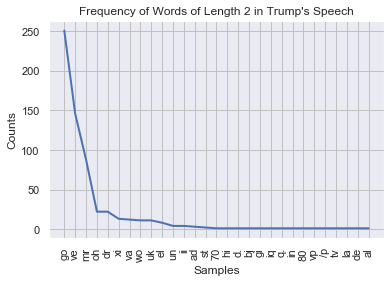

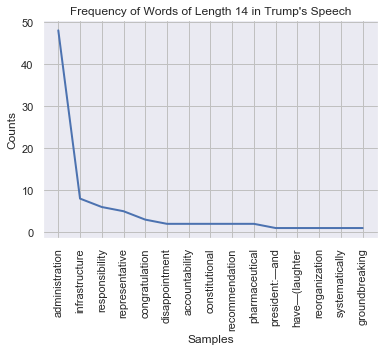

In [106]:
# The distribution of different word lengths in `trump`
trump_cf_dist[2].plot(title="Frequency of Words of Length 2 in Trump's Speech")
trump_cf_dist[14].plot(title="Frequency of Words of Length 14 in Trump's Speech");

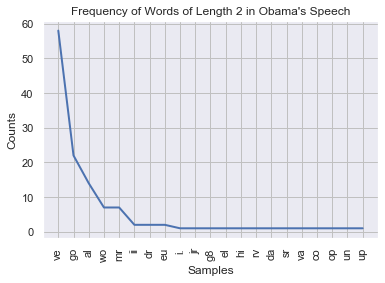

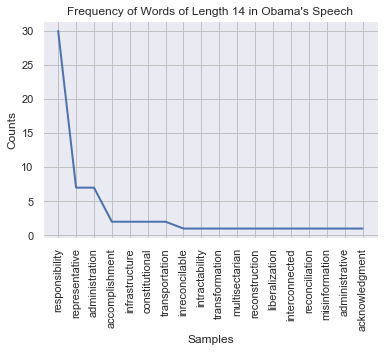

In [107]:
# The distribution of different word lengths in `obama`
obama_cf_dist[2].plot(title="Frequency of Words of Length 2 in Obama's Speech")
obama_cf_dist[14].plot(title="Frequency of Words of Length 14 in Obama's Speech");

In [108]:
# Define a function to calculate the conditional probability distribution based on frequency
def cal_con_prob_dist(con_dist, letter_num):
    con_prob_dist = nltk.ConditionalProbDist(con_dist, nltk.ELEProbDist)
    most_common = con_prob_dist[letter_num].max()
    density = con_prob_dist[letter_num].prob(most_common)
    
    print("The most common {}-letter word is {} with density {}.".format(letter_num, most_common, density))    

In [109]:
# The conditional probability distribution in `speech`
for length in range(2, 15):
    cal_con_prob_dist(speech_cf_dist, length)

The most common 2-letter word is go with density 0.36058009228740934.
The most common 3-letter word is say with density 0.06335311572700297.
The most common 4-letter word is know with density 0.0389480899856671.
The most common 5-letter word is thank with density 0.03987415861867135.
The most common 6-letter word is people with density 0.07281931464174454.
The most common 7-letter word is country with density 0.05776069197501201.
The most common 8-letter word is american with density 0.049712925360593754.
The most common 9-letter word is president with density 0.13107937081902007.
The most common 10-letter word is government with density 0.056141350812197205.
The most common 11-letter word is opportunity with density 0.038172715894868585.
The most common 12-letter word is relationship with density 0.06785714285714285.
The most common 13-letter word is international with density 0.12694877505567928.
The most common 14-letter word is administration with density 0.3425925925925926.


In [110]:
# The conditional probability distribution in `trump`
for length in range(2, 15):
    cal_con_prob_dist(trump_cf_dist, length)

The most common 2-letter word is go with density 0.4014365522745411.
The most common 3-letter word is say with density 0.08161939813812513.
The most common 4-letter word is know with density 0.04795073692711488.
The most common 5-letter word is thank with density 0.05886584342404987.
The most common 6-letter word is people with density 0.08476216814159292.
The most common 7-letter word is country with density 0.07321999663356338.
The most common 8-letter word is american with density 0.05741738926646356.
The most common 9-letter word is president with density 0.1992786293958521.
The most common 10-letter word is incredible with density 0.061546554445028934.
The most common 11-letter word is coronavirus with density 0.04630788485607009.
The most common 12-letter word is relationship with density 0.082.
The most common 13-letter word is extraordinary with density 0.1031390134529148.
The most common 14-letter word is administration with density 0.5243243243243243.


In [111]:
# The conditional probability distribution in `obama`
for length in range(2, 15):
    cal_con_prob_dist(obama_cf_dist, length)

The most common 2-letter word is ve with density 0.4254545454545455.
The most common 3-letter word is war with density 0.07650520597555455.
The most common 4-letter word is time with density 0.0303927680798005.
The most common 5-letter word is world with density 0.04270907791279485.
The most common 6-letter word is people with density 0.05457002872106775.
The most common 7-letter word is america with density 0.03810526315789474.
The most common 8-letter word is security with density 0.03994803507632348.
The most common 9-letter word is insurance with density 0.06282051282051282.
The most common 10-letter word is government with density 0.08352803738317757.
The most common 11-letter word is opportunity with density 0.05023364485981308.
The most common 12-letter word is palestinians with density 0.10164835164835165.
The most common 13-letter word is international with density 0.1875.
The most common 14-letter word is responsibility with density 0.4236111111111111.


**POS Analysis**

In [112]:
# Define a function that return a list of POS
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [113]:
# Identify the POS of the words in each speech
speech["pos"] = [spacy_pos(t) for t in speech["script"]]
trump["pos"] = [spacy_pos(t) for t in trump["script"]]
obama["pos"] = [spacy_pos(t) for t in obama["script"]]

In [114]:
# Calculate the POS conditional frequency distribution
speech_pos_cf_dist = nltk.ConditionalFreqDist(speech["pos"].sum())
trump_pos_cf_dist = nltk.ConditionalFreqDist(trump["pos"].sum())
obama_pos_cf_dist = nltk.ConditionalFreqDist(obama["pos"].sum())

The frequency of each word as each part of speech in the three datasets are as follows.

In [115]:
list(speech_pos_cf_dist.items())[10:20]

[('applause', FreqDist({'NN': 329})),
 (')', FreqDist({'-RRB-': 440})),
 ('wow', FreqDist({'UH': 4})),
 ('everybody', FreqDist({'NN': 35})),
 ('we', FreqDist({'PRP': 1958})),
 ('’ve', FreqDist({'VB': 183})),
 ('all', FreqDist({'DT': 249, 'RB': 71, 'PDT': 56})),
 ('been', FreqDist({'VBN': 260})),
 ('through', FreqDist({'IN': 84, 'RP': 8, 'RB': 3})),
 ('a', FreqDist({'DT': 1800, 'RB': 3, 'NNP': 1}))]

In [116]:
list(trump_pos_cf_dist.items())[10:20]

[('applause', FreqDist({'NN': 182})),
 (')', FreqDist({'-RRB-': 276})),
 ('wow', FreqDist({'UH': 4})),
 ('everybody', FreqDist({'NN': 26})),
 ('we', FreqDist({'PRP': 1271})),
 ('’ve', FreqDist({'VB': 146})),
 ('all', FreqDist({'DT': 167, 'RB': 52, 'PDT': 29})),
 ('been', FreqDist({'VBN': 177})),
 ('through', FreqDist({'IN': 45, 'RP': 7, 'RB': 2})),
 ('a', FreqDist({'DT': 1084, 'RB': 3, 'NNP': 1}))]

In [117]:
list(obama_pos_cf_dist.items())[10:20]

[('the', FreqDist({'DT': 1812})),
 ('norwegian', FreqDist({'JJ': 1})),
 ('nobel', FreqDist({'NNP': 2})),
 ('committee', FreqDist({'NNP': 4, 'NN': 1})),
 ('citizens', FreqDist({'NNS': 37})),
 ('america', FreqDist({'NNP': 88})),
 ('and', FreqDist({'CC': 1339})),
 ('world', FreqDist({'NN': 114, 'NNP': 4, 'JJ': 1})),
 (':', FreqDist({':': 62})),
 ('\n\xa0\n', FreqDist({'_SP': 54}))]

In [118]:
# Calculate the frequency of each part of speech for each word
speech_pos_cd_dist = nltk.ConditionalFreqDist((p, w) for w, p in speech["pos"].sum())
print("Frequency of each part of speech for each word in speech subset:\n", list(speech_pos_cd_dist.items())[10:15], "\n")

trump_pos_cd_dist = nltk.ConditionalFreqDist((p, w) for w, p in trump["pos"].sum())
print("Frequency of each part of speech for each word in Trump's speeches:\n", list(trump_pos_cd_dist.items())[10:15], "\n")

obama_pos_cd_dist = nltk.ConditionalFreqDist((p, w) for w, p in obama["pos"].sum())
print("Frequency of each part of speech for each word in Obama's speeches:\n", list(obama_pos_cd_dist.items())[10:15], "\n")

Frequency of each part of speech for each word in speech subset:
 [('VB', FreqDist({'be': 553, 'have': 230, '’ve': 183, 'do': 178, 'make': 109, 'let': 105, 'get': 102, 'go': 100, 'know': 79, 'say': 79, ...})), ('DT', FreqDist({'the': 4276, 'a': 1800, 'this': 680, 'that': 554, 'all': 249, 'an': 237, 'those': 207, 'these': 201, 'some': 149, 'every': 132, ...})), ('VBN', FreqDist({'been': 260, 'done': 97, 'made': 45, 'seen': 35, 'based': 29, 'taken': 27, 'given': 20, 'gone': 18, 'come': 18, 'killed': 18, ...})), ('IN', FreqDist({'of': 2319, 'in': 1371, 'for': 895, 'to': 817, 'that': 604, 'with': 570, 'on': 425, 'as': 408, 'by': 314, 'from': 303, ...})), ('CC', FreqDist({'and': 3283, 'but': 545, 'or': 257, 'both': 15, 'so': 8, 'nor': 7, 'either': 4, 'yet': 4, 'plus': 2, '&': 2, ...}))] 

Frequency of each part of speech for each word in Trump's speeches:
 [('VB', FreqDist({'be': 304, 'have': 170, '’ve': 146, 'do': 122, 'go': 86, 'get': 84, 'let': 66, 'say': 65, 'know': 62, 'make': 58, ...}

In [119]:
# Identify and collect all the superlative adjectives
speech_pos_cd_dist["JJ"]

FreqDist({'great': 188, 'many': 167, 'other': 157, 'new': 148, 'american': 138, 'good': 111, 'own': 102, 'last': 90, 'human': 74, 'first': 66, ...})

In [120]:
trump_pos_cd_dist["JJ"]

FreqDist({'great': 165, 'other': 117, 'many': 112, 'american': 101, 'good': 92, 'new': 89, 'last': 65, 'incredible': 58, 'right': 50, 'first': 47, ...})

In [121]:
obama_pos_cd_dist["JJ"]

FreqDist({'own': 65, 'new': 59, 'many': 55, 'human': 53, 'other': 40, 'american': 37, 'last': 25, 'same': 25, 'true': 25, 'free': 24, ...})

In [122]:
# Identify the most common nouns
speech_pos_cd_dist["NN"].most_common(5)

[('applause', 329),
 ('country', 211),
 ('world', 210),
 ('time', 175),
 ('president', 167)]

In [123]:
trump_pos_cd_dist["NN"].most_common(5)

[('applause', 182),
 ('country', 154),
 ('president', 153),
 ('lot', 104),
 ('time', 98)]

In [124]:
obama_pos_cd_dist["NN"].most_common(5)

[('applause', 147),
 ('world', 114),
 ('time', 77),
 ('insurance', 73),
 ('peace', 68)]

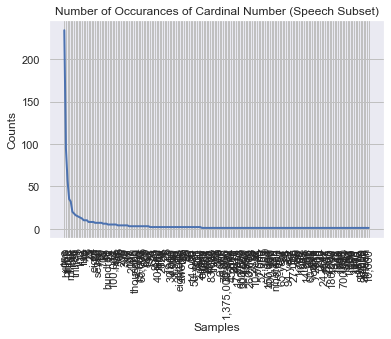

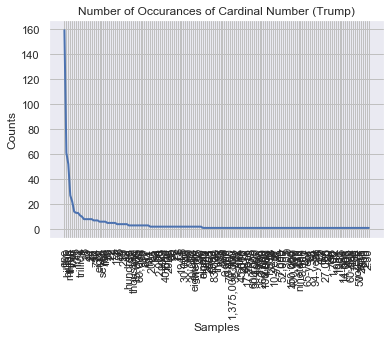

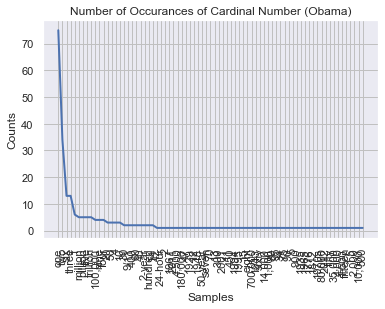

In [125]:
# Plot the cardinal number against their number of occurances
speech_pos_cd_dist["CD"].plot(title="Number of Occurances of Cardinal Number (Speech Subset)")
trump_pos_cd_dist["CD"].plot(title="Number of Occurances of Cardinal Number (Trump)")
obama_pos_cd_dist["CD"].plot(title="Number of Occurances of Cardinal Number (Obama)");

In [126]:
# Perform a similar analysis of the word probabilities conditional on POC
speech_pos_cd_dist = nltk.ConditionalProbDist(speech_pos_cd_dist, nltk.ELEProbDist)
speech_most_adj = speech_pos_cd_dist["JJ"].max()
speech_most_adj_prob = speech_pos_cd_dist["JJ"].prob(speech_most_adj)
print("In speech subset, the most common adjective is {} with probability {}.".format(speech_most_adj, speech_most_adj_prob))

In speech subset, the most common adjective is great with probability 0.029915886367243294.


In [127]:
trump_pos_cd_dist = nltk.ConditionalProbDist(trump_pos_cd_dist, nltk.ELEProbDist)
trump_most_adj = trump_pos_cd_dist["JJ"].max()
trump_most_adj_prob = trump_pos_cd_dist["JJ"].prob(trump_most_adj)
print("In Trump's speeches, the most common adjective is {} with probability {}.".format(trump_most_adj, trump_most_adj_prob))

In Trump's speeches, the most common adjective is great with probability 0.04290899662950479.


In [128]:
obama_pos_cd_dist = nltk.ConditionalProbDist(obama_pos_cd_dist, nltk.ELEProbDist)
obama_most_adj = obama_pos_cd_dist["JJ"].max()
obama_most_adj_prob =obama_pos_cd_dist["JJ"].prob(obama_most_adj)
print("In Obama's speeches, the most common adjective is {} with probability {}.".format(obama_most_adj, obama_most_adj_prob))

In Obama's speeches, the most common adjective is own with probability 0.025086173879739562.


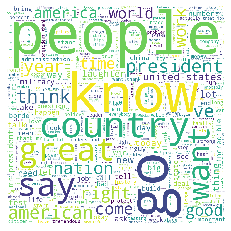

In [129]:
# Draw presidential speech word clouds for Trump and Obama respectively
trump_wc = wordcloud.WordCloud(background_color="white", max_words=500, \
                               width=2000, height=2000, mode="RGBA", scale=0.5).generate(" ".join(trump["normalized_tokens"].sum()))
plt.imshow(trump_wc)
plt.axis("off")
plt.savefig("Trump_speeches_wordl.pdf", format="pdf")

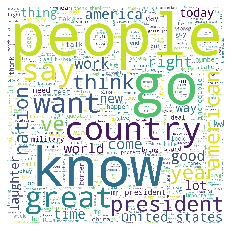

In [130]:
obama_wc = wordcloud.WordCloud(background_color="white", max_words=500, \
                               width=2000, height=2000, mode="RGBA", scale=0.5).generate(" ".join(trump["normalized_tokens"].sum()))
plt.imshow(obama_wc)
plt.axis("off")
plt.savefig("Obama_speeches_wordl.pdf", format="pdf")

The most frequent words in Trump's speeches overlap that in Obama's speeches such as "country", "kown", "people" and "world" and they describe the major theme of a U.S. presidential speeches. In addition, the most appeared words in both presidents' addresses are nouns and adjectives.

It's easy to point out Trump's speeches coincide with his campaign slogan "Make America Great Again". However, apart from the main keywords in big fonts, the rest words in Obama's speeches are relatively small and scattered, which to might indicate that Obama coped with a wide range of domestic and international issues.

## Davies Corpora

Now that we have our basic cleaning down, we can arrange our Davies Corpora. Let us try this with the movies corpora we have already loaded.

We'll use a smaller corpus of a 1000 movies for this demonstration.

In [131]:
zfile = zipfile.ZipFile(corpus_name + "/sources_movies.zip")
source = []

In [132]:
zfile.namelist()

['sources_movies.txt']

In [133]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [134]:
source[0:20]

[b'textID\tfileID\t#words\tgenre\tyear\tlanguage(s)\tcountry\timdb\ttitle\r\n',
 b'-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\r\n',
 b'\r\n',
 b'290635\t3547424\t4722\tShort, Musical\t1930\tUK\tEnglish\t0290635\tGoodbye to All That\r\n',
 b'21165\t6332374\t10220\tCrime, Mystery, Thriller\t1930\tUK\tEnglish\t0021165\tMurder!\r\n',
 b'21191\t6013789\t5281\tDrama, Romance\t1930\tUSA\tEnglish\t0021191\tA Notorious Affair\r\n',
 b'20620\t3660608\t6724\tBiography, Drama, History\t1930\tUSA\tEnglish\t0020620\tAbraham Lincoln\r\n',
 b'20629\t60053\t9552\tDrama, War\t1930\tUSA\tEnglish, French, German, Latin\t0020629\tAll Quiet on the Western Front\r\n',
 b'20640\t6850720\t13862\tComedy, Musical\t1930\tUSA\tEnglish\t0020640\tAnimal Crackers\r\n',
 b'20641\t176501\t11140\tDrama, Romance\t1930\tUSA\tEnglish\t0020641\tAnna Christie\r\n',
 b'20643\t3603861\t1748\tComedy, Short\t1930\tUSA\tEnglish\t0020643\tAnother Fine Mess\r\n',
 b'20670\t4159455\t6966\tComedy, Musical\t1930\tUS

It looks dirty because **the file is encoded as bytes**, but we can certainly see the information there. The file id is also present in the original raw text data: as the first "word". Look back at the normalized/tokenized words to confirm that. We're going to use this to create a dataframe with: Flieid, movie name, genre, year, and country.

**It is advised that you run a similar check of the source file before you do other extraction.**

First, let us create a dictionary mapping file-id to all the text. Each movie will be mapped to a list of the tokenized words.

In this example, I only use it to load 100 movies. You can comment this out or increase/decrease the number as you see fit.

In [135]:
movie_texts = {}
for files in movie_raw:
    if len(movie_texts) > 100:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        txts = lucem_illud_2020.word_tokenize(movie)
        try:
            movie_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

In [136]:
movie_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country", "Tokenized Texts"])

In [137]:
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), movie_texts[fileid.strip()]]
    except KeyError:
        continue

In [138]:
movie_df.head()

Movie Name            Genre  Year          Country  \
6850720    Animal Crackers  Comedy, Musical  1930          English   
176501       Anna Christie   Drama, Romance  1930          English   
4056770  Ladies of Leisure   Drama, Romance  1930          English   
5992934      Over the Hill            Drama  1931          English   
4436137  Design for Living  Comedy, Romance  1933  English, French   

                                           Tokenized Texts  
6850720  [You, must, do, your, best, tonight, Be, on, y...  
176501   [Either, you, 're, flat, or, I, am, I, beg, yo...  
4056770  [Look, out, There, 's, another, bottle, coming...  
5992934  [Good, morning, kitty, Come, in, here, baby, I...  
4436137  [Train_engine_grinding, 26;1426;TOOLONG, Whist...

# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its **semantic role** in a sentence. We will be using the in-built spaCy pos-tagging.

https://spacy.io/usage/linguistic-features

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

spaCy pos-tags word as we run it through the english language model. A small example:

In [139]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [140]:
for token in sent:
    print(token.text, token.pos_, token.tag_, sep="\t")

Tom	PROPN	NNP
went	VERB	VBD
to	ADP	IN
IKEA	PROPN	NNP
to	PART	TO
get	AUX	VB
some	DET	DT
of	ADP	IN
those	DET	DT
delicious	ADJ	JJ
Swedish	ADJ	JJ
meatballs	NOUN	NNS
.	PUNCT	.


This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [141]:
redditDF = pandas.read_csv('../data/reddit.csv')

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word). Here, we will use sentences tokenized by spaCy. Like before, these methods can also be found in lucem_illud.



In [142]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [143]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
# Reindex to make things nice in the future
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1)
redditTopScores

Unnamed: 0                author  over_18  score                subreddit  \
9           8        brenkelieshere    False   9448  Tales From Tech Support   
8           7             Bombadils    False  10528  Tales From Tech Support   
7        1200  whenlifegivesyoushit    False  11003            Relationships   
6           6                sfsdfd    False  11295  Tales From Tech Support   
5           5               Raitaro    False  12372  Tales From Tech Support   
4           4           goldie-gold    False  12650  Tales From Tech Support   
3           3        TheDroolinFool    False  13152  Tales From Tech Support   
2           2     Clickity_clickity    False  13404  Tales From Tech Support   
1           1                SECGaz    False  13724  Tales From Tech Support   
0           0      guitarsdontdance    False  14089  Tales From Tech Support   

                                                text  \
9  Last year, Help Desk got a call from a user co...   
8  First post in quite some time! I work at a loc...   
7  [Original Post](https://www.reddit.com/r/relat...   
6  I witnessed this astounding IT meltdown around...   
5  I work Helpdesk for a retail store chain in th...   
4  This just happened...  So, I had a laptop syst...   
3  Another tale from the out of hours IT desk... ...   
2  [Part 1](http://www.reddit.com/r/talesfromtech...   
1  > $Me  - Hello, IT.   > $Usr - Hi, I am still ...   
0  So my story starts on what was a normal day ta...   

                                               title  \
9  How to fix a laptop that won't boot in under a...   
8                  OK, now the password is 'D35p41r'   
7  [UPDATE]My [26 F] with my husband [29 M] 1 yea...   
6  Company-wide email + 30,000 employees + auto-r...   
5  I'm pretty sure I knocked a user out from near...   
4      Engineer is doing drugs!! No. No they aren't.   
3       "I need you to fix Google Bing immediately!"   
2                   Jack, the Worst End User, Part 4   
1              Hi, I am still off sick but I am not.   
0  "Don't bother sending a tech, I'll be dead by ...   

                                                 url  \
9  https://www.reddit.com/r/talesfromtechsupport/...   
8  https://www.reddit.com/r/talesfromtechsupport/...   
7  https://www.reddit.com/r/relationships/comment...   
6  https://www.reddit.com/r/talesfromtechsupport/...   
5  https://www.reddit.com/r/talesfromtechsupport/...   
4  https://www.reddit.com/r/talesfromtechsupport/...   
3  https://www.reddit.com/r/talesfromtechsupport/...   
2  https://www.reddit.com/r/talesfromtechsupport/...   
1  https://www.reddit.com/r/talesfromtechsupport/...   
0  https://www.reddit.com/r/talesfromtechsupport/...   

                                           sentences  
9  [[year, Help, Desk, got, a, call, from, a, use...  
8  [[post, in, quite, some, time], [work, at, a, ...  
7  [[Post](https://www.reddit.com, r, relationshi...  
6  [[witnessed, this, astounding, IT, meltdown, a...  
5  [[work, Helpdesk, for, a, retail, store, chain...  
4  [[just, happened], [I, had, a, laptop, system,...  
3  [[tale, from, the, out, of, hours], [desk], []...  
2  [[1](http://www.reddit.com, r, talesfromtechsu...  
1  [[], [Me], [IT], [$], [Hi, I, am, still, off, ...  
0  [[my, story, starts, on, what, was, a, normal,...

In [144]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    # Type of doc <class 'spacy.tokens.doc.Doc'>
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        # Type of sent <class 'spacy.tokens.span.Span'>
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [145]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_pos(x))

In [146]:
redditTopScores['POS_sents']

9    [[(year, NN), (Help, NNP), (Desk, NNP), (got, ...
8    [[(post, VB), (in, IN), (quite, PDT), (some, D...
7    [[(Post](https://www.reddit.com, NNP)], [(r, N...
6    [[(witnessed, VBD), (this, DT), (astounding, J...
5    [[(work, VB), (Helpdesk, NNP), (for, IN), (a, ...
4    [[(just, RB), (happened, VBD), (I, PRP), (had,...
3    [[(tale, NN), (from, IN), (the, DT), (out, NN)...
2    [[(1](http://www.reddit.com, NNP), (r, NN), (t...
1    [[( , _SP), (Me, PRP)], [(IT, PRP), ($, $)], [...
0    [[(my, PRP$), (story, NN), (starts, VBZ), (on,...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [147]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1

sortedTargets = sorted(targetCounts.items(), key=lambda x: x[1], reverse=True)
sortedTargets[:20]

[('m', 20),
 ('password', 20),
 ('time', 13),
 ('computer', 13),
 ('lot', 12),
 ('life', 11),
 ('email', 11),
 ('system', 10),
 ('laptop', 9),
 ('day', 9),
 ('call', 8),
 ('office', 8),
 ('message', 8),
 ('work', 8),
 ('part', 8),
 ('today', 8),
 ('story', 8),
 ('auto', 8),
 ('user', 7),
 ('job', 7)]

What about the adjectives that modify the word, "computer"?

In [148]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        # Loop through the sentence from the last one in a pair
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1, ent2.lower())==(NTarget, Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'own', 'unrestricted'}


## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In [149]:
speech.head(3)

link  \
0  https://millercenter.org/the-presidency/presid...   
1  https://millercenter.org/the-presidency/presid...   
2  https://millercenter.org/the-presidency/presid...   

                                               title               date  \
0   February 6, 2020: Remarks after HIs Acquittal \n  February 06, 2020   
1  February 15, 2019: Speech Declaring a National...  February 15, 2019   
2  December 18, 2017: Remarks on National Securit...  December 18, 2017   

           name           source  \
0  Donald Trump  The White House   
1  Donald Trump  The White House   
2  Donald Trump  The White House   

                                              script  \
0  \nTranscript\nWell, thank you very much. (Appl...   
1  \nTranscript\nTHE PRESIDENT:  Thank you very m...   
2  \nTranscript\nTHE PRESIDENT: Thank you very mu...   

                                              tokens  \
0  [Well, thank, you, very, much, Applause, Thank...   
1  [THE, PRESIDENT, Thank, you, very, much, every...   
2  [THE, PRESIDENT, Thank, you, very, much, Thank...   

                                   normalized_tokens  normalized_tokens_count  \
0  [thank, thank, thank, wow, thank, everybody, w...                     3574   
1  [president, thank, everybody, begin, like, lar...                     3310   
2  [president, thank, thank, want, thank, vice, p...                     1428   

                                                 pos  
0  [(\n, _SP), (transcript, NN), (\n, _SP), (well...  
1  [(\n, _SP), (transcript, NN), (\n, _SP), (the,...  
2  [(\n, _SP), (transcript, NN), (\n, _SP), (the,...

In [150]:
trump.head(3)

link  \
2   https://millercenter.org/the-presidency/presid...   
10  https://millercenter.org/the-presidency/presid...   
21  https://millercenter.org/the-presidency/presid...   

                                                title               date  \
2    February 6, 2020: Remarks after HIs Acquittal \n  February 06, 2020   
10  February 15, 2019: Speech Declaring a National...  February 15, 2019   
21  December 18, 2017: Remarks on National Securit...  December 18, 2017   

            name           source  \
2   Donald Trump  The White House   
10  Donald Trump  The White House   
21  Donald Trump  The White House   

                                               script  \
2   \nTranscript\nWell, thank you very much. (Appl...   
10  \nTranscript\nTHE PRESIDENT:  Thank you very m...   
21  \nTranscript\nTHE PRESIDENT: Thank you very mu...   

                                               tokens  \
2   [Well, thank, you, very, much, Applause, Thank...   
10  [THE, PRESIDENT, Thank, you, very, much, every...   
21  [THE, PRESIDENT, Thank, you, very, much, Thank...   

                                    normalized_tokens  \
2   [thank, thank, thank, wow, thank, everybody, w...   
10  [president, thank, everybody, begin, like, lar...   
21  [president, thank, thank, want, thank, vice, p...   

    normalized_tokens_count                                                pos  
2                      3574  [(\n, _SP), (transcript, NN), (\n, _SP), (well...  
10                     3310  [(\n, _SP), (transcript, NN), (\n, _SP), (the,...  
21                     1428  [(\n, _SP), (transcript, NN), (\n, _SP), (the,...

In [151]:
obama.head(3)

link  \
66  https://millercenter.org/the-presidency/presid...   
53  https://millercenter.org/the-presidency/presid...   
49  https://millercenter.org/the-presidency/presid...   

                                                title               date  \
66  December 10, 2009: Acceptance of Nobel Peace P...  December 10, 2009   
53  May 19, 2011: Speech on American Diplomacy in ...       May 19, 2011   
49  October 21, 2011: Remarks on the End of the Wa...   October 21, 2011   

            name           source  \
66  Barack Obama  The White House   
53  Barack Obama              NaN   
49  Barack Obama              NaN   

                                               script  \
66  \nTranscript\nYour Majesties, Your Royal Highn...   
53  \nTranscript\nThank you.  Thank you.  (Applaus...   
49  \nTranscript\nGood afternoon, everybody.  As a...   

                                               tokens  \
66  [Your, Majesties, Your, Royal, Highnesses, dis...   
53  [Thank, you, Thank, you, Applause, Thank, you,...   
49  [Good, afternoon, everybody, As, a, candidate,...   

                                    normalized_tokens  \
66  [majesty, royal, highness, distinguish, member...   
53  [thank, thank, thank, thank, seat, thank, want...   
49  [good, afternoon, everybody, candidate, presid...   

    normalized_tokens_count                                                pos  
66                     1883  [(\n, _SP), (transcript, NN), (\n, _SP), (your...  
53                     2606  [(\n, _SP), (transcript, NN), (\n, _SP), (than...  
49                      439  [(\n, _SP), (transcript, NN), (\n, _SP), (good...

In [152]:
# Define a function that tokenize sentences
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [153]:
# Tokenize sentences in the presidential speech corpus
speech["sentences"] = speech["script"].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
trump["sentences"] = trump["script"].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
obama["sentences"] = obama["script"].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])

In [154]:
speech.head(3)

link  \
0  https://millercenter.org/the-presidency/presid...   
1  https://millercenter.org/the-presidency/presid...   
2  https://millercenter.org/the-presidency/presid...   

                                               title               date  \
0   February 6, 2020: Remarks after HIs Acquittal \n  February 06, 2020   
1  February 15, 2019: Speech Declaring a National...  February 15, 2019   
2  December 18, 2017: Remarks on National Securit...  December 18, 2017   

           name           source  \
0  Donald Trump  The White House   
1  Donald Trump  The White House   
2  Donald Trump  The White House   

                                              script  \
0  \nTranscript\nWell, thank you very much. (Appl...   
1  \nTranscript\nTHE PRESIDENT:  Thank you very m...   
2  \nTranscript\nTHE PRESIDENT: Thank you very mu...   

                                              tokens  \
0  [Well, thank, you, very, much, Applause, Thank...   
1  [THE, PRESIDENT, Thank, you, very, much, every...   
2  [THE, PRESIDENT, Thank, you, very, much, Thank...   

                                   normalized_tokens  normalized_tokens_count  \
0  [thank, thank, thank, wow, thank, everybody, w...                     3574   
1  [president, thank, everybody, begin, like, lar...                     3310   
2  [president, thank, thank, want, thank, vice, p...                     1428   

                                                 pos  \
0  [(\n, _SP), (transcript, NN), (\n, _SP), (well...   
1  [(\n, _SP), (transcript, NN), (\n, _SP), (the,...   
2  [(\n, _SP), (transcript, NN), (\n, _SP), (the,...   

                                           sentences  
0  [[], [thank, you, very, much], [], [you], [you...  
1  [[], [PRESIDENT], [you, very, much, everybody]...  
2  [[], [PRESIDENT, Thank, you, very, much], [you...

In [155]:
trump.head(3)

link  \
2   https://millercenter.org/the-presidency/presid...   
10  https://millercenter.org/the-presidency/presid...   
21  https://millercenter.org/the-presidency/presid...   

                                                title               date  \
2    February 6, 2020: Remarks after HIs Acquittal \n  February 06, 2020   
10  February 15, 2019: Speech Declaring a National...  February 15, 2019   
21  December 18, 2017: Remarks on National Securit...  December 18, 2017   

            name           source  \
2   Donald Trump  The White House   
10  Donald Trump  The White House   
21  Donald Trump  The White House   

                                               script  \
2   \nTranscript\nWell, thank you very much. (Appl...   
10  \nTranscript\nTHE PRESIDENT:  Thank you very m...   
21  \nTranscript\nTHE PRESIDENT: Thank you very mu...   

                                               tokens  \
2   [Well, thank, you, very, much, Applause, Thank...   
10  [THE, PRESIDENT, Thank, you, very, much, every...   
21  [THE, PRESIDENT, Thank, you, very, much, Thank...   

                                    normalized_tokens  \
2   [thank, thank, thank, wow, thank, everybody, w...   
10  [president, thank, everybody, begin, like, lar...   
21  [president, thank, thank, want, thank, vice, p...   

    normalized_tokens_count  \
2                      3574   
10                     3310   
21                     1428   

                                                  pos  \
2   [(\n, _SP), (transcript, NN), (\n, _SP), (well...   
10  [(\n, _SP), (transcript, NN), (\n, _SP), (the,...   
21  [(\n, _SP), (transcript, NN), (\n, _SP), (the,...   

                                            sentences  
2   [[], [thank, you, very, much], [], [you], [you...  
10  [[], [PRESIDENT], [you, very, much, everybody]...  
21  [[], [PRESIDENT, Thank, you, very, much], [you...

In [156]:
obama.head(3)

link  \
66  https://millercenter.org/the-presidency/presid...   
53  https://millercenter.org/the-presidency/presid...   
49  https://millercenter.org/the-presidency/presid...   

                                                title               date  \
66  December 10, 2009: Acceptance of Nobel Peace P...  December 10, 2009   
53  May 19, 2011: Speech on American Diplomacy in ...       May 19, 2011   
49  October 21, 2011: Remarks on the End of the Wa...   October 21, 2011   

            name           source  \
66  Barack Obama  The White House   
53  Barack Obama              NaN   
49  Barack Obama              NaN   

                                               script  \
66  \nTranscript\nYour Majesties, Your Royal Highn...   
53  \nTranscript\nThank you.  Thank you.  (Applaus...   
49  \nTranscript\nGood afternoon, everybody.  As a...   

                                               tokens  \
66  [Your, Majesties, Your, Royal, Highnesses, dis...   
53  [Thank, you, Thank, you, Applause, Thank, you,...   
49  [Good, afternoon, everybody, As, a, candidate,...   

                                    normalized_tokens  \
66  [majesty, royal, highness, distinguish, member...   
53  [thank, thank, thank, thank, seat, thank, want...   
49  [good, afternoon, everybody, candidate, presid...   

    normalized_tokens_count  \
66                     1883   
53                     2606   
49                      439   

                                                  pos  \
66  [(\n, _SP), (transcript, NN), (\n, _SP), (your...   
53  [(\n, _SP), (transcript, NN), (\n, _SP), (than...   
49  [(\n, _SP), (transcript, NN), (\n, _SP), (good...   

                                            sentences  
66  [[], [Majesties, Your, Royal, Highnesses, dist...  
53  [[Thank, you], [you], [], [you, very, much], [...  
49  [[], [afternoon, everybody], [a, candidate, fo...

In [157]:
# Define a function that replicates NLTK pos tagging on sentence
def tag_sent_pos(sentences):
    new_sents = []
    for sentence in sentences:
        new_sent = " ".join(sentence)
        new_sents.append(new_sent)
    final_string = " ".join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [158]:
# Tag POS for each sentence
speech["pos_sent"] = speech["sentences"].apply(lambda x: tag_sent_pos(x))
trump["pos_sent"] = trump["sentences"].apply(lambda x: tag_sent_pos(x))
obama["pos_sent"] = obama["sentences"].apply(lambda x: tag_sent_pos(x))

In [159]:
speech["pos_sent"].head()

0    [[( , _SP), (thank, VBP), (you, PRP), (very, R...
1    [[( , _SP), (PRESIDENT, NNP), (you, PRP), (ver...
2    [[( , _SP), (PRESIDENT, NNP), (Thank, VBP), (y...
3    [[( , _SP), (Speaker, NNP), (Mr., NNP), (Vice,...
4    [[( , _SP), (PRESIDENT, NNP), (you, PRP), (Lee...
Name: pos_sent, dtype: object

In [160]:
trump["pos_sent"].head()

2     [[( , _SP), (thank, VBP), (you, PRP), (very, R...
10    [[( , _SP), (PRESIDENT, NNP), (you, PRP), (ver...
21    [[( , _SP), (PRESIDENT, NNP), (Thank, VBP), (y...
11    [[( , _SP), (Speaker, NNP), (Mr., NNP), (Vice,...
14    [[( , _SP), (PRESIDENT, NNP), (you, PRP), (Lee...
Name: pos_sent, dtype: object

In [161]:
obama["pos_sent"].head()

66    [[( , _SP), (Majesties, NNS), (Your, PRP$), (R...
53    [[(Thank, VBP), (you, PRP), (you, PRP), ( , _S...
49    [[( , _SP), (afternoon, NN), (everybody, NN), ...
58    [[( , _SP), (PRESIDENT, NNP), (President, NNP)...
56    [[(Thank, VBP), (you, PRP), ( , _SP), (you, PR...
Name: pos_sent, dtype: object

In [162]:
# Define a function that counts the number of the taget
def count_tags(word_list, target):
    target_counts = {}
    for entry in word_list:
        for sentence in entry:
            for ent, kind in sentence:
                if kind != target:
                    continue
                elif ent in target_counts:
                    target_counts[ent] += 1
                else:
                    target_counts[ent] = 1
    sorted_targets = sorted(target_counts.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_targets

Count the frequency of **NN** words.

In [163]:
target = "NN"
speech_count_nn = count_tags(speech["pos_sent"], target)
speech_count_nn[:20]

[('country', 211),
 ('world', 207),
 ('time', 175),
 ('lot', 107),
 ('today', 107),
 ('way', 106),
 ('nation', 100),
 ('peace', 99),
 ('year', 93),
 ('job', 84),
 ('war', 81),
 ('security', 78),
 ('insurance', 77),
 ('government', 75),
 ('health', 72),
 ('future', 72),
 ('history', 62),
 ('care', 61),
 ('deal', 60),
 ('life', 54)]

In [164]:
trump_count_nn = count_tags(trump["pos_sent"], target)
trump_count_nn[:20]

[('country', 154),
 ('lot', 104),
 ('time', 98),
 ('world', 95),
 ('today', 67),
 ('way', 65),
 ('job', 63),
 ('nation', 61),
 ('year', 60),
 ('deal', 59),
 ('administration', 45),
 ('border', 43),
 ('trade', 42),
 ('guy', 41),
 ('wall', 40),
 ('military', 38),
 ('number', 37),
 ('future', 37),
 ('day', 35),
 ('something', 35)]

In [165]:
obama_count_nn = count_tags(obama["pos_sent"], target)
obama_count_nn[:20]

[('world', 112),
 ('time', 77),
 ('insurance', 71),
 ('peace', 66),
 ('war', 60),
 ('country', 57),
 ('security', 56),
 ('health', 54),
 ('government', 49),
 ('care', 46),
 ('plan', 42),
 ('way', 41),
 ('today', 40),
 ('region', 40),
 ('nation', 39),
 ('future', 35),
 ('year', 33),
 ('economy', 32),
 ('history', 30),
 ('law', 29)]

As discussed above, the most frequently used nouns by Trump and Obama are highly similar to each other, such as "country", "world", "tax" and etc. 

On the contrary, the slight difference suggests Trump paid more attention to topics on "administration" and "military", while Obama laid more emphasis on "insurance" and "security."

Count the frequency of **VBD** words.

In [166]:
target = "VBD"
speech_count_vbd = count_tags(speech["pos_sent"], target)
speech_count_vbd[:20]

[('was', 397),
 ('said', 172),
 ('did', 151),
 ('were', 148),
 ('had', 142),
 ('got', 71),
 ('came', 39),
 ('made', 39),
 ('went', 38),
 ('took', 33),
 ('lost', 31),
 ('worked', 27),
 ('won', 23),
 ('saw', 23),
 ('thought', 19),
 ('wanted', 18),
 ('put', 18),
 ('spoke', 17),
 ('knew', 16),
 ('called', 16)]

In [167]:
trump_count_vbd = count_tags(trump["pos_sent"], target)
trump_count_vbd[:20]

[('was', 308),
 ('said', 152),
 ('did', 130),
 ('had', 115),
 ('were', 115),
 ('got', 66),
 ('went', 34),
 ('made', 30),
 ('took', 28),
 ('came', 26),
 ('lost', 25),
 ('won', 20),
 ('worked', 19),
 ('thought', 18),
 ('saw', 18),
 ('wanted', 16),
 ('done', 13),
 ('knew', 13),
 ('put', 13),
 ('told', 11)]

In [168]:
obama_count_vbd = count_tags(obama["pos_sent"], target)
obama_count_vbd[:20]

[('was', 89),
 ('were', 33),
 ('had', 27),
 ('did', 21),
 ('said', 20),
 ('came', 13),
 ('began', 9),
 ('made', 9),
 ('worked', 8),
 ('spoke', 7),
 ('led', 6),
 ('called', 6),
 ('helped', 6),
 ('heard', 6),
 ('let', 6),
 ('lost', 6),
 ('sent', 5),
 ('saw', 5),
 ('took', 5),
 ('put', 5)]

The usage of past tense verbs exhibit similar patterns in the top five words among the two presidents. However, there is not much I can infer from the frequency of VBD words.

Count the frequency of **JJS** words.

In [169]:
target = "JJS"
speech_count_jjs = count_tags(speech["pos_sent"], target)
speech_count_jjs[:20]

[('best', 41),
 ('most', 27),
 ('greatest', 27),
 ('worst', 19),
 ('biggest', 18),
 ('highest', 16),
 ('largest', 16),
 ('lowest', 9),
 ('least', 7),
 ('closest', 5),
 ('strongest', 4),
 ('toughest', 3),
 ('wealthiest', 3),
 ('oldest', 3),
 ('nastiest', 2),
 ('hardest', 2),
 ('easiest', 2),
 ('deepest', 2),
 ('surest', 2),
 ('roughest', 1)]

In [170]:
trump_count_jjs = count_tags(trump["pos_sent"], target)
trump_count_jjs[:20]

[('best', 23),
 ('greatest', 21),
 ('biggest', 17),
 ('worst', 13),
 ('largest', 12),
 ('most', 10),
 ('highest', 10),
 ('lowest', 9),
 ('least', 6),
 ('toughest', 3),
 ('nastiest', 2),
 ('easiest', 2),
 ('deepest', 2),
 ('oldest', 2),
 ('strongest', 2),
 ('closest', 2),
 ('roughest', 1),
 ('hardest', 1),
 ('surest', 1),
 ('fastest', 1)]

In [171]:
obama_count_jjs = count_tags(obama["pos_sent"], target)
obama_count_jjs[:20]

[('best', 18),
 ('most', 17),
 ('highest', 6),
 ('greatest', 6),
 ('worst', 6),
 ('largest', 4),
 ('closest', 3),
 ('strongest', 2),
 ('wealthiest', 2),
 ('finest', 1),
 ('newest', 1),
 ('clearest', 1),
 ('hardest', 1),
 ('least', 1),
 ('healthiest', 1),
 ('sickest', 1),
 ('surest', 1),
 ('oldest', 1),
 ('slightest', 1),
 ('heaviest', 1)]

The statistics help to confirm that Trump does utilize the superlative adjective **"greatest"** more often than Obama.

In [172]:
# Define a funtion that explores the frequency of two targets
def count_2tags(word_list, target1, target2):
    n_results = set()
    for entry in word_list:
        for sentence in entry:
            for (ent1, kind1), (ent2, kind2) in zip(sentence[:-1], sentence[1:]):
                if (kind1, kind2) == (target1, target2):
                    n_results.add((ent1, ent2))
                else:
                    continue
    return n_results

What superlative adjective (**JJS**) are used to describe nouns (**NN**)?

In [173]:
target1 = "JJS"
target2 = "NN"
speech_count_jjs_nn = count_2tags(speech["pos_sent"], target1, target2)
list(speech_count_jjs_nn)[:20]

[('largest', 'decline'),
 ('largest', 'number'),
 ('best', 'way'),
 ('busiest', 'trucking'),
 ('easiest', 'job'),
 ('largest', 'year'),
 ('largest', 'housecall'),
 ('best', 'intelligence'),
 ('biggest', 'thing'),
 ('greatest', 'lobbying'),
 ('biggest', 'story'),
 ('greatest', 'honor'),
 ('biggest', 'stage'),
 ('largest', 'economy'),
 ('largest', 'energy'),
 ('greatest', 'poker'),
 ('largest', 'pay'),
 ('biggest', 'problem'),
 ('best', 'military'),
 ('best', 'chance')]

In [174]:
trump_count_jjs_nn = count_2tags(trump["pos_sent"], target1, target2)
list(trump_count_jjs_nn)[:20]

[('largest', 'decline'),
 ('largest', 'number'),
 ('best', 'way'),
 ('easiest', 'job'),
 ('largest', 'year'),
 ('largest', 'housecall'),
 ('best', 'intelligence'),
 ('biggest', 'thing'),
 ('greatest', 'lobbying'),
 ('biggest', 'story'),
 ('greatest', 'honor'),
 ('biggest', 'stage'),
 ('largest', 'economy'),
 ('largest', 'energy'),
 ('greatest', 'poker'),
 ('largest', 'pay'),
 ('biggest', 'problem'),
 ('best', 'military'),
 ('hardest', 'worker'),
 ('biggest', 'tax')]

In [175]:
obama_count_jjs_nn = count_2tags(obama["pos_sent"], target1, target2)
list(obama_count_jjs_nn)[:20]

[('best', 'way'),
 ('busiest', 'trucking'),
 ('best', 'chance'),
 ('clearest', 'contrast'),
 ('greatest', 'hope'),
 ('greatest', 'challenge'),
 ('cheapest', 'labor'),
 ('largest', 'nation'),
 ('largest', 'business'),
 ('most', 'government'),
 ('best', 'life'),
 ('strongest', 'foundation'),
 ('slightest', 'hint'),
 ('worst', 'pollution'),
 ('best', 'example'),
 ('greatest', 'scale'),
 ('highest', 'court'),
 ('largest', 'labor'),
 ('greatest', 'nation'),
 ('heaviest', 'burden')]

What adverbs (**RB**) are used to describe verbs (**VB**)?

In [176]:
target1 = "RB"
target2 = "VB"
speech_count_rb_vb = count_2tags(speech["pos_sent"], target1, target2)
list(speech_count_rb_vb)[:20]

[('probably', 'be'),
 ('first', 'follow'),
 ('not', 'impact'),
 ('n’t', 'apologize'),
 ('not', 'compel'),
 ('even', 'do'),
 ('just', 'want'),
 ('not', 'threaten'),
 ('n’t', 'see'),
 ('ultimately', 'determine'),
 ('n’t', 'get'),
 ('not', 'ignore'),
 ('proudly', 'declare'),
 ('not', 'mean'),
 ('all', 'go'),
 ('not', 'tolerate'),
 ('not', 'convince'),
 ('still', 'reach'),
 ('probably', 'come'),
 ('n’t', 'solve')]

In [177]:
trump_count_rb_vb = count_2tags(trump["pos_sent"], target1, target2)
list(trump_count_rb_vb)[:20]

[('n’t', 'beat'),
 ('n’t', 'decide'),
 ('probably', 'be'),
 ('first', 'follow'),
 ('n’t', 'need'),
 ('only', 'be'),
 ('also', 'share'),
 ('ever', 'happen'),
 ('just', 'remember'),
 ('n’t', 'apologize'),
 ('even', 'have'),
 ('first', 'understand'),
 ('not', 'belong'),
 ('even', 'do'),
 ('perhaps', 'destroy'),
 ('never', 'do'),
 ('n’t', 'tell'),
 ('just', 'want'),
 ('narrowly', 'escape'),
 ('rather', 'build')]

In [178]:
obama_count_rb_vb = count_2tags(obama["pos_sent"], target1, target2)
list(obama_count_rb_vb)[:20]

[('not', 'impact'),
 ('only', 'be'),
 ('ultimately', 'depend'),
 ('not', 'bring'),
 ('not', 'add'),
 ('also', 'believe'),
 ('not', 'stop'),
 ('out', 'build'),
 ('not', 'sap'),
 ('not', 'compel'),
 ('always', 'put'),
 ('not', 'define'),
 ('fundamentally', 'recognize'),
 ('severely', 'restrict'),
 ('still', 'be'),
 ('not', 'apply'),
 ('never', 'know'),
 ('not', 'come'),
 ('ultimately', 'determine'),
 ('now', 'be')]

What adverbs (**RB**) are used to describe adjectives (**JJ**)?

In [179]:
target1 = "RB"
target2 = "JJ"
speech_count_rb_jj = count_2tags(speech["pos_sent"], target1, target2)
list(speech_count_rb_jj)[:20]

[('much', 'good'),
 ('not', 'new'),
 ('really', 'talented'),
 ('not', 'dependent'),
 ('away', 'collective'),
 ('not', 'possible'),
 ('though', 'much'),
 ('not', 'quiet'),
 ('not', 'good'),
 ('even', 'scared'),
 ('only', 'civil'),
 ('not', 'easy'),
 ('very', 'funny'),
 ('too', 'late'),
 ('really', 'good'),
 ('too', 'risky'),
 ('entirely', 'new'),
 ('pretty', 'general'),
 ('early', 'next'),
 ('very', 'near')]

In [180]:
trump_count_rb_jj = count_2tags(trump["pos_sent"], target1, target2)
list(trump_count_rb_jj)[:20]

[('downright', 'nasty'),
 ('not', 'correct'),
 ('much', 'good'),
 ('so', 'vibrant'),
 ('hopefully', 'bipartisan'),
 ('very', 'cruel'),
 ('as', 'good'),
 ('very', 'much'),
 ('environmentally', 'unsound'),
 ('so', 'hard'),
 ('longer', 'tough'),
 ('really', 'talented'),
 ('down', 'big'),
 ('not', 'dependent'),
 ('so', 'friendly'),
 ('certainly', 'important'),
 ('not', 'successful'),
 ('so', 'low'),
 ('highly', 'sophisticated'),
 ('possibly', 'Democratic')]

In [181]:
obama_count_rb_jj = count_2tags(obama["pos_sent"], target1, target2)
list(obama_count_rb_jj)[:20]

[('again', 'ascendant'),
 ('not', 'new'),
 ('as', 'good'),
 ('just', 'incompatible'),
 ('particularly', 'active'),
 ('rarely', 'enough'),
 ('certainly', 'true'),
 ('morally', 'incapable'),
 ('always', 'open'),
 ('away', 'collective'),
 ('not', 'possible'),
 ('only', 'civil'),
 ('not', 'worth'),
 ('all', 'connected'),
 ('very', 'difficult'),
 ('not', 'easy'),
 ('not', 'mere'),
 ('very', 'same'),
 ('very', 'funny'),
 ('too', 'distrustful')]

In [182]:
# Define a function that investigates the frequency of the target tag and a specific word
def count_tag_word(word_list, target, word):
    n_results = set()
    for entry in word_list:
        for sentence in entry:
            for (ent1, kind1), (ent2, kind2) in zip(sentence[:-1], sentence[1:]):
                if (kind1, ent2.lower()) == (target, word):
                    n_results.add(ent1)
                else:
                    continue
    return n_results

What adjectives (**JJ**) are used to describe "people"?

In [183]:
target = "JJ"
word = "people"
speech_count_jj_ppl = count_tag_word(speech["pos_sent"], target, word)
list(speech_count_jj_ppl)[:20]

['low',
 'well',
 'independent',
 'Iraqi',
 'evil',
 'wonderful',
 'ordinary',
 'rich',
 'many',
 'wrong',
 'other',
 'Iranian',
 'know',
 'certain',
 'Jewish',
 'Libyan',
 'capable',
 'great',
 'right',
 'brave']

In [184]:
trump_count_jj_ppl = count_tag_word(trump["pos_sent"], target, word)
list(trump_count_jj_ppl)[:20]

['low',
 'well',
 'independent',
 'evil',
 'rich',
 'many',
 'wrong',
 'other',
 'Iranian',
 'know',
 'certain',
 'Jewish',
 'capable',
 'great',
 'right',
 'brave',
 'sick',
 'American',
 'Venezuelan',
 'own']

In [185]:
obama_count_jj_ppl = count_tag_word(obama["pos_sent"], target, word)
list(obama_count_jj_ppl)[:20]

['Syrian',
 'Jewish',
 'many',
 'Iraqi',
 'Libyan',
 'British',
 'other',
 'bad',
 'American',
 'innocent',
 'Iranian',
 'Pakistani',
 'free',
 'wonderful',
 'ordinary',
 'own',
 'young',
 'Palestinian']

The analysis of the adjectives of "people" in both presidents' speeches reveals the same conclusion as the aforementioned results. Due to the Iraq war, **middle eastern people** ("Iranian people", "Iraqi people", "Pakistani people" and so on) occurred more in Obama's speeches.

# Collocations

As illustrated above, we might want to find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (*n*-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length *n*). 

We will begin with the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. **By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-grams.**

In [186]:
whBigrams = nltk.collocations.BigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(whBigrams.N))

There are 1966 bigrams in the finder


To compare the bigrams we need to tell nltk what our **score function** is. Initially, we will look at the raw counts.

In [187]:
help(whBigrams.nbest)

Help on method nbest in module nltk.collocations:

nbest(score_fn, n) method of nltk.collocations.BigramCollocationFinder instance
    Returns the top n ngrams when scored by the given function.



In [188]:
def bigramScoring(count, wordsTuple, total):
    return count

print(whBigrams.nbest(bigramScoring, 10))

[('president', 'bush'), ('rhode', 'island'), ('sheldon', 'whitehouse'), ('stem', 'cell'), ('whitehouse', 'd'), ('d', 'r.i'), ('bush', 'administration'), ('whitehouse', 'say'), ('american', 'people'), ('bring', 'troop')]


In [189]:
def bigramScoring2(count, wordsTuple, total):
    return total
print(whBigrams.nbest(bigramScoring2, 10))

[('$', 'available'), ('$', 'foregone'), ('$', 'grant'), ('$', 'interest'), ('$', 'spend'), ('$', 'u.s'), ('$', 'woman'), ('46th', 'annual'), ('ability', 'portuguese'), ('academic', 'achievement')]


One note about how `BigramCollocationFinder` works. It doesn't use the strings internally.

In [190]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

whBigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

# Equivalent to the print codes above
# for bs in birgramScores[:10]:
#     print(bs)

The first word is:  9, The second word is: 40
The first word is:  40, The second word is: 4
The first word is:  4, The second word is: 2
The first word is:  2, The second word is: 2
The first word is:  2, The second word is: 2
The first word is:  2, The second word is: 2
The first word is:  2, The second word is: 12
The first word is:  12, The second word is: 12
The first word is:  12, The second word is: 9
The first word is:  9, The second word is: 4


In [191]:
birgramScores

['The first word is:  9, The second word is: 40',
 'The first word is:  40, The second word is: 4',
 'The first word is:  4, The second word is: 2',
 'The first word is:  2, The second word is: 2',
 'The first word is:  2, The second word is: 2',
 'The first word is:  2, The second word is: 2',
 'The first word is:  2, The second word is: 12',
 'The first word is:  12, The second word is: 12',
 'The first word is:  12, The second word is: 9',
 'The first word is:  9, The second word is: 4',
 'The first word is:  4, The second word is: 2',
 'The first word is:  2, The second word is: 4',
 'The first word is:  4, The second word is: 1',
 'The first word is:  1, The second word is: 17',
 'The first word is:  17, The second word is: 1',
 'The first word is:  1, The second word is: 2',
 'The first word is:  2, The second word is: 2',
 'The first word is:  2, The second word is: 9',
 'The first word is:  9, The second word is: 12',
 'The first word is:  12, The second word is: 40',
 'The fir

The words are each given numeric IDs and there is a dictionary that maps the IDs to the words they represent. This is a common performance optimization.

Two words can appear together by chance. Recall from  Manning and Schütze's textbook that a **t-value** can be computed for each bigram to see how significant the association is. You may also want to try computing **the $\chi^2$, likelihood ratio**, and pointwise mutual information statistics. 

In [192]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
whBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('rhode', 'island'), 178.4626724897413),
 (('stem', 'cell'), 146.29899697399068),
 (('president', 'bush'), 126.26729276568966),
 (('sheldon', 'whitehouse'), 97.4298528095992),
 (('d', 'r.i'), 84.9146961271807),
 (('united', 'states'), 81.48563202934115),
 (('whitehouse', 'd'), 57.76763043351339),
 (('senator', 'sheldon'), 49.72259487860021),
 (('jack', 'reed'), 46.48119675073579),
 (('american', 'people'), 46.36945188839907),
 (('bush', 'administration'), 45.46512896674145),
 (('honor', 'society'), 44.90628391896907),
 (('bring', 'troop'), 43.09168928304577),
 (('cell', 'research'), 41.09314736916158),
 (('d', 'ri'), 39.02133612474179),
 (('potential', 'closing'), 38.1761672488765),
 (('youth', 'program'), 38.1761672488765),
 (('u.s', 'senator'), 37.29814426167994),
 (('troop', 'home'), 36.67811523401771),
 (('come', 'home'), 36.52843915939549),
 (('epw', 'committee'), 34.32127210844136),
 (('whitehouse', 'say'), 33.11262200306782),
 (('budget', 'resolution'), 32.092896259399076),
 (

In [193]:
whBigrams.score_ngrams(bigram_measures.student_t)[:10]

[(('president', 'bush'), 4.138576820372943),
 (('rhode', 'island'), 4.081161519558478),
 (('stem', 'cell'), 3.4429575564492234),
 (('sheldon', 'whitehouse'), 3.393621419509316),
 (('whitehouse', 'd'), 3.05290081332634),
 (('d', 'r.i'), 2.9711766700576465),
 (('bush', 'administration'), 2.5801938922974763),
 (('whitehouse', 'say'), 2.5150209745201986),
 (('united', 'states'), 2.4420141891429448),
 (('senator', 'sheldon'), 2.4220793794356554)]

There are a few other available measures

In [194]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

In [195]:
whBigrams.score_ngrams(bigram_measures.chi_sq)[:10]

[(('46th', 'annual'), 1966.0),
 (('active', 'retired'), 1966.0),
 (('add', 'immense'), 1966.0),
 (('aim', 'foster'), 1966.0),
 (('alice', 'wonderland'), 1966.0),
 (('alzheimer', 'parkinson'), 1966.0),
 (('assess', 'situation'), 1966.0),
 (('august', 'bill'), 1966.0),
 (('award', 'cover'), 1966.0),
 (('belief', 'announcement'), 1966.0)]

We can also look at trigrams

In [196]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('sheldon', 'whitehouse', 'd'), 3.1616100497095263),
 (('whitehouse', 'd', 'r.i'), 2.6450863551309975),
 (('bring', 'troop', 'home'), 2.449193154185041),
 (('senator', 'sheldon', 'whitehouse'), 2.4489320548208684),
 (('stem', 'cell', 'research'), 2.2359180252547137),
 (('u.s', 'senator', 'sheldon'), 2.2358694296197354),
 (('senate', 'youth', 'program'), 1.732017198625133),
 (('united', 'states', 'senator'), 1.7319916558278872),
 (('jack', 'reed', 'd'), 1.7319695486115574),
 (('new', 'direction', 'iraq'), 1.7318500501449103),
 (('rhode', 'island', 'state'), 1.7316952996306025),
 (('whitehouse', 'd', 'ri'), 1.7316445127822775),
 (('sen', 'sheldon', 'whitehouse'), 1.7314055158489832),
 (('reconsider', 'potential', 'closing'), 1.4142080740555638),
 (('responsibility', 'security', 'governance'), 1.414204781065045),
 (('$', 'foregone', 'surplus'), 1.4142018539623618),
 (('senators', 'jack', 'reed'), 1.4142018539623618),
 (('v.', 'epa', 'decide'), 1.4142018539623618),
 (('cell', 'enhancemen

Or n-grams (for any number n)

In [197]:
Ngrams = nltk.ngrams(whReleases['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1

Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('sen', 'sheldon', 'whitehouse', 'd'): 2, ('sheldon', 'whitehouse', 'd', 'r.i'): 7, ('stem', 'cell', 'research', 'whitehouse'): 2, ('stem', 'cell', 'enhancement', 'act'): 2, ('begin', 'bring', 'troop', 'home'): 2, ('bring', 'troop', 'home', 'iraq'): 2, ('u.s', 'senator', 'sheldon', 'whitehouse'): 5, ('senator', 'sheldon', 'whitehouse', 'd'): 5, ('sheldon', 'whitehouse', 'd', 'ri'): 3, ('whitehouse', 'd', 'ri', 'say'): 2, ('d', 'ri', 'say', 'today'): 2, ('member', 'senate', 'select', 'committee'): 2, ('senate', 'select', 'committee', 'intelligence'): 2, ('california', 'rhode', 'island', 'state'): 2, ('u.s', 'senators', 'jack', 'reed'): 2, ('senators', 'jack', 'reed', 'd'): 2, ('jack', 'reed', 'd', 'r.i'): 2, ('reed', 'd', 'r.i', 'sheldon'): 2, ('d', 'r.i', 'sheldon', 'whitehouse'): 2, ('r.i', 'sheldon', 'whitehouse', 'd'): 2, ('iraq', 'sen', 'sheldon', 'whitehouse'): 2, ('portuguese', 'american', 'citizen', 'rhode'): 2, ('american', 'citizen', 'rhode', 'island'): 2}


**Gensim** is another important python text processing package which allows us to use collocations, among other cool methods (which we will explore later weeks).

In [198]:
import gensim

In [199]:
bigram = gensim.models.Phrases(whReleases['normalized_tokens'])

In [200]:
texts = [bigram[line] for line in whReleases['normalized_tokens']]

In [201]:
texts[0]

['sen',
 'whitehouse',
 'share',
 'westerly',
 'girl',
 'story',
 'push',
 'stem_cell',
 'research',
 'share',
 'story',
 'lila',
 'barber',
 'year',
 'old',
 'girl',
 'westerly',
 'sen',
 'sheldon_whitehouse',
 'd_r.i',
 'tuesday',
 'april',
 'illustrate',
 'hope',
 'stem_cell',
 'research',
 'offer',
 'speech',
 'senate',
 'floor',
 'favor',
 'legislation',
 'expand',
 'federal',
 'funding',
 'stem_cell',
 'research',
 'whitehouse',
 'meet',
 'lila',
 'week',
 'ago',
 'diagnose',
 'year',
 'ago',
 'osteosarcoma',
 'cancerous',
 'bone',
 'condition',
 'year',
 'undergo',
 'cadaver',
 'bone',
 'transplant',
 'surgery',
 'procedure',
 'save',
 'leg',
 'help',
 'remain',
 'cancer',
 'free',
 'transplanted',
 'tissue',
 'grow',
 'likely',
 'break',
 'time',
 'stem_cell',
 'research',
 'whitehouse',
 'explain',
 'vastly',
 'improve',
 'care',
 'patient',
 'like',
 'lila',
 'allow',
 'surgeon',
 'enhance',
 'transplant',
 'patient',
 'stem_cell',
 'replace',
 'lose',
 'bone',
 'cartilage',


## <span style="color:red">*Exercise 5*</span>

<span style="color:red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<span style="color:red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</span> 

**Bigrams**

In [202]:
speech_bigrams = nltk.collocations.BigramCollocationFinder.from_words(speech["normalized_tokens"].sum())
print("There are {} bigrams in the speech subset finder.".format(speech_bigrams.N))

trump_bigrams = nltk.collocations.BigramCollocationFinder.from_words(trump["normalized_tokens"].sum())
print("There are {} bigrams in the Trump's speeches finder.".format(trump_bigrams.N))

obama_bigrams = nltk.collocations.BigramCollocationFinder.from_words(obama["normalized_tokens"].sum())
print("There are {} bigrams in the Obama's speeches finder.".format(obama_bigrams.N))

There are 38104 bigrams in the speech subset finder.
There are 22723 bigrams in the Trump's speeches finder.
There are 15381 bigrams in the Obama's speeches finder.


In [203]:
# Define a score function that helps compare bigrams
def bigram_scoring(count, words_tuple, total):
    return count

In [204]:
print("Bigrams from speech subset: ", speech_bigrams.nbest(bigram_scoring, 10))
print("Bigrams from Trump's speeches: ", trump_bigrams.nbest(bigram_scoring, 10))
print("Bigrams from Obama's speeches: ", obama_bigrams.nbest(bigram_scoring, 10))

Bigrams from speech subset:  [('united', 'states'), ('mr', 'president'), ('thank', 'mr'), ('thank', 'thank'), ('health', 'care'), ('man', 'woman'), ('want', 'thank'), ('middle', 'east'), ('american', 'people'), ('ahead', 'q')]
Bigrams from Trump's speeches:  [('united', 'states'), ('mr', 'president'), ('thank', 'mr'), ('thank', 'thank'), ('want', 'thank'), ('ahead', 'q'), ('president', 'thank'), ('great', 'job'), ('q', 'thank'), ('thank', 'president')]
Bigrams from Obama's speeches:  [('united', 'states'), ('health', 'care'), ('insurance', 'company'), ('human', 'right'), ('man', 'woman'), ('middle', 'east'), ('small', 'business'), ('al', 'qaeda'), ('states', 'america'), ('east', 'north')]


Two-word phrases are consist of noun phrases, such as "United States", "American people", "Al Qaeda" and so on, and verb phases such as "create job", which are idiomatic in the American English.

In [205]:
# Perform chi-squared test for bigrams
speech_bigram_measures = nltk.collocations.BigramAssocMeasures()
sorted(speech_bigrams.score_ngrams(speech_bigram_measures.student_t), key=lambda x: x[1], reverse=True)[:20]

[(('united', 'states'), 12.188236426437475),
 (('mr', 'president'), 8.19797202878991),
 (('health', 'care'), 6.1385166456117854),
 (('thank', 'mr'), 6.136408047361146),
 (('thank', 'thank'), 5.934087822797003),
 (('man', 'woman'), 5.799234738391928),
 (('want', 'thank'), 5.555502771112319),
 (('middle', 'east'), 5.469712549558554),
 (('ahead', 'q'), 5.1646363467063585),
 (('american', 'people'), 4.881543492189152),
 (('new', 'york'), 4.87583713023878),
 (('insurance', 'company'), 4.865969487064384),
 (('great', 'job'), 4.708697897317401),
 (('president', 'thank'), 4.698844905512572),
 (('god', 'bless'), 4.6838413623397575),
 (('small', 'business'), 4.568057997292912),
 (('human', 'right'), 4.469853074403797),
 (('q', 'thank'), 4.280593705404804),
 (('white', 'house'), 4.2399684381036735),
 (('billion', 'dollar'), 4.236145637428563)]

In [206]:
trump_bigram_measures = nltk.collocations.BigramAssocMeasures()
sorted(trump_bigrams.score_ngrams(trump_bigram_measures.student_t), key=lambda x: x[1], reverse=True)[:20]

[(('united', 'states'), 9.94843990670246),
 (('mr', 'president'), 8.090761317554506),
 (('thank', 'mr'), 6.010495337318348),
 (('want', 'thank'), 5.197891101889876),
 (('thank', 'thank'), 5.189881528672918),
 (('ahead', 'q'), 5.1494013557124445),
 (('great', 'job'), 4.744235722605249),
 (('president', 'thank'), 4.509326738305618),
 (('new', 'york'), 4.337222422807491),
 (('q', 'thank'), 4.182823810747086),
 (('god', 'bless'), 3.9948950402675703),
 (('billion', 'dollar'), 3.9922545438542447),
 (('man', 'woman'), 3.8504848292114486),
 (('m', 'go'), 3.8122166967389868),
 (('white', 'house'), 3.7388581007828683),
 (('american', 'people'), 3.7246397560645037),
 (('trade', 'deal'), 3.697550989855771),
 (('thank', 'president'), 3.6741166237697884),
 (('q', 'mr'), 3.617453773052373),
 (('dr', 'fauci'), 3.601791920175573)]

In [207]:
obama_bigram_measures = nltk.collocations.BigramAssocMeasures()
sorted(obama_bigrams.score_ngrams(obama_bigram_measures.student_t), key=lambda x: x[1], reverse=True)[:20]

[(('united', 'states'), 7.040266073136199),
 (('health', 'care'), 6.131339015863712),
 (('insurance', 'company'), 4.748329117301668),
 (('middle', 'east'), 4.349502160994775),
 (('man', 'woman'), 4.335720213260792),
 (('human', 'right'), 4.267019291980784),
 (('small', 'business'), 3.9842663025811067),
 (('al', 'qaeda'), 3.7382516782104647),
 (('states', 'america'), 3.663465098326772),
 (('north', 'africa'), 3.5993843335515967),
 (('east', 'north'), 3.5983565098995314),
 (('health', 'insurance'), 3.387376828048255),
 (('american', 'people'), 3.143041606151766),
 (('pass', 'job'), 3.1196369744705104),
 (('judge', 'sotomayor'), 2.9952322129033657),
 (('nuclear', 'weapon'), 2.9936285026981344),
 (('civil', 'society'), 2.9927182887978674),
 (('united', 'kingdom'), 2.986931929003316),
 (('global', 'economy'), 2.9824458747805735),
 (('last', 'peace'), 2.979065080293869)]

In [208]:
# Perform likelihood_ratio test for bigrams
speech_bigram_measures = nltk.collocations.BigramAssocMeasures()
sorted(speech_bigrams.score_ngrams(speech_bigram_measures.likelihood_ratio), key=lambda x: x[1], reverse=True)[:20]

[(('united', 'states'), 1775.902481543255),
 (('mr', 'president'), 545.433378930307),
 (('middle', 'east'), 408.3904692799751),
 (('health', 'care'), 385.1083270604957),
 (('man', 'woman'), 318.9583155418475),
 (('god', 'bless'), 288.79018278182565),
 (('white', 'house'), 284.6767089197938),
 (('thank', 'mr'), 263.38624614197107),
 (('new', 'york'), 260.3830662825136),
 (('prime', 'minister'), 252.87966563188405),
 (('ahead', 'q'), 245.75432220772342),
 (('al', 'qaeda'), 242.09943670938515),
 (('billion', 'dollar'), 224.6656749258204),
 (('small', 'business'), 221.5530422906156),
 (('insurance', 'company'), 208.59284296616084),
 (('dr', 'fauci'), 193.24827023501234),
 (('cruise', 'line'), 183.5412796029292),
 (('north', 'korea'), 170.70063575833078),
 (('thank', 'thank'), 170.59290498331765),
 (('port', 'entry'), 167.39180621680862)]

In [209]:
trump_bigram_measures = nltk.collocations.BigramAssocMeasures()
sorted(trump_bigrams.score_ngrams(trump_bigram_measures.likelihood_ratio), key=lambda x: x[1], reverse=True)[:20]

[(('united', 'states'), 1180.4568741305302),
 (('mr', 'president'), 496.11937417465435),
 (('thank', 'mr'), 230.99684644310037),
 (('ahead', 'q'), 227.49952878761695),
 (('god', 'bless'), 224.37050939544355),
 (('white', 'house'), 219.1255140188888),
 (('new', 'york'), 204.91693106329518),
 (('billion', 'dollar'), 194.1272700086522),
 (('dr', 'fauci'), 183.14206203468618),
 (('cruise', 'line'), 183.04035965796012),
 (('middle', 'east'), 164.06198153815666),
 (('north', 'korea'), 159.10668760348264),
 (('port', 'entry'), 157.05126776223494),
 (('prime', 'minister'), 136.94526724979391),
 (('man', 'woman'), 136.00900303068644),
 (('law', 'enforcement'), 133.21949105952822),
 (('south', 'korea'), 131.15427543126614),
 (('national', 'emergency'), 129.46076208491675),
 (('great', 'job'), 129.15100019479982),
 (('chairman', 'kim'), 124.05457381301767)]

In [210]:
obama_bigram_measures = nltk.collocations.BigramAssocMeasures()
sorted(obama_bigrams.score_ngrams(obama_bigram_measures.likelihood_ratio), key=lambda x: x[1], reverse=True)[:20]

[(('united', 'states'), 596.8265541369641),
 (('health', 'care'), 391.5403681647001),
 (('middle', 'east'), 239.80631978228087),
 (('al', 'qaeda'), 224.03851920077688),
 (('insurance', 'company'), 187.94608024039195),
 (('man', 'woman'), 183.38686993591605),
 (('small', 'business'), 168.32651633809502),
 (('north', 'africa'), 164.99812126368903),
 (('east', 'north'), 158.3605916850478),
 (('bin', 'laden'), 121.7265073275064),
 (('human', 'right'), 119.98314680096823),
 (('prime', 'minister'), 115.69818474740339),
 (('judge', 'sotomayor'), 114.0269251533389),
 (('nuclear', 'weapon'), 105.05716564148024),
 (('democrats', 'republicans'), 102.65760458817822),
 (('civil', 'society'), 101.3794197216371),
 (('medicare', 'medicaid'), 100.98179733253798),
 (('united', 'kingdom'), 99.11329964810534),
 (('israelis', 'palestinians'), 91.5297816783175),
 (('middle', 'class'), 89.30171138492655)]

**Examination of Conditional Frequences**

What else is "united" and "states" connect to except "united states"?

In [211]:
# Define a function for bigram conditional frequencies
def con_freq_bigram(text, word1, word2):
    con_freq_results = {}
    for sentence in text:
        for (w1, w2) in zip(sentence[:-1], sentence[1:]):
            if w1 == word1 or w2 == word2:
                if (w1, w2) in con_freq_results:
                    con_freq_results[(w1, w2)] += 1
                else:
                    con_freq_results[(w1, w2)] = 1
    return sorted(con_freq_results.items(), key=lambda x: x[1], reverse=True)

In [212]:
word1 = "united"
word2 = "states"
speech_cf_bigram = con_freq_bigram(speech["normalized_tokens"], word1, word2)
speech_cf_bigram

[(('united', 'states'), 150),
 (('united', 'nations'), 14),
 (('united', 'kingdom'), 12),
 (('united', 'support'), 2),
 (('gulf', 'states'), 1),
 (('united', 'astonishing'), 1),
 (('united', 'states—(applause)—with'), 1),
 (('united', 'united'), 1),
 (('united', 'nation'), 1),
 (('united', 'state'), 1)]

In [213]:
trump_cf_bigram = con_freq_bigram(trump["normalized_tokens"], word1, word2)
trump_cf_bigram

[(('united', 'states'), 100),
 (('united', 'nations'), 9),
 (('united', 'kingdom'), 3),
 (('gulf', 'states'), 1),
 (('united', 'astonishing'), 1),
 (('united', 'states—(applause)—with'), 1),
 (('united', 'united'), 1),
 (('united', 'nation'), 1)]

In [214]:
obama_cf_bigram = con_freq_bigram(obama["normalized_tokens"], word1, word2)
obama_cf_bigram

[(('united', 'states'), 50),
 (('united', 'kingdom'), 9),
 (('united', 'nations'), 5),
 (('united', 'support'), 2),
 (('united', 'state'), 1)]

In [215]:
speech_text.common_contexts(["united"]),
speech_text.common_contexts(["states"])

the_states n’t_kingdom the_nations ’s_states have_our be_at
parties_for are_we our_states the_states—(applause)—with the_kingdom
is_behind many_nations own_states a_nations stand_in these_states
and_kingdom be_by
united_the united_senate united_and united_always some_that united_a
united_of united_they united_billions united_welcome united_one
united_so united_supreme united_it united_mexico united_i united_we
united_would united_from gulf_and


In [216]:
trump_text.common_contexts(["united"]),
trump_text.common_contexts(["states"])

the_states n’t_kingdom the_nations ’s_states have_our be_at
parties_for are_we our_states the_states—(applause)—with the_kingdom
is_behind many_nations own_states
united_the united_senate united_and united_always some_that united_a
united_of united_they united_billions united_welcome united_one
united_so united_supreme united_it united_mexico united_i united_we
united_would united_from gulf_and


In [217]:
obama_text.common_contexts(["united"]),
obama_text.common_contexts(["states"])

the_states a_nations the_nations stand_in these_states the_kingdom
have_our and_kingdom be_by
united_senate failed_all united_of failed_like united_has
united_pursues united_and united_opposes united_supports united_to
united_joined united_we united_will united_not two_for united_believes
two_with both_the united_our arab_will


"United States" is still the most common two-word phrases. The other commonly appeared bigrams associated with "united" or "states" are **"United Nations"** and **"United Kindom"**. 

Besides, "united" is employed as an adjective to describe a noun, for instance, **"united condemn"**.

**Trigrams**

In [218]:
speech_trigram_measures = nltk.collocations.TrigramAssocMeasures()
speech_trigrams = nltk.collocations.TrigramCollocationFinder.from_words(speech["normalized_tokens"].sum())
sorted(speech_trigrams.score_ngrams(speech_trigram_measures.student_t)[:20], key=lambda x: x[1], reverse=True)

[(('thank', 'mr', 'president'), 5.74344113699623),
 (('q', 'thank', 'mr'), 4.24213730664477),
 (('united', 'states', 'america'), 4.122191664690443),
 (('q', 'mr', 'president'), 3.7408977460009636),
 (('east', 'north', 'africa'), 3.6055468742786103),
 (('middle', 'east', 'north'), 3.605539294459345),
 (('thank', 'thank', 'thank'), 3.6017071823493807),
 (('ahead', 'q', 'thank'), 3.46376415557949),
 (('president', 'ahead', 'q'), 3.16178567498562),
 (('thank', 'god', 'bless'), 2.999926625631091),
 (('mr', 'president', 'president'), 2.9971418938487733),
 (('thank', 'president', 'thank'), 2.993851290331714),
 (('pass', 'job', 'bill'), 2.8283458562672985),
 (('bless', 'god', 'bless'), 2.6457436641239624),
 (('god', 'bless', 'god'), 2.64573693481621),
 (('states', 'united', 'kingdom'), 2.645664989535248),
 (('health', 'care', 'system'), 2.6456610495711153),
 (('united', 'states', 'united'), 2.644434907742119),
 (('mr', 'president', 'want'), 2.6437370092826966),
 (('thank', 'great', 'job'), 2.6

In [219]:
trump_trigram_measures = nltk.collocations.TrigramAssocMeasures()
trump_trigrams = nltk.collocations.TrigramCollocationFinder.from_words(trump["normalized_tokens"].sum())
sorted(trump_trigrams.score_ngrams(trump_trigram_measures.student_t)[:20], key=lambda x: x[1], reverse=True)

[(('thank', 'mr', 'president'), 5.7421566863128435),
 (('q', 'thank', 'mr'), 4.2414596530848785),
 (('q', 'mr', 'president'), 3.739848145206286),
 (('ahead', 'q', 'thank'), 3.4633455082363613),
 (('president', 'ahead', 'q'), 3.161158645615622),
 (('mr', 'president', 'president'), 2.9937757637578293),
 (('thank', 'thank', 'thank'), 2.990506077954197),
 (('thank', 'president', 'thank'), 2.9871735175626095),
 (('thank', 'great', 'job'), 2.642661939319166),
 (('mr', 'president', 'want'), 2.6416787868408047),
 (('cruise', 'line', 'industry'), 2.44948619664638),
 (('billion', 'billion', 'dollar'), 2.4494774969489015),
 (('thank', 'god', 'bless'), 2.449399859877665),
 (('bless', 'god', 'bless'), 2.23606154734209),
 (('god', 'bless', 'god'), 2.23605632283896),
 (('withdraw', 'united', 'states'), 2.2359969443514576),
 (('united', 'states', 'military'), 2.2354794171278938),
 (('united', 'states', 'take'), 2.235296760460754),
 (('great', 'job', 'thank'), 2.2324125835546726),
 (('thank', 'thank', 

In [220]:
obama_trigram_measures = nltk.collocations.TrigramAssocMeasures()
obama_trigrams = nltk.collocations.TrigramCollocationFinder.from_words(obama["normalized_tokens"].sum())
sorted(obama_trigrams.score_ngrams(obama_trigram_measures.student_t)[:20], key=lambda x: x[1], reverse=True)

[(('united', 'states', 'america'), 3.7413167793150013),
 (('east', 'north', 'africa'), 3.605542855609613),
 (('middle', 'east', 'north'), 3.6055372423733627),
 (('pass', 'job', 'bill'), 2.828349636715643),
 (('states', 'united', 'kingdom'), 2.6457031418958024),
 (('health', 'care', 'system'), 2.645611024551392),
 (('united', 'states', 'united'), 2.645392718363614),
 (('american', 'jobs', 'act'), 2.4494737976848513),
 (('osama', 'bin', 'laden'), 1.9999995857553279),
 (('break', 'taliban', 'momentum'), 1.999999323682168),
 (('gabby', 'open', 'eye'), 1.9999949445242056),
 (('spread', 'nuclear', 'weapon'), 1.9999944076969265),
 (('small', 'business', 'owner'), 1.9999918165542325),
 (('hire', 'new', 'worker'), 1.9999719623988759),
 (('share', 'common', 'interest'), 1.9999702420153906),
 (('thank', 'thank', 'thank'), 1.9999584001128503),
 (('bless', 'united', 'states'), 1.9999362781792633),
 (('health', 'care', 'cost'), 1.9998144183868907),
 (('pass', 'right', 'away'), 1.9997987954449707),
 

Interestingly, the trigrams frequently spoken by Trump and Obama differ. For Donald Trump, he likes to say **"thank"**-related pharases even more than **"United States America"**; whereas for Barack Obama, apart from **"United States America"**, for example, he was inclined to refer to **"Osama Bin Laden"**,  the founder of the pan-Islamic militant organization al-Qaeda.

**N-grams**

In [221]:
# Define function that extract n-grams from the text and count the frequency
def n_grams_count(word_list, n):
    n_grams = nltk.ngrams(word_list, n)
    
    counts = {}
    for n_gram in n_grams:
        if n_gram in counts:
            counts[n_gram] += 1
        else:
            counts[n_gram] = 1
    return sorted(counts.items(), key=lambda x: x[1], reverse=True)

**Four-grams**

In [222]:
speech_4grams = n_grams_count(speech["normalized_tokens"].sum(), 4)
speech_4grams[:10]

[(('q', 'thank', 'mr', 'president'), 18),
 (('middle', 'east', 'north', 'africa'), 13),
 (('ahead', 'q', 'thank', 'mr'), 11),
 (('thank', 'god', 'bless', 'god'), 7),
 (('god', 'bless', 'god', 'bless'), 7),
 (('united', 'states', 'united', 'kingdom'), 7),
 (('bless', 'united', 'states', 'america'), 6),
 (('thank', 'mr', 'president', 'president'), 5),
 (('ahead', 'q', 'mr', 'president'), 4),
 (('thank', 'mr', 'president', 'want'), 4)]

In [223]:
trump_4grams = n_grams_count(trump["normalized_tokens"].sum(), 4)
trump_4grams[:10]

[(('q', 'thank', 'mr', 'president'), 18),
 (('ahead', 'q', 'thank', 'mr'), 11),
 (('thank', 'mr', 'president', 'president'), 5),
 (('thank', 'god', 'bless', 'god'), 5),
 (('god', 'bless', 'god', 'bless'), 5),
 (('ahead', 'q', 'mr', 'president'), 4),
 (('thank', 'mr', 'president', 'want'), 4),
 (('mr', 'president', 'president', 'thank'), 3),
 (('q', 'mr', 'president', 'president'), 3),
 (('mr', 'president', 'president', 'yes'), 3)]

In [224]:
obama_4grams = n_grams_count(obama["normalized_tokens"].sum(), 4)
obama_4grams[:10]

[(('middle', 'east', 'north', 'africa'), 13),
 (('united', 'states', 'united', 'kingdom'), 7),
 (('bless', 'united', 'states', 'america'), 4),
 (('stop', 'spread', 'nuclear', 'weapon'), 3),
 (('pass', 'right', 'away', 'pass'), 3),
 (('right', 'away', 'pass', 'job'), 3),
 (('away', 'pass', 'job', 'bill'), 3),
 (('give', 'way', 'war', 'nation'), 2),
 (('gradual', 'evolution', 'human', 'institution'), 2),
 (('united', 'states', 'america', 'remain'), 2)]

**Six-grams**

In [225]:
speech_6grams = n_grams_count(speech["normalized_tokens"].sum(), 6)
speech_6grams[:10]

[(('president', 'ahead', 'q', 'thank', 'mr', 'president'), 3),
 (('african', 'american', 'hispanic', 'american', 'asian', 'american'), 3),
 (('american', 'hispanic', 'american', 'asian', 'american', 'unemployment'),
  3),
 (('pass', 'right', 'away', 'pass', 'job', 'bill'), 3),
 (('criminal', 'list', 'drug', 'dealer', 'get', 'thing'), 2),
 (('list', 'drug', 'dealer', 'get', 'thing', 'call'), 2),
 (('yes', 'madam', 'ahead', 'q', 'thank', 'mr'), 2),
 (('madam', 'ahead', 'q', 'thank', 'mr', 'president'), 2),
 (('q', 'mr', 'president', 'president', 'yes', 'ahead'), 2),
 (('undocumented', 'immigrant', 'commit', 'crime', 'low', 'level'), 2)]

In [226]:
trump_6grams = n_grams_count(trump["normalized_tokens"].sum(), 6)
trump_6grams[:10]

[(('president', 'ahead', 'q', 'thank', 'mr', 'president'), 3),
 (('african', 'american', 'hispanic', 'american', 'asian', 'american'), 3),
 (('american', 'hispanic', 'american', 'asian', 'american', 'unemployment'),
  3),
 (('criminal', 'list', 'drug', 'dealer', 'get', 'thing'), 2),
 (('list', 'drug', 'dealer', 'get', 'thing', 'call'), 2),
 (('yes', 'madam', 'ahead', 'q', 'thank', 'mr'), 2),
 (('madam', 'ahead', 'q', 'thank', 'mr', 'president'), 2),
 (('q', 'mr', 'president', 'president', 'yes', 'ahead'), 2),
 (('undocumented', 'immigrant', 'commit', 'crime', 'low', 'level'), 2),
 (('ahead', 'q', 'thank', 'mr', 'president', 'want'), 2)]

In [227]:
obama_6grams = n_grams_count(obama["normalized_tokens"].sum(), 6)
obama_6grams[:10]

[(('pass', 'right', 'away', 'pass', 'job', 'bill'), 3),
 (('deal', 'al', 'qaeda', 'huge', 'blow', 'kill'), 2),
 (('al', 'qaeda', 'huge', 'blow', 'kill', 'leader'), 2),
 (('qaeda', 'huge', 'blow', 'kill', 'leader', 'osama'), 2),
 (('huge', 'blow', 'kill', 'leader', 'osama', 'bin'), 2),
 (('blow', 'kill', 'leader', 'osama', 'bin', 'laden'), 2),
 (('hold', 'truth', 'self', 'evident', 'man', 'create'), 2),
 (('truth', 'self', 'evident', 'man', 'create', 'equal'), 2),
 (('gabby', 'open', 'eye', 'time', 'gabby', 'open'), 2),
 (('open', 'eye', 'time', 'gabby', 'open', 'eye'), 2)]

**Skip-grams**

In [228]:
speech_trigram_measures = nltk.collocations.TrigramAssocMeasures()
speech_trigrams = nltk.collocations.TrigramCollocationFinder.from_words(speech["normalized_tokens"].sum(), window_size=5)
sorted(speech_trigrams.score_ngrams(speech_trigram_measures.student_t)[:20], key=lambda x: x[1], reverse=True)

[(('thank', 'thank', 'thank'), 7.337152524637494),
 (('thank', 'mr', 'president'), 6.850016117545296),
 (('q', 'mr', 'president'), 6.478109225579263),
 (('thank', 'president', 'thank'), 5.270586677844038),
 (('thank', 'god', 'bless'), 4.999735852271928),
 (('president', 'ahead', 'q'), 4.688425581768129),
 (('q', 'thank', 'president'), 4.680005597688013),
 (('ahead', 'q', 'president'), 4.470048638645746),
 (('q', 'thank', 'mr'), 4.355959216086639),
 (('ahead', 'q', 'mr'), 4.242063280104399),
 (('ahead', 'q', 'thank'), 4.121404489182691),
 (('united', 'states', 'america'), 4.117621860054355),
 (('ahead', 'mr', 'president'), 3.9981524949188203),
 (('president', 'thank', 'thank'), 3.972330806492714),
 (('ahead', 'thank', 'mr'), 3.7401733592749085),
 (('mr', 'president', 'thank'), 3.731326272261443),
 (('thank', 'thank', 'president'), 3.7120777746960516),
 (('east', 'north', 'africa'), 3.6055248683517123),
 (('middle', 'east', 'africa'), 3.60551892675145),
 (('middle', 'north', 'africa'), 3

In [229]:
trump_trigram_measures = nltk.collocations.TrigramAssocMeasures()
trump_trigrams = nltk.collocations.TrigramCollocationFinder.from_words(trump["normalized_tokens"].sum(), window_size=5)
sorted(trump_trigrams.score_ngrams(trump_trigram_measures.student_t)[:20], key=lambda x: x[1], reverse=True)

[(('thank', 'mr', 'president'), 6.77010304405886),
 (('q', 'mr', 'president'), 6.4744733017711695),
 (('thank', 'thank', 'thank'), 6.297535144503218),
 (('thank', 'president', 'thank'), 5.247871030054087),
 (('president', 'ahead', 'q'), 4.685889123078052),
 (('q', 'thank', 'president'), 4.666306498896962),
 (('ahead', 'q', 'president'), 4.467388378328575),
 (('q', 'thank', 'mr'), 4.352001738839923),
 (('ahead', 'q', 'mr'), 4.241310216125423),
 (('thank', 'god', 'bless'), 4.122785235200682),
 (('ahead', 'q', 'thank'), 4.119294084450158),
 (('ahead', 'mr', 'president'), 3.9961075018062555),
 (('president', 'thank', 'thank'), 3.942280829031742),
 (('ahead', 'thank', 'mr'), 3.7385773033196394),
 (('mr', 'president', 'thank'), 3.7194941775701595),
 (('thank', 'thank', 'president'), 3.679952997513413),
 (('thank', 'great', 'job'), 3.591949400929942),
 (('mr', 'president', 'president'), 3.5744780098800297),
 (('ahead', 'thank', 'president'), 3.451588045919693),
 (('president', 'yes', 'q'), 3.

In [230]:
obama_trigram_measures = nltk.collocations.TrigramAssocMeasures()
obama_trigrams = nltk.collocations.TrigramCollocationFinder.from_words(obama["normalized_tokens"].sum(), window_size=5)
sorted(obama_trigrams.score_ngrams(obama_trigram_measures.student_t)[:20], key=lambda x: x[1], reverse=True)

[(('thank', 'thank', 'thank'), 3.7415239703239056),
 (('united', 'states', 'america'), 3.7396137420202997),
 (('east', 'north', 'africa'), 3.605500756337732),
 (('middle', 'north', 'africa'), 3.605479105283622),
 (('middle', 'east', 'africa'), 3.605471508422531),
 (('middle', 'east', 'north'), 3.605467076920228),
 (('thank', 'thank', 'seat'), 2.999969185268778),
 (('thank', 'god', 'bless'), 2.8283879039964566),
 (('god', 'bless', 'united'), 2.8283297991820366),
 (('pass', 'job', 'bill'), 2.827962196562907),
 (('health', 'care', 'system'), 2.8276397686436305),
 (('bless', 'united', 'states'), 2.6454622960518632),
 (('states', 'united', 'kingdom'), 2.6454622960518632),
 (('united', 'states', 'kingdom'), 2.6454622960518632),
 (('united', 'united', 'kingdom'), 2.645364030947536),
 (('united', 'states', 'united'), 2.643599754858732),
 (('osama', 'bin', 'laden'), 2.4494877134070276),
 (('week', 'paycheck', 'day'), 2.4494824743032915),
 (('square', 'town', 'country'), 2.449471695830981),
 (('

By setting `window_size` parameter equals to five, discontinuous skipped trigrams are allowed. Hence, the frequency of top-ranked trigrams like "United States America" have decreased using the three datasets.

# Named-Entity Recognition

**Named Entity Recognition (NER) is also a classification task, which identifies named objects.**
Like every other part of the pipeline, spaCy also tags words with their tagged entity (https://spacy.io/api/entityrecognizer). You can see the full capacity of what spaCy does by checking out: https://spacy.io/usage/linguistic-features.

For training the identification of such entities, spaCy uses a deep learning model.

Let's try it on a basic sentence:

In [231]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [232]:
for token in sent:
    print(token.text, token.ent_type_, sep="\t")

Tom	PERSON
went	
to	
IKEA	ORG
to	
get	
some	
of	
those	
delicious	
Swedish	NORP
meatballs	
.	


In [233]:
new_sent = nlp(u"What if Tom is my cat?")

for token in new_sent:
    print(token.text, token.ent_type_, sep="\t")

What	
if	
Tom	PERSON
is	
my	
cat	
?	


For only finding ents-

In [234]:
for ent in sent.ents:
    print(ent.text, ent.label_)

Tom PERSON
IKEA ORG
Swedish NORP


In [235]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

We can also run NER over our entire corpus:

In [236]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_ner(x))

In [237]:
redditTopScores['classified_sents']

9    [[], [], [], [], [(a couple days later, DATE),...
8    [[], [(today, DATE)], [(Citrix, WORK_OF_ART)],...
7    [[], [(my_26_f_with_my_husband_29_m_1_year_he_...
6    [[(2004, DATE)], [], [], [(offa, CARDINAL), (3...
5    [[(Helpdesk, PERSON), (UK, GPE)], [], [], [(on...
4    [[(laptop system board, ORG)], [(bin, PERSON),...
3    [[(the out of hours, TIME)], [], [], [], [(Bin...
2    [[], [(jack_the_worst_end_user_part_1/ 2](http...
1    [[], [], [], [], [], [], [(Usr, ORG)], [], [(H...
0    [[(a normal day, DATE)], [(the morning, TIME),...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [238]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key=lambda x: x[1], reverse=True)
sortedEntities[:10]

[('Jack', 9),
 ('today', 7),
 ('one', 6),
 ('Google Bing', 5),
 ('Smith', 5),
 ('two', 4),
 ('HRsystem', 4),
 ('9', 3),
 ('second', 3),
 ('30,000', 3)]

Or those occurring only twice:

In [239]:
[x[0] for x in sortedEntities if x[1] == 2]

['Windows',
 '4',
 'first',
 'each day',
 '2',
 '30k',
 'XYZ',
 'last week',
 'the other day',
 'Usr',
 'last Thursday']

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [240]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key=lambda x: x[1], reverse=True)
sortedNonObj[:10]

[('Jack', 9),
 ('today', 7),
 ('one', 6),
 ('Google Bing', 5),
 ('Smith', 5),
 ('two', 4),
 ('HRsystem', 4),
 ('9', 3),
 ('second', 3),
 ('30,000', 3)]

What about the Organizations?

In [241]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)

ComputerP4ssword
P. NUMBER FOUR
WeltallPrime
PMs
POS
COM
CMD
laptop system board
jack_the_worst_end_user_part_1/ 2](http://www.reddit.com r talesfromtechsupport
XYZ
Boss Wife 's
Buzzfeed
BLOCKED
Clickity
/r
Usr
Date
Usr Ca
YOU KIDDING ME
Usr Passwords
F@ck


These, of course, have much smaller counts.

In this particular example we didn't find the most interesting entities - you can remedy that in exercise 4!

## <span style="color:red">*Exercise 6*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

In [242]:
# Define a function that implements Named Entity Recognition (NER) classification
def tag_sents_net(sentences):
    new_sents = []
    for sentence in sentences:
        new_sent = " ".join(sentence)
        new_sents.append(new_sent)
    final_string = " ".join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [243]:
# Perform NER on tokenized sentences
speech["classified_sents"] = speech["sentences"].apply(lambda x: tag_sents_net(x))
trump["classified_sents"] = trump["sentences"].apply(lambda x: tag_sents_net(x))
obama["classified_sents"] = obama["sentences"].apply(lambda x: tag_sents_net(x))

In [244]:
speech["classified_sents"].head()

0    [[], [], [], [], [], [(the last number of mont...
1    [[], [], [(China, GPE)], [(about two days, DAT...
2    [[], [(Pence, PERSON), (Cabinet, ORG), (today,...
3    [[(Congress, ORG), (the United States, GPE), (...
4    [[(Lee, PERSON)], [(Lee, PERSON)], [], [(AUDIE...
Name: classified_sents, dtype: object

In [245]:
trump["classified_sents"].head()

2     [[], [], [], [], [], [(the last number of mont...
10    [[], [], [(China, GPE)], [(about two days, DAT...
21    [[], [(Pence, PERSON), (Cabinet, ORG), (today,...
11    [[(Congress, ORG), (the United States, GPE), (...
14    [[(Lee, PERSON)], [(Lee, PERSON)], [], [(AUDIE...
Name: classified_sents, dtype: object

In [246]:
obama["classified_sents"].head()

66    [[(the Norwegian Nobel Committee, ORG), (Ameri...
53    [[(Hillary Clinton, PERSON), (these last six m...
49    [[(afternoon, TIME), (Iraq, GPE), (American, N...
58    [[], [(Assembly, ORG), (second, ORDINAL)], [(n...
56    [[(Tucson, GPE), (Arizona, GPE)], [(tonight, T...
Name: classified_sents, dtype: object

In [247]:
# Define a function that lists all the identified types in the corpus
def list_types(word_list):
    types = set()
    
    for entry in word_list:
        for sentence in entry:
            for ent, kind in sentence:
                types.add(kind)
    return types

In [248]:
speech_types = list_types(speech["classified_sents"])
speech_types

{'CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART'}

In [249]:
trump_types = list_types(trump["classified_sents"])
trump_types

{'CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART'}

In [250]:
obama_types = list_types(obama["classified_sents"])
obama_types

{'CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART'}

In [251]:
# Define a function that calculated the distribution of all types
def cal_type_dist(word_list, word_types):
    type_ent = {}
    
    for some_type in word_types:
        type_ent[some_type] = []
    
    for entry in word_list:
        for sentence in entry:
            for ent, kind in sentence:
                type_ent[kind].append(ent)
    
    return type_ent

In [252]:
speech_type_dist = cal_type_dist(speech["classified_sents"], speech_types)
for some_type in speech_type_dist:
    print(speech_type_dist[some_type][:3], "...")

['the Nationals Park', 'Angel Moms', 'the West Side Highway'] ...
['millions millions of dollars', '$ 3 million', '83,000'] ...
['the United States', 'Russia', 'Russia'] ...
['Louie', 'Obama', 'Make America Great'] ...
['the last number of months', 'the last number of years', 'the day'] ...
['the State of the Union', 'the Nobel Prize', 'the Nobel Peace Prize'] ...
['1 percent', '98 percent', '98 percent'] ...
['Pelosi', 'Trump', 'Trump'] ...
['Second Amendment', 'Constitution', 'the First Step Act'] ...
['this morning', 'tonight', 'this morning'] ...
['James Comey', 'Obama', 'Honey'] ...
['Super Bowl', 'the Korean War', 'World War II D Day'] ...
['English', 'English', 'English'] ...
['the State of the Union', 'n’t', 'The Washington Post'] ...
['one', 'one', 'two'] ...
['191   ', '6,000 miles', '60 miles an hour'] ...
['Republican', 'Republican', 'Ukrainian'] ...
['First', 'first', 'first'] ...


In [253]:
trump_type_dist = cal_type_dist(trump["classified_sents"], trump_types)
for some_type in trump_type_dist:
    print(trump_type_dist[some_type][:3], "...")

['the Nationals Park', 'Angel Moms', 'the West Side Highway'] ...
['millions millions of dollars', '$ 3 million', '83,000'] ...
['the United States', 'Russia', 'Russia'] ...
['Louie', 'Obama', 'Make America Great'] ...
['the last number of months', 'the last number of years', 'the day'] ...
['the State of the Union', 'the Nobel Prize', 'the Nobel Peace Prize'] ...
['1 percent', '98 percent', '98 percent'] ...
['Pelosi', 'Trump', 'Trump'] ...
['Second Amendment', 'Constitution', 'the First Step Act'] ...
['this morning', 'tonight', 'this morning'] ...
['James Comey', 'Obama', 'Honey'] ...
['Super Bowl', 'the Korean War', 'World War II D Day'] ...
['the State of the Union', 'n’t', 'The Washington Post'] ...
['one', 'one', 'two'] ...
['191   ', '6,000 miles', '60 miles an hour'] ...
['Republican', 'Republican', 'Ukrainian'] ...
['First', 'first', 'first'] ...


In [254]:
obama_type_dist = cal_type_dist(obama["classified_sents"], obama_types)
for some_type in obama_type_dist:
    print(obama_type_dist[some_type][:3], "...")

['Guantanamo Bay', 'Tahrir Square', 'Tahrir Square'] ...
['first', 'Third', 'first'] ...
['America', 'America', 'Norway'] ...
['the Third Reich', 'Balkans', 'Balkans'] ...
['the hundreds of thousands', 'up to $ 1 billion', '$ 1 billion'] ...
['the span of 30 years', 'a quarter century', 'a decade'] ...
['Secretaries of State', 'Faces of Hope', 'the Magna Carta'] ...
['the Geneva Conventions', 'the Geneva Conventions', 'the Universal Declaration of Human Rights'] ...
['Yankee', 'the Intermountain Healthcare', 'Jobs Act'] ...
['about 80 percent', '95 percent', '75 percent'] ...
['The night', 'afternoon', 'tonight'] ...
['Schweitzer', 'King Marshall', 'Mandela'] ...
['World War II', 'World War Cold War', 'World War II'] ...
['English', 'English', 'English'] ...
['millions', 'two', 'one'] ...
['two feet', 'three', 'two feet'] ...
['I.', 'Americans', 'American'] ...
['the Norwegian Nobel Committee', 'the United States Senate', 'the League of Nations'] ...


In [255]:
# Define a function that counts the types
def tag_counts(type_dist):
    type_counts = []
    for some_type in type_dist:
        type_counts.append(len(type_dist[some_type]))
    return type_dist.keys(), type_counts

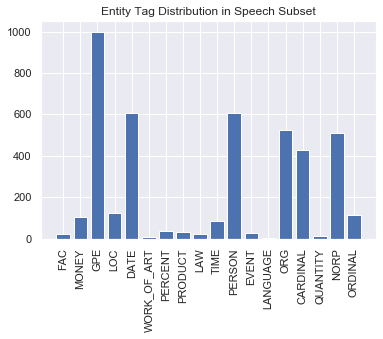

In [256]:
speech_types, speech_type_counts = tag_counts(speech_type_dist)
plt.bar(speech_types, speech_type_counts)
plt.xticks(rotation=90)
plt.title("Entity Tag Distribution in Speech Subset");

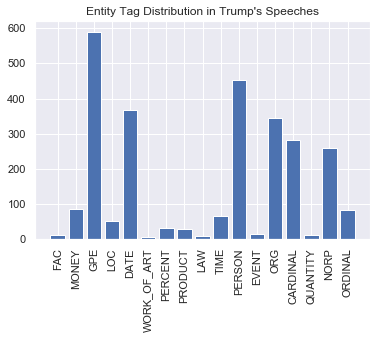

In [257]:
trump_types, trump_type_counts = tag_counts(trump_type_dist)
plt.bar(trump_types, trump_type_counts)
plt.xticks(rotation=90)
plt.title("Entity Tag Distribution in Trump's Speeches");

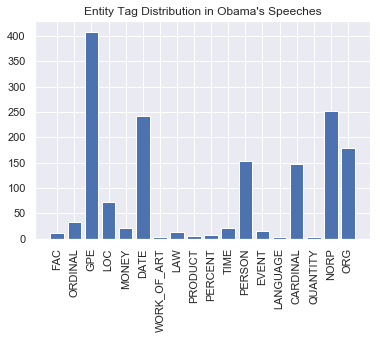

In [258]:
obama_types, obama_type_counts = tag_counts(obama_type_dist)
plt.bar(obama_types, obama_type_counts)
plt.xticks(rotation=90)
plt.title("Entity Tag Distribution in Obama's Speeches");

The figures above suggest that the prevailing types of entity tags in presidential speeches are **"GPE"**, **"PERSON"**, **"DATE"**, **"ORG"**, **"NORP"** and **"CARDINAL"**, indicating geopolitics play a major role in the presidential discourse.

In [259]:
# Define a function that collects tagged entity from given text
def get_tagged_entity(word_list, tag):
    entities = []
    
    for entry in word_list:
        for entity in entry:
            if entity[1] == tag:
                entities.append(entity[0])
                
    return entities

In [260]:
tag = "PERSON"
sub_trump = trump["classified_sents"][17].copy()
trump_names = get_tagged_entity(sub_trump, tag)
trump_names, len(trump_names)

(['Douglas High School', 'Scott', 'Pam Bondi'], 3)

In [261]:
trump_real = [1, 1, 1]

In [262]:
# Define a functin that reports the precision, recall and f-score of the "GPE" category
def cal_stats(real, num):
    predicted = [int(x) for x in list(np.zeros(num)+1)]
    print(sklearn.metrics.classification_report(real, predicted))

In [263]:
cal_stats(trump_real, len(trump_real))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



In [264]:
tag = "PERSON"
sub_obama = obama["classified_sents"][53].copy()
obama_names = get_tagged_entity(sub_obama, tag)
obama_names, len(obama_names)

(['Hillary Clinton',
  'Hillary',
  'Osama bin Laden Laden',
  'bin Laden al Qaeda',
  'Mohammed Bouazizi',
  'Rosa Parks',
  'Tunisia',
  'Muammar Qaddafi',
  'Assad',
  'Assad',
  'Dara’a',
  'Assad',
  'Saleh',
  'n’t'],
 14)

In [265]:
obama_real = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

In [266]:
cal_stats(obama_real, len(obama_real))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.93      1.00      0.96        13

    accuracy                           0.93        14
   macro avg       0.46      0.50      0.48        14
weighted avg       0.86      0.93      0.89        14



As shown by the above statistics, the prediction of person's name on a subset of Trump's and Obama's speeches is relatively precise.

## Dependency parsing and graph representations

**Dependency parsing was developed to robustly capture linguistic dependencies from text.** The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

We will be using spaCy's built in dependancy parser to go about exploring the tree.
Note that unlike previous examples, large corpuses or collections of sentences don't give us as much information, so we will be navigating smaller sentences.

Let us start by exploring noun chunks. **Noun chunks are “base noun phrases” – flat phrases that have a noun as their head.** You can think of noun chunks as a noun plus the words describing the noun – for example, “the lavish green grass” or “the world’s largest tech fund”. To get the noun chunks in a document, simply iterate over the sentences noun chunks.

In [267]:
from spacy import displacy

In [268]:
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")

In [269]:
displacy.render(doc, style='dep')

In [270]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

Autonomous cars cars nsubj shift
insurance liability liability dobj shift
manufacturers manufacturers pobj toward


spaCy uses the terms **head** and **child** to describe the words connected by a single arc in the dependency tree. The term **dep** is used for the arc label, which describes the type of syntactic relation that connects the child to the head. As with other attributes, the value of .dep is a hash value. You can get the string value with .dep_.

For your reference:

**Text**: The original token text.

**Dep**: The syntactic relation connecting child to head.

**Head text**: The original text of the token head.

**Head POS**: The part-of-speech tag of the token head.

**Children**: The immediate syntactic dependents of the token.

In [271]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Autonomous amod cars NOUN []
cars nsubj shift VERB [Autonomous]
shift ROOT shift VERB [cars, liability]
insurance compound liability NOUN []
liability dobj shift VERB [insurance, toward]
toward prep liability NOUN [manufacturers]
manufacturers pobj toward ADP []


Because the syntactic relations form a tree, every word has exactly one head. You can therefore iterate over the arcs in the tree by iterating over the words in the sentence. This is usually the best way to match an arc of interest — from below:

In [272]:
from spacy.symbols import nsubj, VERB

In [273]:
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{shift}


You can *also* navigate from above. It isn't as efficient though.

In [274]:
verbs = []
for possible_verb in doc:
    if possible_verb.pos == VERB:
        for possible_subject in possible_verb.children:
            if possible_subject.dep == nsubj:
                verbs.append(possible_verb)
                break

In [275]:
print(verbs)

[shift]


### Iterating around the local tree
A few more convenience attributes are provided for iterating around the local tree from the token. `Token.lefts` and `Token.rights` attributes provide **sequences of syntactic children** that occur before and after the token. Both sequences are in sentence order. There are also two integer-typed attributes, `Token.n_lefts` and `Token.n_rights` that give the number of left and right children.

In [276]:
doc = nlp("bright red apples on the tree")
print([token.text for token in doc[2].lefts])  # ['bright', 'red']
print([token.text for token in doc[2].rights])  # ['on']
print(doc[2].n_lefts)  # 2
print(doc[2].n_rights)  # 1

['bright', 'red']
['on']
2
1


You can get a whole phrase by its syntactic head using the `Token.subtree` attribute. **This returns an ordered sequence of tokens.** You can walk up the tree with the `Token.ancestors` attribute, and check dominance with `Token.is_ancestor`

In [277]:
doc = nlp("Credit and mortgage account holders must submit their requests")

root = [token for token in doc if token.head == token][0]
subject = list(root.lefts)[0]

print("descendant.text", "descendeant.dep_", "descendant._nlefts", "descendant.n_rights", "[ancestors_text]", sep="\t")

for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors], sep="\t")

descendant.text	descendeant.dep_	descendant._nlefts	descendant.n_rights	[ancestors_text]
Credit	nmod	0	2	['account', 'holders', 'submit']
and	cc	0	0	['Credit', 'account', 'holders', 'submit']
mortgage	conj	0	0	['Credit', 'account', 'holders', 'submit']
account	compound	1	0	['holders', 'submit']
holders	nsubj	1	0	['submit']


In [278]:
help(subject.is_ancestor)

Help on built-in function is_ancestor:

is_ancestor(...) method of spacy.tokens.token.Token instance
    Check whether this token is a parent, grandparent, etc. of another
    in the dependency tree.
    
    descendant (Token): Another token.
    RETURNS (bool): Whether this token is the ancestor of the descendant.
    
    DOCS: https://spacy.io/api/token#is_ancestor



In [279]:
subject

holders

In [280]:
type(subject)

spacy.tokens.token.Token

Finally, the `.left_edge` and `.right_edge` attributes can be especially useful, because **they give you the first and last token of the subtree**. This is the easiest way to create a Span object for a syntactic phrase. Note that `.right_edge` gives a token within the subtree — **so if you use it as the end-point of a range, don’t forget to +1!**

In [281]:
doc

Credit and mortgage account holders must submit their requests

In [282]:
doc[4].left_edge, doc[4].right_edge

(Credit, holders)

In [283]:
span = doc[doc[4].left_edge.i : doc[4].right_edge.i+1]
with doc.retokenize() as retokenizer:
    retokenizer.merge(span)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.head.text)

Credit and mortgage account holders NOUN nsubj submit
must VERB aux submit
submit VERB ROOT submit
their DET poss requests
requests NOUN dobj submit


In [284]:
help(retokenizer.merge)

Help on built-in function merge:

merge(...) method of spacy.tokens._retokenize.Retokenizer instance
    Mark a span for merging. The attrs will be applied to the resulting
    token.
    
    span (Span): The span to merge.
    attrs (dict): Attributes to set on the merged token.
    
    DOCS: https://spacy.io/api/doc#retokenizer.merge



In [285]:
displacy.render(doc, style='dep')

### Information Extraction

How can dependancy graphs be useful? We can extract information from the sentences based on relationships between words within parsed phrases. Let us see if we can do this to glean any information, from, say, our movies dataset. 

How violent are the movies? Who is killing who?

In [286]:
movie_violences = {}

In [287]:
movie_df

Movie Name  \
6850720           Animal Crackers   
176501              Anna Christie   
4056770         Ladies of Leisure   
5992934             Over the Hill   
4436137         Design for Living   
...                           ...   
7045050                The Oscars   
7039258               To the Bone   
6916011             Top Coat Cash   
6973022             Western World   
7017640  Smurfs: The Lost Village   

                                                 Genre  Year          Country  \
6850720                                Comedy, Musical  1930          English   
176501                                  Drama, Romance  1930          English   
4056770                                 Drama, Romance  1930          English   
5992934                                          Drama  1931          English   
4436137                                Comedy, Romance  1933  English, French   
...                                                ...   ...              ...   
7045050                                  Comedy, Music  2017          English   
7039258                                          Drama  2017          English   
6916011                           Action, Crime, Drama  2017          English   
6973022                                        Western  2017          English   
7017640  Animation, Adventure, Comedy, Family, Fantasy  2017          English   

                                           Tokenized Texts  
6850720  [You, must, do, your, best, tonight, Be, on, y...  
176501   [Either, you, 're, flat, or, I, am, I, beg, yo...  
4056770  [Look, out, There, 's, another, bottle, coming...  
5992934  [Good, morning, kitty, Come, in, here, baby, I...  
4436137  [Train_engine_grinding, 26;1426;TOOLONG, Whist...  
...                                                    ...  
7045050  [Hey, Hey, I, got, this, feeling, inside, my, ...  
7039258  [Dr, Branson, please, call, 5914, Dr, Branson,...  
6916011  [Ladies, and, gentleman, it, is, now, time, fo...  
6973022  [I, 'll, see, you, ladies, later, Now, when, I...  
7017640  [This, story, begins, in, a, secret, place, hi...  

[704 rows x 5 columns]

In [288]:
for index, row in movie_df.iterrows():
    text = ' '.join(row['Tokenized Texts'])
    movie_violences[row['Movie Name']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'kill':
            # we find the subjects and objects around the word, 
            # and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                movie_violences[row['Movie Name']][0].append(subject)
            if object_ is not 0:
                movie_violences[row['Movie Name']][1].append(object_)

In [289]:
movie_violences

{'Animal Crackers': ([], []),
 'Anna Christie': (['I', 'I'], ['them', 'you', 'Glory', 'you']),
 'Ladies of Leisure': ([], []),
 'Over the Hill': ([], ['shalt', 'Ma']),
 'Design for Living': ([], []),
 'Lady for a Day': (['It'], ['yourself', 'Louise']),
 'Lady Killer': ([], ['horse']),
 'The Mind Reader': (['woman'], ['herself']),
 'Here Is My Heart': ([], ['herself']),
 'Peculiar Penguins': ([], []),
 'Sadie McKee': (['You', 'I'], ['SOBBING', 'you']),
 'Star of Midnight': (['you', 'I', 'They'],
  ['story', 'him', 'him', 'dal', 'her']),
 'The Littlest Rebel': (['men'], ['army']),
 'The Robber Kitten': ([], []),
 'Charlie Chan at the Circus': ([], []),
 'Charlie Chan at the Opera': (['I'], ['me', 'him', 'you', 'intrusion']),
 'Charlie Chan at the Race Track': (['shoe', 'you'], []),
 'The Prisoner of Shark Island': (['government'], ['what', 'husband']),
 'The Prince and the Pauper': ([], ['me']),
 'The Lady Vanishes': (['They'], ['lot']),
 'Holiday': ([], []),
 "Donald's Cousin Gus": ([],

That's pretty neat: we can see who tried to kill who, or at least talked about it. A lot of 'I' killing 'you', as we'd imagine. What else can we see?

The movie, about time, which is about time travel, funnily enough has:
`'About Time': (['I'], ['Hitler'])`

## <span style="color:red">*Exercise 7*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

In [290]:
from spacy import displacy

In [291]:
# Define a function that constructs the phrase structures
def dependency(word_list):
    for sent in word_list:
        doc = nlp(sent)
        displacy.render(doc, style="dep")

In [292]:
# Choose five sentences from Trump's speeches
trump_subset = trump["script"][17].split(". ")
dependency(trump_subset[15:20])

In [293]:
# Choose five sentences from Obama's speeches
obama_subset = obama["script"][53].split(". ")
dependency(obama_subset[5:10])

As shown in the pictures above, the phrase structures and dependency parse trees are complicatedly nested and the parse depth is highly related to perceived sentence complexity.

In [294]:
# Define a function that extracts noun chunks
def find_noun_chunks(word_list):
    for sent in word_list:
        print()
        doc = nlp(sent)
        for chunk in doc.noun_chunks:
            print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

In [295]:
find_noun_chunks(trump_subset)



Transcript Transcript ROOT Transcript
THE PRESIDENT PRESIDENT appos Transcript
I I nsubj speak
a nation nation pobj to
grief grief pobj in

a school school nsubj became
innocent children children pobj with
caring teachers teachers conj children
the scene scene attr became
terrible violence violence pobj of
hatred hatred conj violence
evil evil conj hatred
2:30 yesterday afternoon afternoon pobj Around
police police nsubj responded
reports reports pobj to
gunfire gunfire pobj of
Marjory Stoneman Douglas High School School pobj at
Parkland Parkland pobj in
Florida Florida appos School
a great and safe community community appos School

a shooter shooter nsubj opened
who who nsubj is
custody custody pobj in
fire fire dobj opened
defenseless students students pobj on
teachers teachers conj students

He He nsubj murdered
17 people people dobj murdered
at least 14 others others dobj wounded
Our entire nation nation nsubj praying
one heavy heart heart pobj with
the victims victims pobj for
t

In [296]:
find_noun_chunks(obama_subset)



Transcript Transcript nsubj Thank
you you dobj Thank
you you dobj Thank
(Applause Applause ROOT Applause
you you dobj Thank
you you dobj Thank
a seat seat dobj have
you you dobj Thank
I I nsubj want
Hillary Clinton Clinton dobj thanking
who who nsubj traveled
she she nsubj approaching
a new landmark landmark dobj approaching
one million frequent flyer miles miles appos landmark
(Laughter Laughter ROOT Laughter
I I nsubj count
Hillary Hillary pobj on
I I nsubj believe
she she nsubj go
the finest Secretaries Secretaries pobj of
State State pobj of
our nation nation pobj in
history history appos Secretaries
The State Department Department nsubj is
a fitting venue venue attr is
a new chapter chapter dobj mark
American diplomacy diplomacy pobj in
six months months pobj For
we we nsubj witnessed
an extraordinary change change dobj witnessed
place place dobj taking
the Middle East East pobj in
North Africa Africa conj East
square, town town pobj by
town town pobj by
country country appos to

He He nsubj have
control control dobj have
his country country pobj over
The opposition opposition nsubj organized
a legitimate and credible Interim Council Council dobj organized
Qaddafi Qaddafi nsubj leaves
power power pobj from
decades decades nsubj come
provocation provocation pobj of
an end end pobj to
the transition transition nsubj proceed
a democratic Libya Libya pobj to
Libya Libya nsubj faced
violence violence dobj faced
the greatest scale scale pobj on
it it nsubj ’s
not the only place place dobj faced
leaders leaders nsubj turned
repression repression pobj to
power power pobj in
the Syrian regime regime nsubj chosen
the path path dobj chosen
murder murder pobj of
the mass arrests arrests conj murder
its citizens citizens pobj of
The United States States nsubj condemned
these actions actions dobj condemned
the international community community pobj with
we we nsubj stepped
our sanctions sanctions dobj stepped
the Syrian regime regime pobj on
sanctions sanctions pobj includin

and European markets markets ROOT markets
the door door dobj open
those countries countries pobj for
who who nsubj adopt
high standards standards dobj adopt
reform and trade liberalization liberalization pobj of
a regional trade arrangement arrangement dobj construct
EU membership membership nsubj served
an incentive incentive pobj as
reform reform pobj for
Europe Europe pobj in
the vision vision nsubj create
a modern and prosperous economy economy pobj of
a powerful force force dobj create
reform reform pobj for
the Middle East East pobj in
North Africa Africa conj East
Prosperity Prosperity nsubj requires
walls walls dobj tearing
the way way pobj in
progress progress pobj of
the corruption corruption dobj requires
elites elites pobj of
who who nsubj steal
their people people pobj from
the red tape tape conj corruption
an idea idea dobj stops
a business business attr becoming
the patronage patronage conj tape
wealth wealth dobj distributes
tribe tribe pobj on
sect sect conj tribe
We W

I I nsubj ’m
the majority majority nsubj look
Israelis Israelis pobj of
Palestinians Palestinians conj Israelis
the future future pobj to
the past past pobj in
We We nsubj see
that spirit spirit nsubjpass killed
the Israeli father father pobj in
whose son son nsubjpass killed
Hamas Hamas pobj by
who who nsubj helped
an organization organization dobj start
Israelis Israelis dobj brought
Palestinians Palestinians conj Israelis
who who nsubj lost
loved ones ones dobj lost
That father father nsubj said
I I nsubj realized
the only hope hope nsubj was
progress progress pobj for
the face face dobj recognize
the conflict conflict pobj of
We We nsubj see
it it dobj see
the actions actions pobj in
a Palestinian Palestinian pobj of
who who nsubj lost
three daughters daughters dobj lost
Israeli shells shells pobj to
Gaza Gaza pobj in
I I nsubj have
the right right dobj have
he he nsubj said
many people people nsubj expecting
me me nsubj hate
My answer answer nsubj is
them them pobj to
I I nsubj ha

In [297]:
# Define a function that extracts all tokens with their children
def find_token_children(word_list):
    print()
    
    for sent in word_list:
        doc = nlp(sent)
        for token in doc:
            print(token.text, token.dep_, token.head.text, token.head.pos_, [child for child in token.children])

In [298]:
find_token_children(trump_subset)



  Transcript PROPN []
Transcript ROOT Transcript PROPN [
, 
, PRESIDENT]

  Transcript PROPN []
THE det PRESIDENT PROPN []
PRESIDENT appos Transcript PROPN [THE, :]
: punct PRESIDENT PROPN []
My poss Americans PROPN []
fellow amod Americans PROPN []
Americans npadvmod speak VERB [My, fellow]
, punct speak VERB []
today npadvmod speak VERB []
I nsubj speak VERB []
speak ROOT speak VERB [Americans, ,, today, I, to]
to prep speak VERB [nation]
a det nation NOUN []
nation pobj to ADP [a, in]
in prep nation NOUN [grief]
grief pobj in ADP []
Yesterday npadvmod became VERB []
, punct became VERB []
a det school NOUN []
school nsubj became VERB [a, filled]
filled acl school NOUN [with]
with prep filled VERB [children]
innocent amod children NOUN []
children pobj with ADP [innocent, and, teachers]
and cc children NOUN []
caring amod teachers NOUN []
teachers conj children NOUN [caring]
became ROOT became VERB [Yesterday, ,, school, scene, .]
the det scene NOUN []
scene attr became VERB [the, 

Soon advmod after ADP []
after prep spoke VERB [Soon, shooting]
the det shooting NOUN []
shooting pobj after ADP [the]
, punct spoke VERB []
I nsubj spoke VERB []
spoke ROOT spoke VERB [after, ,, I, with, convey]
with prep spoke VERB [Scott]
Governor compound Scott PROPN []
Scott pobj with ADP [Governor]
to aux convey VERB []
convey advcl spoke VERB [to, sympathies, to, that]
our poss sympathies NOUN []
deepest amod sympathies NOUN []
sympathies dobj convey VERB [our, deepest]
to prep convey VERB [people]
the det people NOUN []
people pobj to ADP [the, of, and, determination]
of prep people NOUN [Florida]
Florida pobj of ADP []
and cc people NOUN []
our poss determination NOUN []
determination conj people NOUN [our, assist]
to aux assist VERB []
assist acl determination NOUN [to, in]
in prep assist VERB [way]
any det way NOUN []
way pobj in ADP [any]
that dobj convey VERB [can]
we nsubj can VERB []
can aux that DET [we]
I nsubj spoke VERB []
also advmod spoke VERB []
spoke ROOT spoke V

governors conj nation NOUN [and, generals]
and cc governors NOUN []
attorney compound generals NOUN []
generals conj governors NOUN [attorney]
, punct nation NOUN []
where advmod making VERB []
making csubj be AUX [where, safer]
our poss schools NOUN []
schools nsubj safer ADJ [our, and, children]
and cc schools NOUN []
our poss children NOUN []
children conj schools NOUN [our]
safer ccomp making VERB [schools]
will aux be AUX []
be advcl meeting VERB [making, will, priority]
our poss priority NOUN []
top amod priority NOUN []
priority attr be AUX [our, top]
It nsubj is AUX []
is ROOT is AUX [It, not, enough]
not neg is AUX []
enough acomp is AUX [take]
to aux take VERB []
simply advmod take VERB []
take xcomp enough ADJ [to, simply, actions]
actions dobj take VERB [make]
that nsubj make VERB []
make relcl actions NOUN [that, feel]
us nsubj feel VERB []
feel ccomp make VERB [us, making]
like mark making VERB []
we nsubj making VERB []
are aux making VERB []
making advcl feel VERB [like

In [299]:
find_token_children(obama_subset)



  Transcript PROPN []
Transcript nsubj Thank VERB [
, 
]

  Transcript PROPN []
Thank ROOT Thank VERB [Transcript, you, .]
you dobj Thank VERB []
. punct Thank VERB [  ]
    . PUNCT []
Thank ROOT Thank VERB [you, .]
you dobj Thank VERB []
. punct Thank VERB [  ]
    . PUNCT []
( punct Applause PROPN []
Applause ROOT Applause PROPN [(, ., )]
. punct Applause PROPN []
) punct Applause PROPN [  ]
    ) PUNCT []
Thank ROOT Thank VERB [you, much, .]
you dobj Thank VERB []
very advmod much ADV []
much advmod Thank VERB [very]
. punct Thank VERB [  ]
    . PUNCT []
Thank ROOT Thank VERB [you, .]
you dobj Thank VERB []
. punct Thank VERB [  ]
    . PUNCT []
Please intj have AUX []
, punct have AUX []
have ROOT have AUX [Please, ,, seat, .]
a det seat NOUN []
seat dobj have AUX [a]
. punct have AUX [  ]
    . PUNCT []
Thank ROOT Thank VERB [you, much, .]
you dobj Thank VERB []
very advmod much ADV []
much advmod Thank VERB [very]
. punct Thank VERB [  ]
    . PUNCT []
I nsubj want VERB []
wan

murderous amod vision NOUN []
vision conj Laden PROPN [his, murderous]
won ROOT won VERB [Laden, adherents, .]
some det adherents NOUN []
adherents dobj won VERB [some]
. punct won VERB [  ]
    . PUNCT []
But cc losing VERB []
even advmod before ADP []
before prep losing VERB [even, death]
his poss death NOUN []
death pobj before ADP [his]
, punct losing VERB []
al compound Qaeda PROPN []
Qaeda nsubj losing VERB [al]
was aux losing VERB []
losing ROOT losing VERB [But, before, ,, Qaeda, was, struggle, ,, saw, .]
its poss struggle NOUN []
struggle dobj losing VERB [its, for]
for prep struggle NOUN [relevance]
relevance pobj for ADP []
, punct losing VERB []
as mark saw VERB []
the det majority NOUN []
overwhelming amod majority NOUN []
majority nsubj saw VERB [the, overwhelming, of]
of prep majority NOUN [people]
people pobj of ADP []
saw advcl losing VERB [as, majority, answer]
that mark answer VERB []
the det slaughter NOUN []
slaughter nsubj answer VERB [the, of]
of prep slaughter N

long advmod ago ADV []
ago advmod won VERB [long]
, punct won VERB []
but cc won VERB []
in prep did AUX [places]
too advmod many ADJ []
many amod places NOUN [too]
places pobj in ADP [many]
their poss people NOUN []
people nsubj did AUX [their]
did conj won VERB [in, people, not, .]
not neg did AUX []
. punct did AUX [  ]
    . PUNCT []
In prep concentrated VERB [countries]
too advmod many ADJ []
many amod countries NOUN [too]
countries pobj In ADP [many]
, punct concentrated VERB []
power nsubjpass concentrated VERB []
has aux concentrated VERB []
been auxpass concentrated VERB []
concentrated ROOT concentrated VERB [In, ,, power, has, been, in, .]
in prep concentrated VERB [hands]
the det hands NOUN []
hands pobj in ADP [the, of]
of prep hands NOUN [few]
a det few ADJ []
few pobj of ADP [a]
. punct concentrated VERB [  ]
    . PUNCT []
In prep had AUX [countries]
too advmod many ADJ []
many amod countries NOUN [too]
countries pobj In ADP [many, ,, citizen]
, punct countries NOUN []


six nummod months NOUN []
months pobj in ADP [six, accomplished]
than mark accomplished VERB []
terrorists nsubj accomplished VERB []
have aux accomplished VERB []
accomplished advcl months NOUN [than, terrorists, have, in]
in prep accomplished VERB [decades]
decades pobj in ADP []
. punct achieved VERB [
]

  . PUNCT []
Of advmod course ADV []
course advmod come VERB [Of]
, punct come VERB []
change nsubj come VERB [of]
of prep change NOUN [magnitude]
this det magnitude NOUN []
magnitude pobj of ADP [this]
does aux come VERB []
not neg come VERB []
come ROOT come VERB [course, ,, change, does, not, easily, .]
easily advmod come VERB []
. punct come VERB [  ]
    . PUNCT []
In ROOT In ADP [day, time]
our poss day NOUN []
day pobj In ADP [our, and, age]
and cc day NOUN []
age conj day NOUN []
- punct time NOUN []
– punct time NOUN []
a det time NOUN []
time intj In ADP [-, –, a, of]
of prep time NOUN [cycles]
24-hour amod cycles NOUN []
news compound cycles NOUN []
cycles pobj of ADP [2

. punct keep VERB [
]

  . PUNCT []
Yet cc acknowledge VERB []
we nsubj acknowledge VERB []
must aux acknowledge VERB []
acknowledge ROOT acknowledge VERB [Yet, we, must, fill, .]
that mark fill VERB []
a det strategy NOUN []
strategy nsubj fill VERB [a, based]
based acl strategy NOUN [upon]
solely advmod upon SCONJ []
upon prep based VERB [solely, pursuit]
the det pursuit NOUN []
narrow amod pursuit NOUN []
pursuit pobj upon SCONJ [the, narrow, of]
of prep pursuit NOUN [interests]
these det interests NOUN []
interests pobj of ADP [these]
will aux fill VERB []
not neg fill VERB []
fill ccomp acknowledge VERB [that, strategy, will, not, stomach, or, allow]
an det stomach NOUN []
empty amod stomach NOUN []
stomach dobj fill VERB [an, empty]
or cc fill VERB []
allow conj fill VERB [speak]
someone nsubj speak VERB []
to aux speak VERB []
speak ccomp allow VERB [someone, to, mind]
their poss mind NOUN []
mind dobj speak VERB [their]
. punct acknowledge VERB [  ]
    . PUNCT []
Moreover advm

- punct put VERB []
– punct was AUX []
it nsubj was AUX []
was ROOT was AUX [’s, –, it, people, ,, and, it, .]
the det people NOUN []
people attr was AUX [the, themselves, launched]
themselves appos people NOUN []
who nsubj launched VERB []
launched relcl people NOUN [who, movements]
these det movements NOUN []
movements dobj launched VERB [these]
, punct was AUX []
and cc was AUX []
it conj was AUX [’s, people]
’s punct it PRON []
the det people NOUN []
people appos it PRON [the, themselves, determine]
themselves appos people NOUN []
that nsubj determine VERB []
must aux determine VERB []
ultimately advmod determine VERB []
determine relcl people NOUN [that, must, ultimately, outcome]
their poss outcome NOUN []
outcome dobj determine VERB [their]
. punct was AUX [ 
]
 
  . PUNCT []
Not neg country NOUN []
every det country NOUN []
country nsubj follow VERB [Not, every]
will aux follow VERB []
follow ROOT follow VERB [country, will, form, ,, and, be]
our poss form NOUN []
particular am

He nsubj have AUX []
does aux have AUX []
not neg have AUX []
have ROOT have AUX [He, does, not, control, .]
control dobj have AUX [over]
over prep control NOUN [country]
his poss country NOUN []
country pobj over ADP [his]
. punct have AUX [  ]
    . PUNCT []
The det opposition NOUN []
opposition nsubj organized VERB [The]
has aux organized VERB []
organized ROOT organized VERB [opposition, has, Council, .]
a det Council PROPN []
legitimate amod Council PROPN [and, credible]
and cc legitimate ADJ []
credible conj legitimate ADJ []
Interim compound Council PROPN []
Council dobj organized VERB [a, legitimate, Interim]
. punct organized VERB [  ]
    . PUNCT []
And cc come VERB []
when advmod leaves VERB []
Qaddafi nsubj leaves VERB []
inevitably advmod leaves VERB []
leaves advcl come VERB [when, Qaddafi, inevitably, or, forced]
or cc leaves VERB []
is auxpass forced VERB []
forced conj leaves VERB [is, from]
from prep forced VERB [power]
power pobj from ADP []
, punct come VERB []
deca

the det people NOUN []
Iranian amod people NOUN []
people nsubj deserve VERB [the, Iranian]
deserve ccomp insist VERB [that, people, rights, ,, and, government]
their poss rights NOUN []
universal amod rights NOUN []
rights dobj deserve VERB [their, universal]
, punct deserve VERB []
and cc deserve VERB []
a det government NOUN []
government conj deserve VERB [a, smother]
that nsubj smother VERB []
does aux smother VERB []
not neg smother VERB []
smother relcl government NOUN [that, does, not, aspirations]
their poss aspirations NOUN []
aspirations dobj smother VERB [their]
. punct continue VERB [
]

  . PUNCT []
Now advmod is AUX []
, punct is AUX []
our poss opposition NOUN []
opposition nsubj is AUX [our, to, ’s, measures, ,, as, program]
to prep opposition NOUN [Iran]
Iran pobj to ADP [’s, intolerance]
’s punct Iran PROPN []
intolerance conj Iran PROPN [and, Iran]
and cc intolerance NOUN []
Iran conj intolerance NOUN []
’s punct opposition NOUN []
repressive amod measures NOUN []
m

to prep lead VERB [conflict]
conflict pobj to ADP []
. punct is AUX [  ]
    . PUNCT []
In prep see VERB [Iraq]
Iraq pobj In ADP []
, punct see VERB []
we nsubj see VERB []
see ROOT see VERB [In, ,, we, promise, .]
the det promise NOUN []
promise dobj see VERB [the, of]
of prep promise NOUN [democracy]
a det democracy NOUN []
multiethnic amod democracy NOUN []
, punct democracy NOUN []
multisectarian amod democracy NOUN []
democracy pobj of ADP [a, multiethnic, ,, multisectarian]
. punct see VERB [  ]
    . PUNCT []
The det people NOUN []
Iraqi amod people NOUN []
people nsubj rejected VERB [The, Iraqi]
have aux rejected VERB []
rejected ROOT rejected VERB [people, have, perils, in, ,, taken, .]
the det perils NOUN []
perils dobj rejected VERB [the, of]
of prep perils NOUN [violence]
political amod violence NOUN []
violence pobj of ADP [political]
in prep rejected VERB [favor]
favor pobj in ADP [of]
of prep favor NOUN [process]
a det process NOUN []
democratic amod process NOUN []
proc

  . PUNCT []
Such amod discourse NOUN []
open amod discourse NOUN []
discourse nsubj is AUX [Such, open]
is ROOT is AUX [discourse, important, square, .]
important acomp is AUX []
even advmod square VERB []
if mark square VERB []
what nsubjpass said VERB []
is auxpass said VERB []
said csubj square VERB [what, is]
does aux square VERB []
not neg square VERB []
square advcl is AUX [even, if, said, does, not, with]
with prep square VERB [worldview]
our poss worldview NOUN []
worldview pobj with ADP [our]
. punct is AUX [  ]
    . PUNCT []
Let advcl respects VERB [be]
me nsubj be AUX []
be ccomp Let VERB [me, clear]
clear acomp be AUX []
, punct respects VERB []
America nsubj respects VERB []
respects ROOT respects VERB [Let, ,, America, right, ,, disagree, .]
the det right NOUN []
right dobj respects VERB [the, of, heard]
of prep right NOUN [voices]
all det voices NOUN []
peaceful amod voices NOUN [and, abiding]
and cc peaceful ADJ []
law npadvmod abiding VERB []
- punct abiding VERB []


way nsubj is AUX [the, second, support]
that advmod support VERB []
we nsubj support VERB []
must aux support VERB []
support relcl way NOUN [that, we, must, change]
positive amod change NOUN []
change dobj support VERB [positive, in]
in prep change NOUN [region]
the det region NOUN []
region pobj in ADP [the]
is ROOT is AUX [So, way, through, .]
through prep is AUX [efforts]
our poss efforts NOUN []
efforts pobj through ADP [our, advance]
to aux advance VERB []
advance acl efforts NOUN [to, development]
economic amod development NOUN []
development dobj advance VERB [economic, for]
for prep development NOUN [nations]
nations pobj for ADP [transitioning]
that nsubj transitioning VERB []
are aux transitioning VERB []
transitioning relcl nations NOUN [that, are, to]
to prep transitioning VERB [democracy]
democracy pobj to ADP []
. punct is AUX [ 
]
 
  . PUNCT []
After advmod all ADV []
all advmod put VERB [After]
, punct put VERB []
politics nsubj put VERB [alone]
alone advmod politics 

of prep economies NOUN [Tunisia]
Tunisia pobj of ADP [and, Egypt]
and cc Tunisia PROPN []
Egypt conj Tunisia PROPN []
. punct asked VERB [  ]
    . PUNCT []
Together advmod help VERB []
, punct help VERB []
we nsubj help VERB []
must aux help VERB []
help ROOT help VERB [Together, ,, we, must, recover, ,, and, support, .]
them nsubj recover VERB []
recover ccomp help VERB [them, from]
from prep recover VERB [disruptions]
the det disruptions NOUN []
disruptions pobj from ADP [the, of]
of prep disruptions NOUN [upheaval]
their poss upheaval NOUN []
democratic amod upheaval NOUN []
upheaval pobj of ADP [their, democratic]
, punct help VERB []
and cc help VERB []
support conj help VERB [governments]
the det governments NOUN []
governments dobj support VERB [the, elected]
that nsubjpass elected VERB []
will aux elected VERB []
be auxpass elected VERB []
elected relcl governments NOUN [that, will, be, year]
later advmod year NOUN []
this det year NOUN []
year npadvmod elected VERB [later, th

and cc markets NOUN []
European amod markets NOUN []
markets ROOT markets NOUN [and, European, ,, and, open, .]
, punct markets NOUN []
and cc markets NOUN []
open conj markets NOUN [door, for]
the det door NOUN []
door dobj open VERB [the]
for prep open VERB [countries]
those det countries NOUN []
countries pobj for ADP [those, adopt]
who nsubj adopt VERB []
adopt relcl countries NOUN [who, standards, construct]
high amod standards NOUN []
standards dobj adopt VERB [high, of]
of prep standards NOUN [liberalization]
reform nmod liberalization NOUN [and, trade]
and cc reform NOUN []
trade conj reform NOUN []
liberalization pobj of ADP [reform]
to aux construct VERB []
construct advcl adopt VERB [to, arrangement]
a det arrangement NOUN []
regional amod arrangement NOUN []
trade compound arrangement NOUN []
arrangement dobj construct VERB [a, regional, trade]
. punct markets NOUN [  ]
    . PUNCT []
And cc create VERB []
just advmod served VERB []
as mark served VERB []
EU compound member

sees conj looks VERB [nothing]
nothing dobj sees VERB [but]
but prep nothing PRON [stalemate]
stalemate pobj but SCONJ []
. punct looks VERB [  ]
    . PUNCT []
Indeed advmod are AUX []
, punct are AUX []
there expl are AUX []
are ROOT are AUX [Indeed, ,, there, those, .]
those attr are AUX [argue]
who nsubj argue VERB []
argue relcl those DET [who, is]
that mark is AUX []
with prep is AUX [change]
all predet change NOUN []
the det change NOUN []
change pobj with ADP [all, the, and, uncertainty, in]
and cc change NOUN []
uncertainty conj change NOUN []
in prep change NOUN [region]
the det region NOUN []
region pobj in ADP [the]
, punct is AUX []
it nsubj is AUX []
is ccomp argue VERB [that, with, ,, it, simply, not, possible, move]
simply advmod is AUX []
not neg is AUX []
possible acomp is AUX []
to aux move VERB []
move xcomp is AUX [to, forward, now]
forward advmod move VERB []
now advmod move VERB []
. punct are AUX [
]

  . PUNCT []
I nsubj disagree VERB []
disagree ROOT disagree 

. punct believe VERB [  ]
    . PUNCT []
The det community NOUN []
international amod community NOUN []
community nsubj is AUX [The, international]
is ROOT is AUX [community, tired]
tired acomp is AUX [of]
of prep tired ADJ [process]
an det process NOUN []
endless amod process NOUN []
process pobj of ADP [an, endless, produces]
that nsubj produces VERB []
never neg produces VERB []
produces relcl process NOUN [that, never, outcome]
an det outcome NOUN []
outcome dobj produces VERB [an]
The det dream NOUN []
dream nsubjpass fulfilled VERB [The, of]
of prep dream NOUN [state]
a det state NOUN []
Jewish amod state NOUN [and, democratic]
and cc Jewish ADJ []
democratic conj Jewish ADJ []
state pobj of ADP [a, Jewish]
can aux fulfilled VERB []
not neg fulfilled VERB []
be auxpass fulfilled VERB []
fulfilled ROOT fulfilled VERB [dream, can, not, be, with, .]
with prep fulfilled VERB [occupation]
permanent amod occupation NOUN []
occupation pobj with ADP [permanent]
. punct fulfilled VERB [
]

Recognizing acl this DET [need]
that mark need VERB []
negotiations nsubj need VERB []
need ccomp Recognizing VERB [that, negotiations, begin]
to aux begin VERB []
begin xcomp need VERB [to, with]
with prep begin VERB [issues]
the det issues NOUN []
issues pobj with ADP [the, of]
of prep issues NOUN [territory]
territory pobj of ADP [and, security]
and cc territory NOUN []
security conj territory NOUN []
does aux mean VERB []
not neg mean VERB []
mean ROOT mean VERB [does, not, be, .]
that mark be AUX []
it nsubj be AUX []
will aux be AUX []
be ccomp mean VERB [that, it, will, easy]
easy acomp be AUX [come]
to aux come VERB []
come xcomp easy ADJ [to, back]
back advmod come VERB [to]
to prep back ADV [table]
the det table NOUN []
table pobj to ADP [the]
. punct mean VERB [  ]
    . PUNCT []
In prep raises VERB [particular]
particular amod In ADP []
, punct raises VERB []
the det announcement NOUN []
recent amod announcement NOUN []
announcement nsubj raises VERB [the, recent, of]
of pr

make advcl protesting VERB [to, words]
real amod words NOUN []
those det words NOUN []
words dobj make VERB [real, those, declared]
that nsubj declared VERB []
declared relcl words NOUN [that, nation]
our poss nation NOUN []
nation dobj declared VERB [our]
: punct turned VERB [  ]
    : PUNCT []
“ punct hold VERB []
We nsubj hold VERB []
hold ROOT hold VERB [“, We, truths, be, ,, created, ., ”]
these det truths NOUN []
truths dobj hold VERB [these]
to aux be AUX []
be xcomp hold VERB [to, evident]
self npadvmod evident ADJ []
- punct evident ADJ []
evident acomp be AUX [self, -]
, punct hold VERB []
that mark created VERB []
all det men NOUN []
men nsubjpass created VERB [all]
are auxpass created VERB []
created ccomp hold VERB [that, men, are, equal]
equal oprd created VERB []
. punct hold VERB []
” punct hold VERB [ 
]
 
  ” PUNCT []
Those det words NOUN []
words nsubj guide VERB [Those]
must aux guide VERB []
guide ROOT guide VERB [words, must, response, -, –, words, ,, and, fall]
o

In [300]:
help(spacy.symbols)

Help on module spacy.symbols in spacy:

NAME
    spacy.symbols

FUNCTIONS
    sort_nums(...)

DATA
    0
    ADJ = 84
    ADP = 85
    ADV = 86
    AUX = 87
    Abbr_yes = 239
    AdpType_circ = 244
    AdpType_comprep = 243
    AdpType_post = 241
    AdpType_prep = 240
    AdpType_voc = 242
    AdvType_adadj = 253
    AdvType_cau = 249
    AdvType_deg = 248
    AdvType_ex = 252
    AdvType_loc = 246
    AdvType_man = 245
    AdvType_mod = 250
    AdvType_sta = 251
    AdvType_tim = 247
    Animacy_anim = 104
    Animacy_hum = 106
    Animacy_inam = 105
    Animacy_nhum = 107
    Aspect_freq = 108
    Aspect_hab = 114
    Aspect_imp = 109
    Aspect_iter = 113
    Aspect_mod = 110
    Aspect_none = 111
    Aspect_perf = 112
    CARDINAL = 397
    CCONJ = 89
    CLUSTER = 72
    CONJ = 88
    Case_abe = 115
    Case_abl = 116
    Case_abs = 117
    Case_acc = 118
    Case_ade = 119
    Case_all = 120
    Case_cau = 121
    Case_cmp = 123
    Case_com = 122
    Case_dat = 124
    Case_de

In [301]:
# Define a functin that finds verbs associating with nominal subjects
from spacy.symbols import nsubj, VERB

def find_nsubj_verb(word_list):
    verb_subj = []
    
    for sent in word_list:
        doc = nlp(sent)
        for possible_verb in doc:
            if possible_verb.pos == VERB:
                for possible_subject in possible_verb.children:
                    if possible_subject.dep == nsubj:
                        verb_subj.append(possible_verb)                      
    return verb_subj

In [302]:
trump_subset_verbs1 = find_nsubj_verb(trump_subset)
trump_subset_verbs1

[speak,
 became,
 responded,
 opened,
 murdered,
 praying,
 hurting,
 need,
 kiss,
 meant,
 mourn,
 lost,
 comfort,
 hurt,
 responded,
 thank,
 spoke,
 can,
 spoke,
 making,
 hold,
 heard,
 heal,
 trust,
 hold,
 want,
 feel,
 want,
 know,
 care,
 love,
 need,
 hate,
 work,
 embraces,
 creates,
 turns,
 working,
 can,
 meeting,
 make,
 feel,
 making,
 make,
 sustain,
 grow,
 hold,
 pray,
 come,
 Bless]

In [303]:
obama_subset_verbs1 = find_nsubj_verb(obama_subset)
obama_subset_verbs1

[Thank,
 want,
 traveled,
 approaching,
 count,
 believe,
 go,
 witnessed,
 risen,
 stepped,
 follow,
 know,
 want,
 driving,
 respond,
 advances,
 done,
 removed,
 broken,
 begin,
 dealt,
 offered,
 rejected,
 focused,
 destroy,
 build,
 won,
 losing,
 saw,
 answer,
 found,
 come,
 taken,
 began,
 confiscated,
 ’s,
 takes,
 deny,
 happened,
 refused,
 went,
 spark,
 speak,
 building,
 refused,
 sat,
 tapped,
 took,
 refused,
 left,
 followed,
 come,
 won,
 choose,
 will,
 applied,
 led,
 comes,
 reach,
 start,
 tried,
 became,
 show,
 work,
 provide,
 allow,
 connect,
 emerged,
 tell,
 heard,
 said,
 breathe,
 breathe,
 heard,
 chanted,
 come,
 heard,
 said,
 ’s,
 explain,
 heard,
 said,
 feel,
 achieved,
 accomplished,
 come,
 expect,
 reaches,
 give,
 play,
 unfolds,
 pursued,
 continue,
 ’re,
 believe,
 benefits,
 believe,
 see,
 crippled,
 tolerate,
 keep,
 acknowledge,
 fill,
 speak,
 feed,
 festered,
 pursues,
 runs,
 killed,
 threatens,
 began,
 believed,
 believe,
 held,
 offe

In [304]:
# Define a function that finds verbs associating with a noun phrase which is syntatic subject to a passive clause
from spacy.symbols import nsubjpass, VERB

def find_passive_noun_verb(word_list):
    verb = []
    for sent in word_list:
        doc = nlp(sent)
        for possible_verb in doc:
            if possible_verb.pos == VERB:
                for possible_nsubjpass in possible_verb.children:
                    if possible_nsubjpass.dep == nsubjpass:
                        verb.append(possible_verb)
    return verb

In [305]:
trump_subset_verbs2 = find_passive_noun_verb(trump_subset)
trump_subset_verbs2

[joined, stolen]

In [306]:
obama_subset_verbs2 = find_passive_noun_verb(obama_subset)
obama_subset_verbs2

[bound,
 devastated,
 concentrated,
 blessed,
 based,
 blamed,
 manipulated,
 denied,
 heard,
 resolved,
 seen,
 seared,
 built,
 translated,
 answered,
 killed,
 seared,
 poised,
 sanctioned,
 hidden,
 said,
 respected,
 built,
 empowered,
 prevented,
 triggered,
 based,
 elected,
 saddled,
 needed,
 stolen,
 modeled,
 blown,
 taught,
 rooted,
 fulfilled,
 imposed,
 negotiated,
 based,
 established,
 coordinated,
 agreed,
 demonstrated,
 met,
 passed,
 killed,
 killed,
 made,
 made,
 claimed,
 founded,
 enslaved,
 created,
 endowed,
 founded]

In [307]:
# Define a function that finds adjectives associating with an adverbial modifier
from spacy.symbols import advmod, ADJ

def find_adv_adj(word_list):
    adv_adj = []
    for sent in word_list:
        doc = nlp(sent)
        for possible_adj in doc:
            if possible_adj.pos == ADJ:
                for possible_adv in possible_adj.children:
                    if possible_adv.dep == advmod:
                        adv_adj.append((possible_adv, possible_adj))
    return adv_adj

In [308]:
trump_subset_adv_adj1 = find_adv_adj(trump_subset)
trump_subset_adv_adj1

[(at, least), (even, scared), (even, stronger), (much, better)]

In [309]:
obama_subset_adv_adj1 = find_adv_adj(obama_subset)
obama_subset_adv_adj1

[(particularly, active),
 (too, many),
 (too, many),
 (too, many),
 (too, many),
 (too, many),
 (most, extreme),
 (just, costly),
 (how, costly),
 (particularly, young),
 (particularly, important),
 (more, prosperous),
 (more, peaceful),
 (so, many),
 (more, constant),
 (Too, many),
 (greatest, untapped),
 (newly, democratic),
 (more, urgent),
 (certainly, true),
 (enough, robust),
 (how, hard),
 (more, peaceful),
 (more, stable)]

In [310]:
# Define a function that finds verbs associating with a object
from spacy.symbols import dobj, VERB

def find_verb_obj(word_list):
    verb_dobj = []
    for sent in word_list:
        doc = nlp(sent)
        for possible_verb in doc:
            if possible_verb.pos == VERB:
                for possible_obj in possible_verb.children:
                    if possible_obj.dep == dobj:
                        verb_dobj.append((possible_verb, possible_obj))
    return verb_dobj

In [311]:
trump_subset_verb_obj = find_verb_obj(trump_subset)
trump_subset_verb_obj

[(opened, fire),
 (murdered, people),
 (wounded, others),
 (need, whatever),
 (ease, pain),
 (kiss, them),
 (meant, everything),
 (lost, lives),
 (comfort, grieving),
 (thank, you),
 (convey, sympathies),
 (convey, that),
 (making, plans),
 (visit, Parkland),
 (coordinating, response),
 (hold, word),
 (heard, prayer),
 (seen, tears),
 (heal, you),
 (love, you),
 (protect, you),
 (need, help),
 (answer, cruelty),
 (create, culture),
 (embraces, dignity),
 (creates, connections),
 (turns, classmates),
 (investigate, shooting),
 (learn, everything),
 (secure, schools),
 (tackle, issue),
 (take, actions),
 (making, difference),
 (make, difference),
 (sustain, us),
 (wipe, tears),
 (Thank, you),
 (Bless, you),
 (Thank, you)]

In [312]:
obama_subset_verb_obj = find_verb_obj(obama_subset)
obama_subset_verb_obj

[(Thank, you),
 (Thank, you),
 (Thank, you),
 (Thank, you),
 (Thank, you),
 (thanking, Clinton),
 (approaching, landmark),
 (mark, chapter),
 (witnessed, change),
 (taking, place),
 (demand, rights),
 (driving, it),
 (advances, values),
 (strengthens, security),
 (done, much),
 (shift, policy),
 (removed, troops),
 (ended, mission),
 (broken, momentum),
 (bring, troops),
 (continue, transition),
 (dealt, blow),
 (killing, leader),
 (offered, message),
 (take, arms),
 (rejected, democracy),
 (destroy, what),
 (build, what),
 (won, adherents),
 (losing, struggle),
 (answer, cries),
 (found, Laden),
 (taken, future),
 (confiscated, cart),
 (takes, place),
 (deny, dignity),
 (hear, complaints),
 (doused, himself),
 (lit, himself),
 (spark, movements),
 (pay, taxes),
 (left, power),
 (won, independence),
 (turn, judiciary),
 (hear, case),
 (give, voice),
 (represent, views),
 (choose, leader),
 (make, life),
 (will, what),
 (applied, economy),
 (reach, potential),
 (start, business),
 (payi

In [313]:
# Define a function that finds adverbs associating with adverbial modifiers
from spacy.symbols import advmod, ADV
def find_adv_adv(word_list):
    adv_adv = []
    for sent in word_list:
        doc = nlp(sent)
        for possible_adv1 in doc:
            if possible_adv1.pos == ADV:
                for possible_adv2 in possible_adv1.children:
                    if possible_adv2.dep == advmod:
                        adv_adv.append((possible_adv2, possible_adv1))
    return adv_adv

In [314]:
trump_adv_adv = find_adv_adv(trump_subset)
trump_adv_adv

[(so, badly), (so, bravely), (at, all), (so, always), (very, much)]

In [315]:
obama_adv_adv = find_adv_adv(obama_subset)
obama_adv_adv

[(very, much),
 (very, much),
 (so, much),
 (long, ago),
 (as, well),
 (Of, course),
 (Of, course),
 (thus, far),
 (Most, recently),
 (So, far),
 (Of, course),
 (After, all),
 (more, just),
 (very, much)]

In [316]:
# Defind a function that extracts information from presidential speech on "love" and "hate"
def extract_info(df, kwd):
    result_info = {}
    for index, row in df.iterrows():
        text = " ".join(row["tokens"])
        result_info[row["title"]] = ([], [])
        doc = nlp(text)
        for chunk in doc.noun_chunks:
            subject = 0
            object_ = 0
            if chunk.root.head.text == kwd:
                if chunk.root.dep_ == "nsubj":
                    subject = chunk.root.text
                if chunk.root.dep_ == "dobj":
                    object_ = chunk.root.text
                if subject is not 0:
                    result_info[row["title"]][0].append(subject)
                if object_ is not 0:
                    result_info[row["title"]][1].append(object_)
    return result_info

In [317]:
trump_love_info = extract_info(trump, "love")
trump_love_info

{'February 6, 2020: Remarks after HIs Acquittal \n': (['I',
   'I',
   'they',
   'I',
   'people',
   'They',
   'we',
   'I',
   'We',
   'I'],
  ['it', 'it', 'it', 'it', 'Jordan', 'you', 'Post', 'Texas', 'FBI']),
 'February 15, 2019: Speech Declaring a National Emergency\n': (['I',
   'they',
   'I',
   'I'],
  ['you', 'country', 'you', 'tariffs', 'them']),
 'December 18, 2017: Remarks on National Security Strategy\n': (['We'], []),
 'February 5, 2019: State of the Union Address\n': ([], []),
 'July 24, 2018: Speech at the Veterans of Foreign Wars National Convention\n': ([],
  []),
 'September 24, 2019: Remarks at the United Nations General Assembly\n': (['peace',
   'who'],
  ['nation', 'it']),
 'March 13, 2020: Press Conference about the Coronavirus\n': (['who', 'we'],
  ['them']),
 'September 25, 2018: Address at the 73rd Session of the United Nations General Assembly\n': (['we'],
  ['country']),
 'January 3, 2020: Remarks on the Killing of Qasem Soleimani\n': ([], []),
 'Februa

In [318]:
trump_hate_info = extract_info(trump, "hate")
trump_hate_info

{'February 6, 2020: Remarks after HIs Acquittal \n': (['I'], []),
 'February 15, 2019: Speech Declaring a National Emergency\n': ([], []),
 'December 18, 2017: Remarks on National Security Strategy\n': ([], []),
 'February 5, 2019: State of the Union Address\n': ([], []),
 'July 24, 2018: Speech at the Veterans of Foreign Wars National Convention\n': ([],
  []),
 'September 24, 2019: Remarks at the United Nations General Assembly\n': ([],
  []),
 'March 13, 2020: Press Conference about the Coronavirus\n': ([], []),
 'September 25, 2018: Address at the 73rd Session of the United Nations General Assembly\n': ([],
  []),
 'January 3, 2020: Remarks on the Killing of Qasem Soleimani\n': ([], []),
 'February 15, 2018: Statement on the School Shooting in Parkland, Florida\n': (['Answer'],
  [])}

In [319]:
obama_love_info = extract_info(obama, "love")
obama_love_info

{'December 10, 2009: Acceptance of Nobel Peace Prize\n': ([], []),
 'May 19, 2011: Speech on American Diplomacy in the Middle East and North Africa\n': ([],
  []),
 'October 21, 2011: Remarks on the End of the War in Iraq\n': ([], []),
 'September 23, 2010: Address to the United Nations\n': ([], []),
 'January 12, 2011: Remarks at Memorial for Victims of the Tucson, AZ Shooting\n': (['we',
   'He'],
  ['her']),
 'May 26, 2009: Remarks on Nominating Judge Sonia Sotomayor to the U.S. Supreme Court\n': ([],
  []),
 'September 9, 2009: Address to Congress on Health Care\n': ([], []),
 'January 21, 2013: Second Inaugural Address\n': ([], []),
 'May 25, 2011: Address to the British Parliament\n': ([], []),
 'September 8, 2011: Address to Congress on the American Jobs Act\n': ([], [])}

In [320]:
obama_hate_info = extract_info(obama, "hate")
obama_hate_info

{'December 10, 2009: Acceptance of Nobel Peace Prize\n': ([], []),
 'May 19, 2011: Speech on American Diplomacy in the Middle East and North Africa\n': (['me',
   'I'],
  ['them']),
 'October 21, 2011: Remarks on the End of the War in Iraq\n': ([], []),
 'September 23, 2010: Address to the United Nations\n': ([], []),
 'January 12, 2011: Remarks at Memorial for Victims of the Tucson, AZ Shooting\n': ([],
  []),
 'May 26, 2009: Remarks on Nominating Judge Sonia Sotomayor to the U.S. Supreme Court\n': ([],
  []),
 'September 9, 2009: Address to Congress on Health Care\n': ([], []),
 'January 21, 2013: Second Inaugural Address\n': ([], []),
 'May 25, 2011: Address to the British Parliament\n': ([], []),
 'September 8, 2011: Address to Congress on the American Jobs Act\n': ([], [])}

The analysis on a focal set of words and the information we might extract highly depends on the topic the president addressed. Unfortunately, due to the limited sample size, there is barely something valuable. 

However, by searching the keyword "love" in Trump's speeches, I find the speech he gave on February 15, 2019, named *Speech Declaring a National Emergency* utilized the pharase "I love tariffs", which clearly indicates his anti-globalization attitude.

# Distributional distances

**If we want to compare different corpora, we need a distance or divergence that compares the two distributions.**

We will use the: 

+ Kullback-Leibler (KL) divergence
+ $\chi^2$ divergence
+ Kolmogorov-Smirnov (KS) distance
+ Wasserstein distance

### Kullback-Leibler and $x^2$ divergences ###

KL and $\chi^2$ divergences are members of the broader <a "href=https://en.wikipedia.org/wiki/F-divergence" target="_blank">$f$-divergence</a> family, a function of $D_f (P || Q)$ that calculates the difference between two probability distributions P and Q. The KL $f(t)$ is $ t \text{ log } t $, while the $\chi^2$ is $t^2-1$. **KL comes from information and $\chi^2$ from measure theory. As such, the KL divergence computes the relative entropy between two distributions--how they differ in bits, while the $\chi^2$ whether the same statistical inferences can be drawn from them both.**

Specifically, given two discrete probability distributions $P$ and $Q$, the Kullback-Leibler divergence from $Q$ to $P$ is defined as:

$D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \log\frac{P(i)}{Q(i)}$.

The [scipy.stats.entropy()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function does the calculation for you, which takes in two arrays of probabilities and computes the KL divergence. Note that the KL divergence is in general **not commutative**, i.e. $D_{\mathrm{KL}}(P\|Q) \neq D_{\mathrm{KL}}(Q\|P)$ .

Also note that **the KL divernce is the sum of elementwise divergences**. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which calculates elementwise divergences for you.

The $\chi^2$ Divergence is defined as:

$D_{\mathrm{\chi^2}}(P\|Q) = \sum_i \left(\frac{P(i)}{Q(i)}-1\right)^2$. 

This is also noncommutative, and the code can be drawn directly from scipy.

### Kolmogorov-Smirnov ###

The two-sample Kolmogovorov-Smirnov test statistic calculates the distance between the cumulative distribution function of the two distributions to be compared, and, along with the $x^2$ divergence, is among the most common approaches two calculating a distance in statistics. **It can be interpreted as a test of whether two distributions are drawn from the same underlying distribution.** As with the others, the code is readily available in scipy.

### Wasserstein Distance ###

When this is computed on a Euclidian metric structure (e.g., numbers of words), this is also known as the earth mover’s distance, because it can be seen as the minimum amount of "work" required to transform $P$ into $Q$, where "work" is measured as **the amount of distribution weight that must be moved, multiplied by the distance it has to be moved**.

### Computing ###

To do this we will need to create the arrays, lets compare the Whitehouse releases with the Kennedy releases. First we have to download them and load them into a DataFrame.

In [321]:
kenReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Kennedy', maxFiles = 10)
kenReleases[:5]

name                                               text  \
0  01Apr2005Kennedy14.txt           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...   
1  01Aug2005Kennedy12.txt           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...   
2  01Aug2006Kennedy10.txt           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...   
3  01Aug2006Kennedy11.txt           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...   
4  01Aug2006Kennedy12.txt           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   
3  raw/Kennedy/01Aug2006Kennedy11.txt   
4  raw/Kennedy/01Aug2006Kennedy12.txt   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   

                                        download_url  
0  https://raw.githubusercontent.com/lintool/Grim...  
1  https://raw.githubusercontent.com/lintool/Grim...  
2  https://raw.githubusercontent.com/lintool/Grim...  
3  https://raw.githubusercontent.com/lintool/Grim...  
4  https://raw.githubusercontent.com/lintool/Grim...

Then we can tokenize, stem and remove stop words, like we did for the Whitehouse press releases

In [322]:
kenReleases['tokenized_text'] = kenReleases['text'].apply(lambda x: word_tokenize(x))
kenReleases['normalized_tokens'] = kenReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

Now we need to compare the two collection of words, remove those not found in both, and assign the remaining ones indices.

In [323]:
whWords = set(whReleases['normalized_tokens'].sum())
kenWords = set(kenReleases['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = whWords & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student']

110

Now we can count the occurrences of each word in the corpora and create our arrays. Note that we don't have to use numpy arrays as we do here. We could just use a list, but the arrays are faster in numpy so we encourage you to get in the habit of using them.

In [324]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

whProbArray = makeProbsArray(whReleases['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(kenReleases['normalized_tokens'], overlapWordsDict)
kenProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

0.9999999999999999

We can now compute the KL divergence. Pay attention to the **asymmetry**. Use [the Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence), which is the average KL divergence between each distribution and the average of both distributions (i.e., the midpoint), if you want **symmetry**.

In [325]:
wh_kenDivergence = scipy.stats.entropy(whProbArray, kenProbArray)
print (wh_kenDivergence)
ken_whDivergence = scipy.stats.entropy(kenProbArray, whProbArray)
print (ken_whDivergence)

0.6328044544601867
0.5784905983449499


Then, we can do the elementwise calculation and see which words best distinguish the two corpora.

In [326]:
wh_kenDivergence_ew = scipy.special.kl_div(whProbArray, kenProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns=['word'], index=list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = wh_kenDivergence_ew
kl_df[:10]

word  elementwise divergence
0         send                0.001462
1        pende                0.000073
2        woman                0.000029
3      project                0.000073
4   strengthen                0.000055
5        focus                0.000055
6      failure                0.001344
7       likely                0.000073
8       family                0.000094
9  information                0.000073

In [327]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

word  elementwise divergence
143        iraq                0.094839
134        bush                0.048099
114    american                0.025871
211        stem                0.023705
291         law                0.022781
207  department                0.019537
156      member                0.013240
147         war                0.012655
12      program                0.011213
71      country                0.010187

Now we will apply what we learned today 
First, let's transform every text into normalized tokens. Note that in this first step, no stopword is removed.
We'll use only the first 11 movies: you are welcome to try more.

In [328]:
corpora = []
for index, row in movie_df.iterrows():
    if len(corpora) > 10:
        break
    corpora.append(row['Tokenized Texts'])

Then, let's separate the normalized tokens into stopwords and non-stopwords.

In [329]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

Define some covenient funtions for calculating divergence and distances.

In [330]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns=['frequency'], index=list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns=['frequency'], index=list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

Now we will calculate the KL divergence for each pair of corpora, turn the results into a matrix, and visualize the matrix as a heatmap. **Recall that $D_{\mathrm{KL}}(P\|Q)$ measures the amount of information loss when $Q$ is used to approximate $P$.** Here, the rows are the $P$s used for calculating KL divergences, and the columns are the $Q$s. **So, each cell measures the amount of information loss when the word distribution of the column text is used to approximate the word distribution of the row text.** **Because the KL divergence is directional, such that the divergence of $P$ from $Q$ is different from the same of $Q$ from $P$, the matrix is assymetric and contains unique information above and below the diagonal.** The same is true for the $\chi^2$ divergence.

In [331]:
len(corpora)

11

In [332]:
fileids = list(movie_df['Movie Name'])[0:11]
fileids

['Animal Crackers',
 'Anna Christie',
 'Ladies of Leisure',
 'Over the Hill',
 'Design for Living',
 'Lady for a Day',
 'Lady Killer',
 'The Mind Reader',
 'Here Is My Heart',
 'Peculiar Penguins',
 'Sadie McKee']

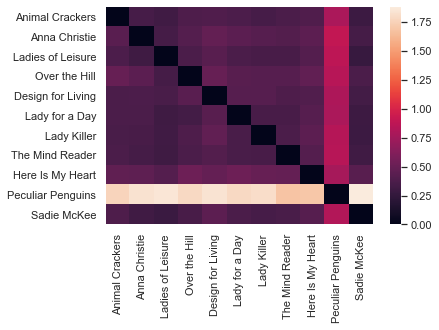

In [333]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns=fileids, index=fileids)
ax = sns.heatmap(div)
plt.show()


To reveal more patterns, let's do **a multidimensional scaling** of the matrix.

In [334]:
import warnings
warnings.filterwarnings("ignore")

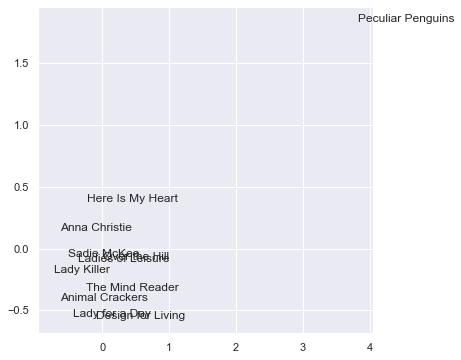

In [335]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

A co-respondent's course and The Chain Gang are away from the others - any guesses why?

We may just want to focus on the distrbution of stopwords or non-stopwords. Let's do the analysis again first for stopwords and then for non-stopwords.

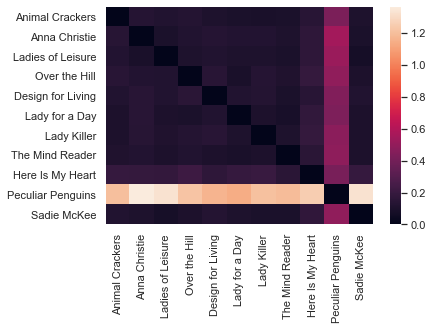

In [336]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p, q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns=fileids, index=fileids)
ax = sns.heatmap(div)
plt.show()

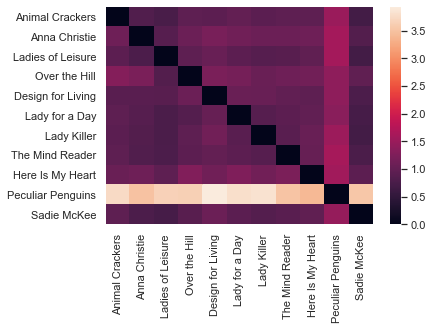

In [337]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

Now we compute the same for the assymmetric $\chi^2$ Divergence.

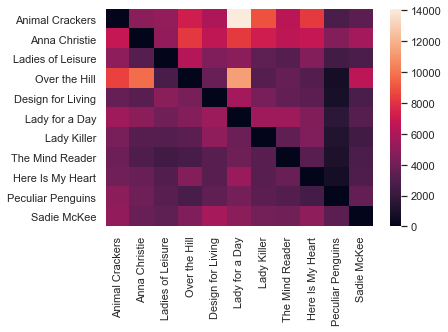

In [338]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns=fileids, index=fileids)
ax = sns.heatmap(div)
plt.show()

For the KS distance:

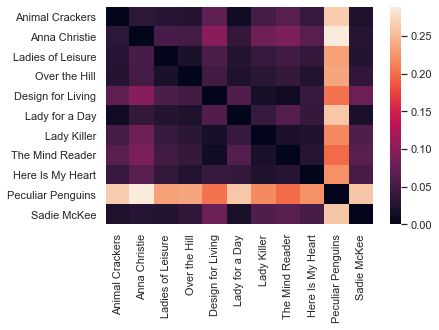

In [339]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns=fileids, index=fileids)
ax = sns.heatmap(div)
plt.show()

And finally for the Wasserstein or "earth mover's" Distance.

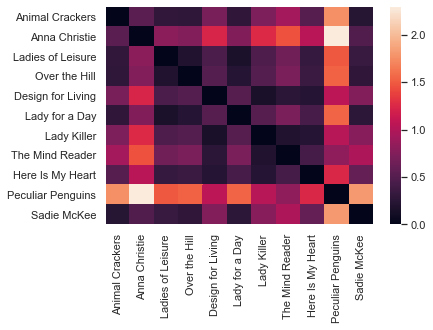

In [340]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns=fileids, index=fileids)
ax = sns.heatmap(div)
plt.show()

You can see that decade X is highly divergent and this makes reading the plot somewhat difficult. Let's fix this by taking the log of each cell, which will reduce the distance of decode X from other texts as an outlier.

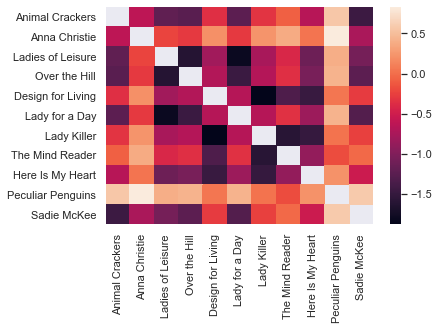

In [341]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

We only tried 11 movies, and from the same time period, so our signals might not be too interesting. What about different time periods?

An interesting experiment to maybe get some clearer signals: documents by decade in the Davies Corpus Of Historial American English (COHA) and see if we can detect patterns between them. 

If we want to rerun this on a new data set of our own composition, we can be a bit more efficient with our coding. Let's use the Shakespeare texts from last week as example: 

In [342]:
shakespeare_df = lucem_illud_2020.loadTextDirectory('../data/Shakespeare')

Now we stem and remove stopwords

In [343]:
shakespeare_df['tokenized_text'] = shakespeare_df['text'].apply(lambda x: word_tokenize(x))
shakespeare_df['normalized_tokens'] = shakespeare_df['tokenized_text'].apply(lambda x: normalizeTokens(x))

Create the corpus file and generate the heatmap:

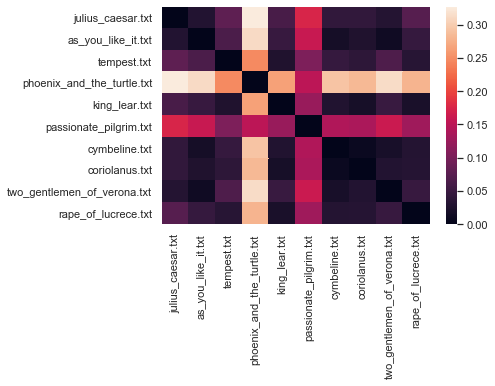

In [344]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 #The bigger this number the slower it will run, you can also try selecting your own plays
fileids_sp = list(shakespeare_df[:num_of_texts].index)
corpora_sp = list(shakespeare_df[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns=fileids_sp, index=fileids_sp)
ax = sns.heatmap(div)
plt.show()

What are "The Passionate Pilgrim" and "The Phoenix and the Turtle"? Little known poems by Shakespeare that are unsurprisingly hard to classify, as they are so different from everything else he wrote.

## <span style="color:red">*Exercise 8*</span>

<span style="color:red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better? 

<span style="color:red">**Stretch**: Calculate the <a "href=https://en.wikipedia.org/wiki/Jensen–Shannon_divergence" target="_blank">Jensen-Shannon Divergence</a> between your four corpora. What is the relationship between the KL and JS divergences?</span> 

The corpora are constructed by dividing the `speech` dataframe according to the individual-level and the time-spefic dimensions. Conretely, I randomly choose 10 speeches of Trump and Obama during their presidency each during 2009-2014 and from 2017 up to now.

In [345]:
# Define some covenient funtions for calculating divergence and distances.
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns=['frequency'], index=list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns=['frequency'], index=list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [346]:
# Create the corpora
speech_corpora = []
for index, row in speech.iterrows():
    # Extract five instead of ten speeches from each president
    if index % 2 == 0:
        speech_corpora.append(row["tokens"])

speech_corpora[:1]

[['Well',
  'thank',
  'you',
  'very',
  'much',
  'Applause',
  'Thank',
  'you',
  'Thank',
  'you',
  'Wow',
  'Applause',
  'Well',
  'thank',
  'you',
  'very',
  'much',
  'everybody',
  'Wow',
  'We',
  '’ve',
  'all',
  'been',
  'through',
  'a',
  'lot',
  'together',
  'and',
  'we',
  'probably',
  'deserve',
  'that',
  'hand',
  'for',
  'all',
  'of',
  'us',
  'because',
  'it',
  '’s',
  'been',
  'a',
  'very',
  'unfair',
  'situation',
  'I',
  'invited',
  'some',
  'of',
  'our',
  'very',
  'good',
  'friends',
  'And',
  'we',
  'have',
  'limited',
  'room',
  'but',
  'everybody',
  'wanted',
  'to',
  'come',
  'We',
  'kept',
  'it',
  'down',
  'to',
  'a',
  'minimum',
  'And',
  'believe',
  'it',
  'or',
  'not',
  'this',
  'is',
  'a',
  'minimum',
  'But',
  'a',
  'tremendous',
  'thing',
  'was',
  'done',
  'over',
  'the',
  'last',
  'number',
  'of',
  'months',
  'but',
  'really',
  'if',
  'you',
  'go',
  'back',
  'to',
  'it',
  'over',
 

In [347]:
# Separate the normalized tokens into stopwords and non-stopwords.
speech_corpora_s = []
speech_corpora_nouns = []
for speech_corpus in speech_corpora:
    s = []
    nons = []
    doc = nlp(" ".join(speech_corpus))
    
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    speech_corpora_s.append(s)
    speech_corpora_nouns.append(nons)

In [348]:
# The total number fo corpora
len(speech_corpora)

10

In [349]:
# Generate `speech_id` to identify each speech
speech_id = list(speech["name"] + " " + speech["title"])
speech_id = speech_id[::2].copy()

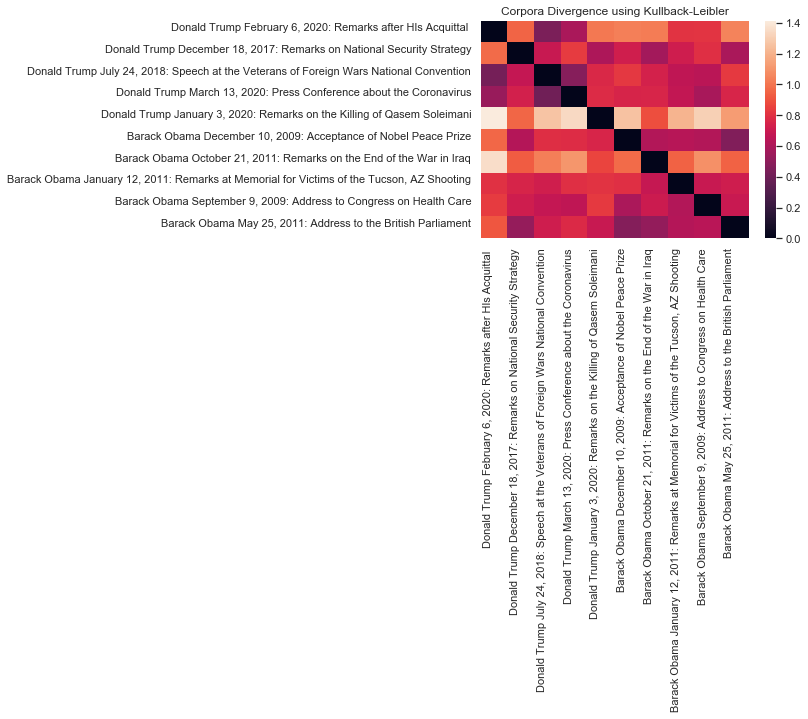

In [350]:
# Calculate the KL divergence for each pair of corpora
# Use heatmap to visualize the resulting matrix
L = []
for p in speech_corpora:
    l = []# 
    for q in speech_corpora:
        l.append(divergence(p, q, difference="KL"))
    L.append(l)
    
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns=speech_id, index=speech_id)
ax = sns.heatmap(div)
plt.title("Corpora Divergence using Kullback-Leibler")
plt.show()

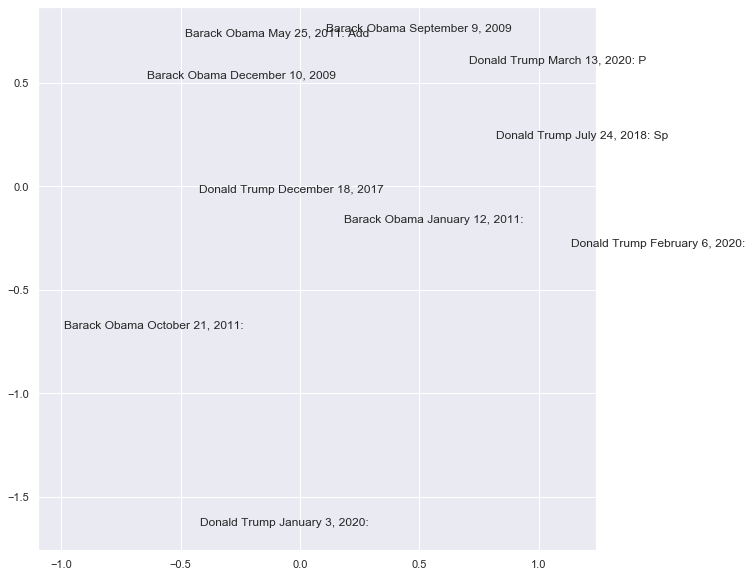

In [351]:
# Perform a multidimensional scaling of the matrix
mds = sklearn.manifold.MDS(random_state=25)
pos = mds.fit(M).embedding_
x = pos[:, 0]
y = pos[:, 1]
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(x, y, " ")
for i, txt in enumerate(speech_id):
    # Truncate the title 
    ax.annotate(txt[:30], (x[i], y[i]))

The multidimensional graph shows that the speech deliverede by Trump on January 3, 2020 *Remarks on the Killing of Qasem Soleimani* are away from the others.

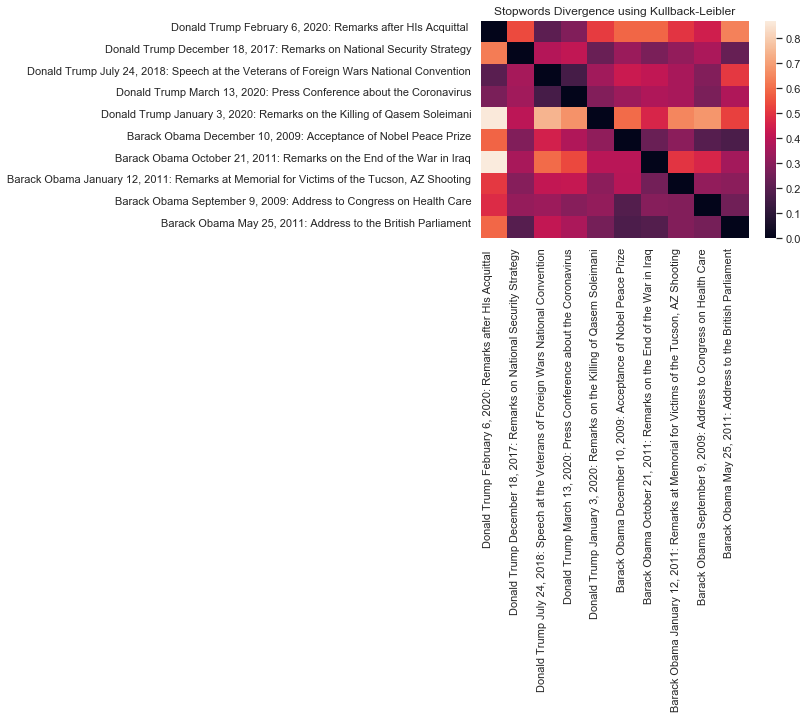

In [352]:
# Implement distribution on stopwords
L = []
for p in speech_corpora_s:
    l = []
    for q in speech_corpora_s:
        l.append(divergence(p, q, difference="KL"))
    L.append(l)
    
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns=speech_id, index=speech_id)
ax = sns.heatmap(div)
plt.title("Stopwords Divergence using Kullback-Leibler")
plt.show()

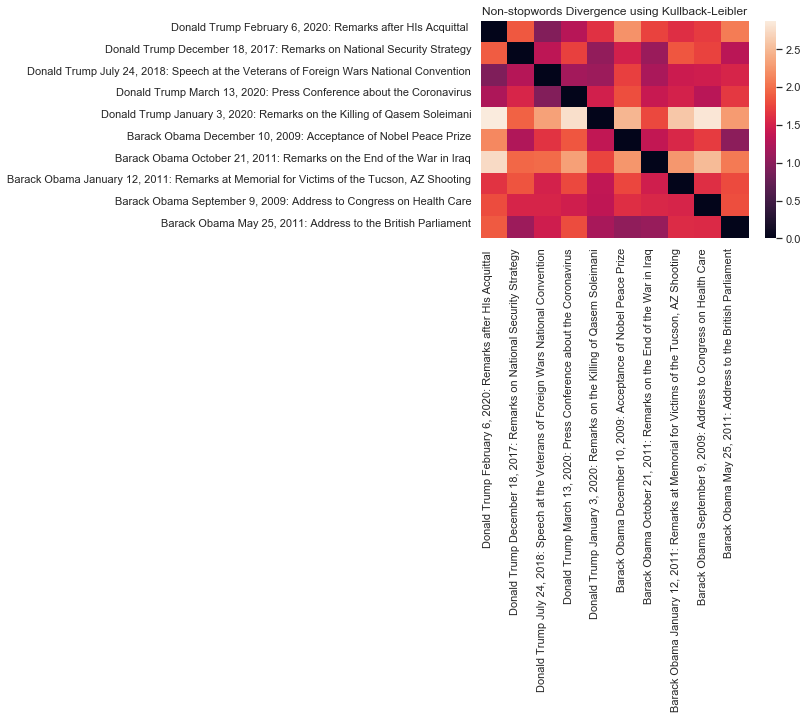

In [353]:
# Implement distribution on non-stopwords
L = []
for p in speech_corpora_nouns:
    l = []
    for q in speech_corpora_nouns:
        l.append(divergence(p, q, difference="KL"))
    L.append(l)
    
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns=speech_id, index=speech_id)
ax = sns.heatmap(div)
plt.title("Non-stopwords Divergence using Kullback-Leibler")
plt.show()

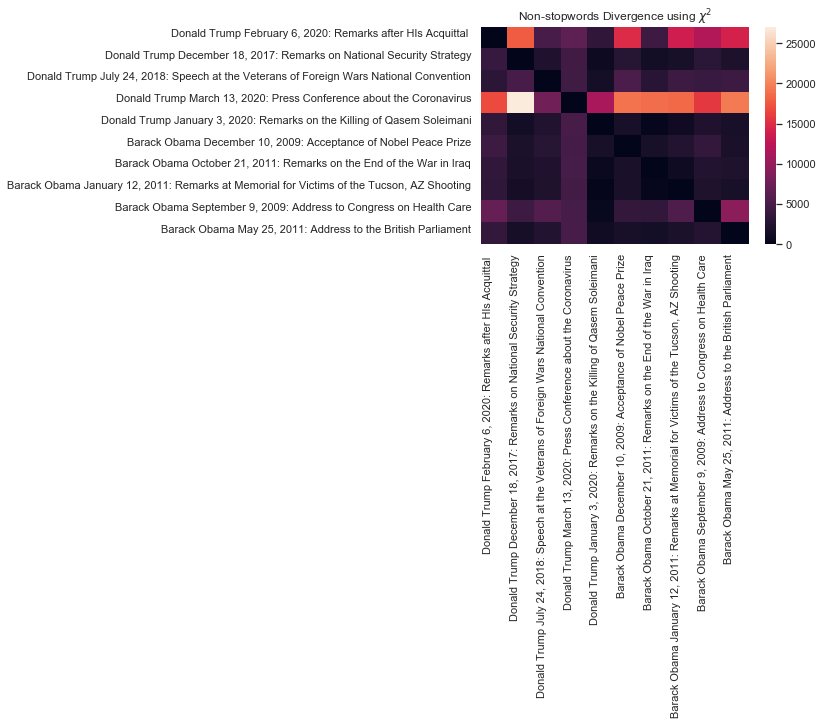

In [354]:
# Analyze the non-stopwords using chi-squared divergence
L = []
for p in speech_corpora_nouns:
    l = []
    for q in speech_corpora_nouns:
        l.append(divergence(p, q, difference="Chi2"))
    L.append(l)
    
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns=speech_id, index=speech_id)
ax = sns.heatmap(div)
plt.title(r"Non-stopwords Divergence using $\chi^{2}$")
plt.show()

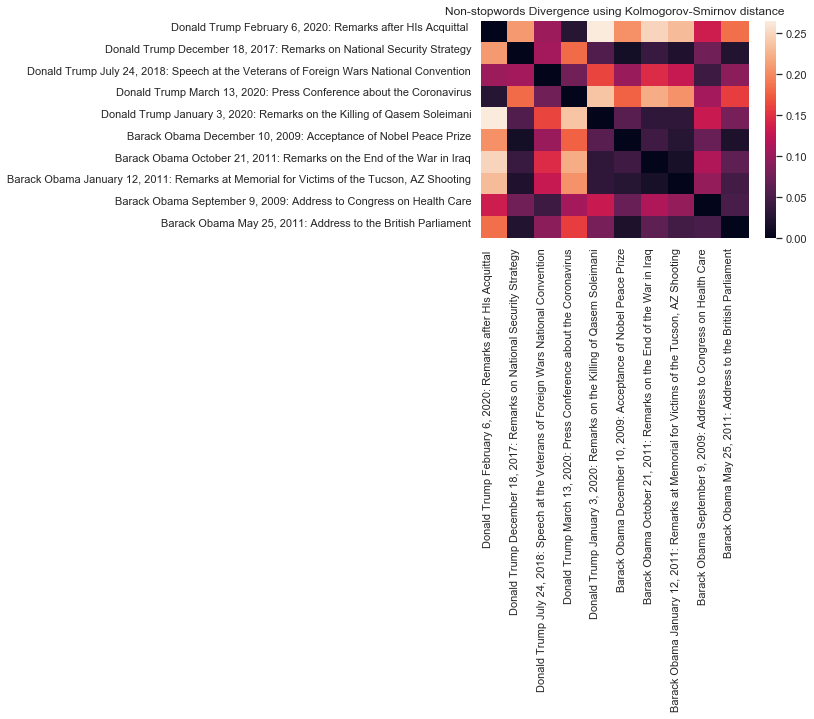

In [355]:
# Analyze the non-stopwords using KS distance
L = []
for p in speech_corpora_nouns:
    l = []
    for q in speech_corpora_nouns:
        l.append(divergence(p, q, difference="KS"))
    L.append(l)
    
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns=speech_id, index=speech_id)
ax = sns.heatmap(div)
plt.title(r"Non-stopwords Divergence using Kolmogorov-Smirnov distance")
plt.show()

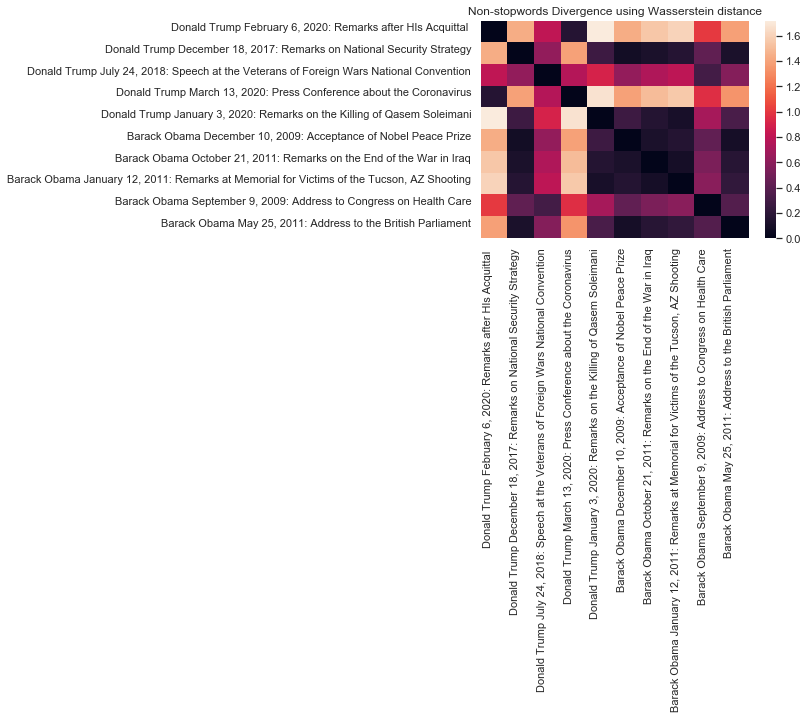

In [356]:
# Analyze the non-stopwords using Wasserstein distance
L = []
for p in speech_corpora_nouns:
    l = []
    for q in speech_corpora_nouns:
        l.append(divergence(p, q, difference="Wasserstein"))
    L.append(l)
    
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns=speech_id, index=speech_id)
ax = sns.heatmap(div)
plt.title(r"Non-stopwords Divergence using Wasserstein distance")
plt.show()

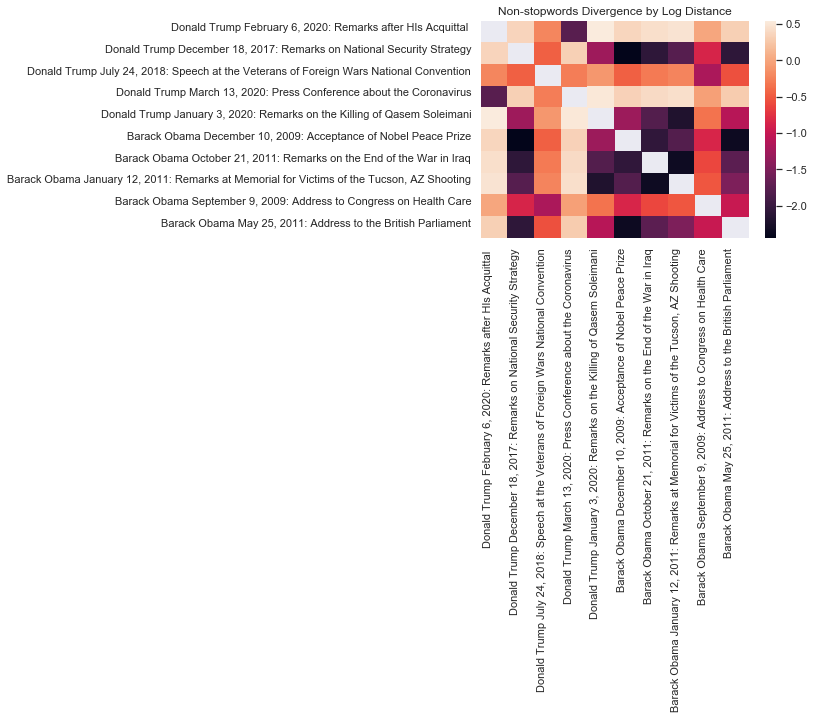

In [357]:
# Take the log of each cell to reduce the distance of decode X
# from other texts as an outlier
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.title("Non-stopwords Divergence by Log Distance")
plt.show()

From the heatmaps above, we can roughly infer that:

- The stopword usage in Trump's and Obama's speeches are more similar than the non-stop word usages since the former is represented with darker colors in the graph, which indicates different topics in the two American presidents' speeches.

- The divergence pattern of non-stop words measured by different methods fail to display a constant pattern across all speeches. Concretely, the non-stop word divergence calculated by Kullback-Leibler is relatively shallow-colored, whereas the divergence heatmap using chi-squared looks overall dark. However, both Kolmogorve-Smirnov distance and Wasserstein distance show that there is a high correlation among the four speeches, i.e. Trump's *Remarks on the Killing of Qasem Soleimani* on January 3, 2020, Obama's *Acceptance of Nobel Peace Prize* on December 10, 2009, Obama's *Remarks on the End of War in Iraq* on October 11, 2011, as well as Obama's *Remarks at Memorial for Victims of the Tucson, AZ Shooting* on January 12, 2011. The high similarity can be attributed to the fact that the topics covered in the four speeches are similar because they are concerned about peace and violence.